In [1]:

# ===== Cell 0: imports & Loading dataset ===================


import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score  # Add this import
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from typing import Dict, Tuple, Optional
from itertools import count


import os

OUT_DIR = "dataset/ed/finals/tables_Sep/step1"
os.makedirs(OUT_DIR, exist_ok=True)



df = pd.read_csv('dataset/ed/finals/16_finalwithsigmoid.csv')


In [2]:
# ===== Cell 1:  shared utilities (minimal & simple) =====


# Optional: nicer plot resolution
plt.rcParams["figure.dpi"] = 120

# Small constant to avoid 0/1 edge cases when taking logit
EPS = 1e-6

def _ensure_binary(y):
    """
    Make sure labels are 0/1 and return a numpy array.
    Why: prevents silent bugs if labels are strings/floats or have stray values.
    """
    arr = pd.to_numeric(y, errors="coerce").fillna(0).astype(int).values
    bad = set(np.unique(arr)) - {0, 1}
    if bad:
        raise ValueError(f"Labels must be 0/1; found {bad}.")
    return arr

def _safe_prob(p, eps=EPS):
    """
    Convert to float and clip probabilities to (eps, 1-eps).
    Why: keeps values valid and avoids exact 0/1 that break logit math.
    Note: after cleaning, you shouldn't have NaNs here.
    """
    return np.clip(pd.to_numeric(p, errors="coerce").values, eps, 1 - eps)

def _safe_logit(p, eps=EPS):
    """
    Probabilities -> logits with clipping: log(p/(1-p)).
    Why: avoids ±inf if any p is 0 or 1.
    """
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    return np.log(p / (1 - p))


In [3]:
# ===== Cell 1.1: numbered saving helpers ============================


# folders under your OUT_DIR (optional but tidy)
PLOTS_DIR  = os.path.join(OUT_DIR, "plots")
TABLES_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)

# independent counters for tables and plots, starting at 1
_table_counter = count(1)
_plot_counter  = count(1)

def save_table_numbered(df: pd.DataFrame, base_name: str, index: bool=False):
    """Save a DataFrame as CSV with auto numbering: 1_table_<name>.csv, 2_table_....csv"""
    n = next(_table_counter)
    safe = base_name.lower().replace(" ", "_")
    path = os.path.join(TABLES_DIR, f"{n}_table_{safe}.csv")
    df.to_csv(path, index=index)
    print(f"[saved table] {path}")
    return path

def savefig_numbered(base_name: str, dpi: int=300, fmt: str="png"):
    """Save the current Matplotlib figure with auto numbering: 1_plot_<name>.png, 2_plot_....png"""
    n = next(_plot_counter)
    safe = base_name.lower().replace(" ", "_")
    path = os.path.join(PLOTS_DIR, f"{n}_plot_{safe}.{fmt}")
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[saved plot]  {path}")
    return path


In [4]:
# ===== Cell 2: cleaning (super simple) =====
def clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Very simple cleaner:
      1) Show how many rows and how many miss the score/label
      2) Keep only rows that have BOTH
      3) Make sure the score is in [0,1] and the label is 0/1
      4) Print after-cleaning summary
    """
    print("=== CLEANING ===")
    print(f"Rows BEFORE: {len(df):,}")
    miss_prob = int(df[prob_col].isna().sum())
    miss_lbl  = int(df[y_col].isna().sum())
    print(f"Missing {prob_col}: {miss_prob:,}")
    print(f"Missing {y_col}: {miss_lbl:,}")

    # Keep rows that have both a score and a label
    out = df.loc[df[prob_col].notna() & df[y_col].notna()].copy()

    # Make types clean and safe
    out[prob_col] = pd.to_numeric(out[prob_col], errors="coerce").astype(float).clip(0, 1)
    out[y_col]    = pd.to_numeric(out[y_col], errors="coerce").astype(int)

    # Drop any row that became NaN during coercion (rare)
    out = out.dropna(subset=[prob_col, y_col])

    kept = len(out)
    print("\n=== AFTER CLEANING ===")
    print(f"Rows AFTER : {kept:,}  (kept {kept/len(df):.1%} of original)")
    if kept > 0:
        lbl_vals = sorted(pd.Series(out[y_col]).unique().tolist())
        print(f"Label values present: {lbl_vals}")
        print(f"Prevalence (mean of {y_col}): {out[y_col].mean():.4f}")
        print(f"{prob_col}: mean={out[prob_col].mean():.4f}, min={out[prob_col].min():.4f}, max={out[prob_col].max():.4f}")
        print("\nPreview (first 3 rows of score+label):")
        print(out[[prob_col, y_col]].head(3))
    return out



assert "mortality_prob" in df.columns
assert "died_within_30_days" in df.columns

df_clean = clean_dataset_simple(df, prob_col="mortality_prob", y_col="died_within_30_days")
save_table_numbered(df_clean, "cleaned_dataset", index=False)



=== CLEANING ===
Rows BEFORE: 591,892
Missing mortality_prob: 358,997
Missing died_within_30_days: 0

=== AFTER CLEANING ===
Rows AFTER : 232,895  (kept 39.3% of original)
Label values present: [0, 1]
Prevalence (mean of died_within_30_days): 0.0222
mortality_prob: mean=0.0163, min=0.0000, max=0.9417

Preview (first 3 rows of score+label):
   mortality_prob  died_within_30_days
0        0.003980                    0
3        0.010333                    0
4        0.002620                    0
[saved table] dataset/ed/finals/tables_Sep/step1\tables\1_table_cleaned_dataset.csv


'dataset/ed/finals/tables_Sep/step1\\tables\\1_table_cleaned_dataset.csv'

In [5]:
# ============ ruuning cell 1&2 =============


print("NaNs after cleaning:",
      df_clean[["mortality_prob","died_within_30_days"]].isna().sum().to_dict())


# >>> Use the CLEANED dataframe, not df <<<

# extra guards
assert df_clean["mortality_prob"].notna().all()
assert df_clean["died_within_30_days"].notna().all()

# build arrays from df_clean
y = _ensure_binary(df_clean["died_within_30_days"])
p = _safe_prob(df_clean["mortality_prob"])
z = _safe_logit(p)

# quick prints
print("\ny (first 10):", y[:10])
print("p (first 10):", np.round(p[:10], 6))
print("z=logit(p) (first 10):", np.round(z[:10], 3))

# checks (should all pass now)
assert set(np.unique(y)).issubset({0, 1}), "Labels must be 0/1"
assert np.isfinite(p).all(), "Probabilities contain NaN/inf"
assert (p > 0).all() and (p < 1).all(), "Probabilities should be strictly inside (0,1)"
assert np.isfinite(z).all(), "Logits contain NaN/inf"

print(" \nHelpers working on CLEANED data. with Shapes:\n", y.shape, p.shape, z.shape)

# optional: show coverage before vs after cleaning
print(f"\nCoverage (original df):  {df['mortality_prob'].notna().mean():.3f}")
print(f"Coverage (cleaned set): {df_clean['mortality_prob'].notna().mean():.3f}")



NaNs after cleaning: {'mortality_prob': 0, 'died_within_30_days': 0}

y (first 10): [0 0 0 0 0 0 0 0 0 0]
p (first 10): [0.00398  0.010333 0.00262  0.00398  0.024288 0.00398  0.00028  0.000693
 0.000488 0.005441]
z=logit(p) (first 10): [-5.523 -4.562 -5.942 -5.523 -3.693 -5.523 -8.181 -7.274 -7.625 -5.208]
 
Helpers working on CLEANED data. with Shapes:
 (232895,) (232895,) (232895,)

Coverage (original df):  0.393
Coverage (cleaned set): 1.000


In [11]:
# ===== Cell 3 (simple): missing values + summary only =================

def eda_overview_simple(df, save_prefix="eda_overview"):
    print("=== DATASET OVERVIEW (simple) ===")
    print(f"Rows: {len(df):,}")
    print(f"Columns ({len(df.columns)}): {sorted(df.columns.tolist())}\n")

    # ---- Missingness table ----
    miss = df.isna().sum().to_frame("n_missing")
    miss["pct_missing"] = (miss["n_missing"] / len(df)).round(4)
    miss = miss.sort_values("n_missing", ascending=False)
    print("Missingness (all columns):")
    display(miss)
    # numbered save
    save_table_numbered(miss, f"{save_prefix}_missingness", index=True)

    # ---- Numeric summary ----
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    num_summary = None
    if num_cols:
        print("\nNumeric columns: describe()")
        num_summary = df[num_cols].describe().T
        display(num_summary)
        # numbered save
        save_table_numbered(num_summary, f"{save_prefix}_numeric_summary", index=True)
    else:
        print("\n[info] No numeric columns detected.")

    # ---- Categorical summary ----
    cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    cat_summary = None
    if cat_cols:
        print("\nCategorical columns: describe(include='object')")
        cat_summary = df[cat_cols].describe(include='object').T
        display(cat_summary)
        # numbered save
        save_table_numbered(cat_summary, f"{save_prefix}_categorical_summary", index=True)
    else:
        print("\n[info] No categorical columns detected.")

    return miss, num_summary, cat_summary

# run
miss_tbl, num_tbl, cat_tbl = eda_overview_simple(df_clean, save_prefix="eda_dfclean")


=== DATASET OVERVIEW (simple) ===
Rows: 232,895
Columns (33): ['age_group', 'anchor_age', 'anchor_year', 'anchor_year_group', 'chiefcomplaint', 'counter', 'counter_new', 'dead_in_days', 'died_within_30_days', 'dod', 'ed_age', 'expanded_symptoms', 'expanded_symptoms_new', 'gender', 'indiv_symptom', 'intime', 'is_male', 'mortality_percent', 'mortality_prob', 'mu', 'outtime', 'race', 'race_standard', 'sigma', 'snomed', 'stay_id', 'subject_id', 'symptom', 'terms', 'terms_new', 'unique_ids_exploded', 'unique_ids_exploded_new', 'unique_visit_id']

Missingness (all columns):


n_missing  pct_missing
dead_in_days                188854       0.8109
dod                         188854       0.8109
snomed                       76703       0.3293
unique_ids_exploded_new          0       0.0000
unique_ids_exploded              0       0.0000
expanded_symptoms                0       0.0000
expanded_symptoms_new            0       0.0000
counter_new                      0       0.0000
subject_id                       0       0.0000
indiv_symptom                    0       0.0000
is_male                          0       0.0000
ed_age                           0       0.0000
symptom                          0       0.0000
mu                               0       0.0000
sigma                            0       0.0000
mortality_prob                   0       0.0000
counter                          0       0.0000
terms                            0       0.0000
terms_new                        0       0.0000
stay_id                          0       0.0000
unique_visit_id                  0       0.0000
age_group                        0       0.0000
race_standard                    0       0.0000
died_within_30_days              0       0.0000
anchor_year_group                0       0.0000
anchor_year                      0       0.0000
anchor_age                       0       0.0000
chiefcomplaint                   0       0.0000
race                             0       0.0000
gender                           0       0.0000
outtime                          0       0.0000
intime                           0       0.0000
mortality_percent                0       0.0000

[saved table] dataset/ed/finals/tables_Sep/step1\tables\2_table_eda_dfclean_missingness.csv

Numeric columns: describe()


count          mean           std           min  \
subject_id           232895.0  1.501241e+07  2.878744e+06  1.000003e+07   
stay_id              232895.0  3.500058e+07  2.888197e+06  3.000004e+07   
anchor_age           232895.0  5.013228e+01  1.964687e+01  1.800000e+01   
anchor_year          232895.0  2.153525e+03  2.371388e+01  2.110000e+03   
dead_in_days          44041.0  7.568990e+02  8.201682e+02  0.000000e+00   
died_within_30_days  232895.0  2.221173e-02  1.473718e-01  0.000000e+00   
counter              232895.0  1.318955e+00  5.569882e-01  1.000000e+00   
snomed               156192.0  1.603022e+08  1.546458e+08  2.901004e+06   
ed_age               232895.0  5.013228e+01  1.964687e+01  1.800000e+01   
symptom              232895.0  7.874038e+10  2.159836e+12  1.023001e+06   
mu                   232895.0 -5.749173e+00  2.056683e+00 -1.042169e+01   
sigma                232895.0  2.021446e-01  1.939902e-01  1.285968e-02   
mortality_prob       232895.0  1.627766e-02  4.456574e-02  2.977866e-05   
mortality_percent    232895.0  1.627766e+00  4.456574e+00  2.977866e-03   

                              25%           50%           75%           max  
subject_id           1.252098e+07  1.501462e+07  1.751129e+07  1.999983e+07  
stay_id              3.250715e+07  3.500002e+07  3.750707e+07  3.999996e+07  
anchor_age           3.300000e+01  5.000000e+01  6.500000e+01  9.100000e+01  
anchor_year          2.134000e+03  2.153000e+03  2.174000e+03  2.208000e+03  
dead_in_days         1.100000e+02  4.270000e+02  1.183000e+03  4.171000e+03  
died_within_30_days  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
counter              1.000000e+00  1.000000e+00  2.000000e+00  6.000000e+00  
snomed               2.985701e+07  6.231501e+07  2.671020e+08  4.225870e+08  
ed_age               3.300000e+01  5.000000e+01  6.500000e+01  9.100000e+01  
symptom              2.152200e+07  4.972700e+07  2.670360e+08  5.943100e+13  
mu                  -7.371390e+00 -5.719293e+00 -4.115405e+00  2.781684e+00  
sigma                6.150430e-02  1.316826e-01  2.823148e-01  1.147065e+00  
mortality_prob       6.285980e-04  3.271292e-03  1.605728e-02  9.416780e-01  
mortality_percent    6.285980e-02  3.271292e-01  1.605728e+00  9.416780e+01

[saved table] dataset/ed/finals/tables_Sep/step1\tables\3_table_eda_dfclean_numeric_summary.csv

Categorical columns: describe(include='object')


count  unique                  top    freq
intime                   232895  187552  2139-07-05 18:37:00       6
outtime                  232895  187616  2182-05-08 17:44:00       6
gender                   232895       2                    F  136433
race                     232895      33                WHITE  119649
chiefcomplaint           232895   21820           Chest pain   11300
anchor_year_group        232895       4          2008 - 2010   69621
dod                       44041   11153           2151-12-29     217
race_standard            232895       8                White  131424
age_group                232895       5                46-65   77961
unique_visit_id          232895  187963    14051166_35211695       6
terms                    232895   20626         ['abd pain']   17900
terms_new                232895   20591             abd pain   17900
indiv_symptom            232895     477             abd pain   35879
unique_ids_exploded      232895  232468           31195432_1       3
expanded_symptoms        232895     318   ['abdominal pain']   38517
expanded_symptoms_new    232895     134       abdominal pain   38663
counter_new              232895       3                    a  232377
unique_ids_exploded_new  232895  232895         33258284_1_a       1

[saved table] dataset/ed/finals/tables_Sep/step1\tables\4_table_eda_dfclean_categorical_summary.csv



[gender] distribution:


count
gender        
F       136433
M        96462

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\1_plot_dist_gender_counts.png


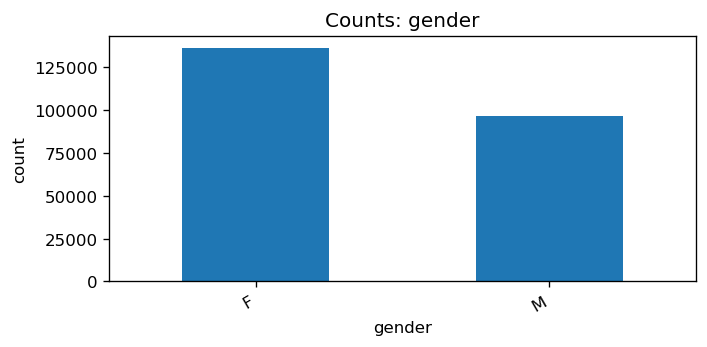


[race] distribution:


count
race                                             
WHITE                                      119649
BLACK/AFRICAN AMERICAN                      43689
OTHER                                       11714
HISPANIC/LATINO - PUERTO RICAN               9160
WHITE - OTHER EUROPEAN                       5575
HISPANIC/LATINO - DOMINICAN                  5561
BLACK/CAPE VERDEAN                           4949
ASIAN - CHINESE                              4354
ASIAN                                        3886
WHITE - RUSSIAN                              3590
BLACK/AFRICAN                                2796
UNKNOWN                                      2476
BLACK/CARIBBEAN ISLAND                       2253
HISPANIC/LATINO - GUATEMALAN                 1459
HISPANIC OR LATINO                           1159
HISPANIC/LATINO - SALVADORAN                  939
ASIAN - SOUTH EAST ASIAN                      932
PORTUGUESE                                    908
ASIAN - ASIAN INDIAN                          881
WHITE - BRAZILIAN                             871
WHITE - EASTERN EUROPEAN                      831
HISPANIC/LATINO - COLUMBIAN                   739
HISPANIC/LATINO - MEXICAN                     664
SOUTH AMERICAN                                661
HISPANIC/LATINO - HONDURAN                    579
AMERICAN INDIAN/ALASKA NATIVE                 546
HISPANIC/LATINO - CENTRAL AMERICAN            499
HISPANIC/LATINO - CUBAN                       448
ASIAN - KOREAN                                400
PATIENT DECLINED TO ANSWER                    290
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     285
MULTIPLE RACE/ETHNICITY                        90
UNABLE TO OBTAIN                               62

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\2_plot_dist_race_counts.png


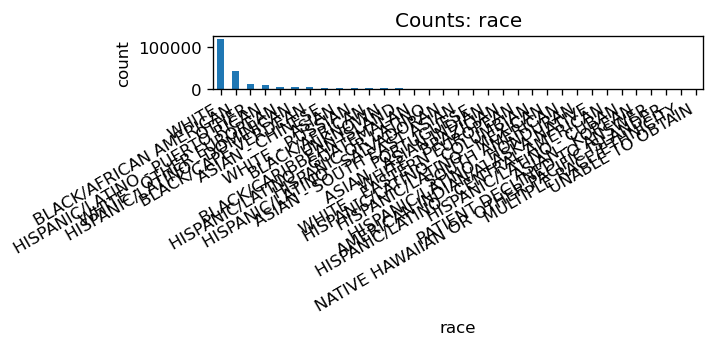


[race_standard] distribution:


count
race_standard                           
White                             131424
Black                              53687
Hispanic/Latino                    21868
Other/Unknown/Not Reported         14542
Asian                              10453
American Indian/Alaska Native        546
Native Hawaiian/Pacific Islander     285
Multiple Races                        90

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\3_plot_dist_race_standard_counts.png


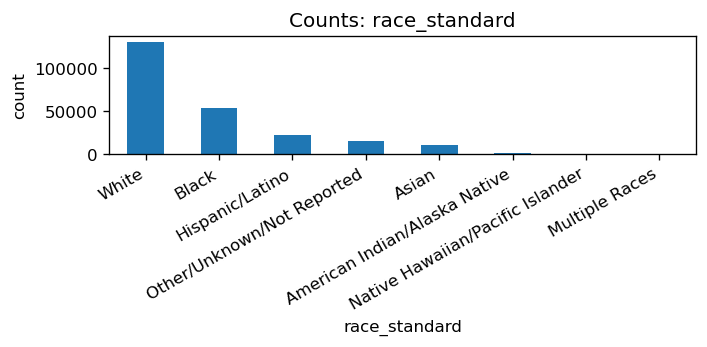


[anchor_age] summary stats:


count    232895.000000
mean         50.132278
std          19.646866
min          18.000000
25%          33.000000
50%          50.000000
75%          65.000000
max          91.000000
Name: anchor_age, dtype: float64

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\4_plot_dist_anchor_age_hist.png


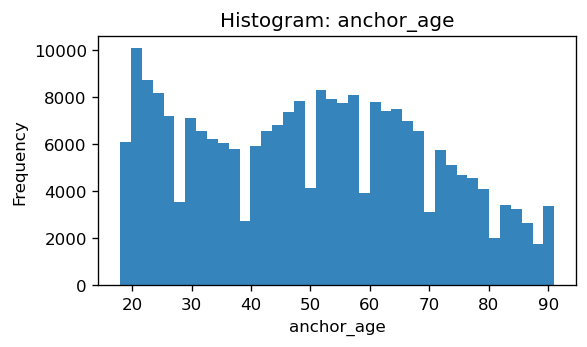

In [12]:
# ===== Cell 4: distributions (restricted to key variables) ============

def plot_key_distributions(df, save_prefix="dist"):
    # --- categorical variables ---
    cat_cols = [c for c in ["gender", "race", "race_standard", "anchor_age_group"] if c in df.columns]
    for c in cat_cols:
        vc = df[c].astype("object").value_counts(dropna=False)
        print(f"\n[{c}] distribution:")
        display(vc.to_frame("count"))

        ax = vc.plot(kind="bar", figsize=(6,3), title=f"Counts: {c}")
        ax.set_ylabel("count")
        ax.set_xlabel(c)
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        # SAVE FIRST, then show, then close
        savefig_numbered(f"{save_prefix}_{c}_counts")
        plt.show()
        plt.close()

    # --- numeric variable ---
    if "anchor_age" in df.columns:
        print("\n[anchor_age] summary stats:")
        display(df["anchor_age"].describe())

        ax = df["anchor_age"].dropna().plot(
            kind="hist", bins=40, alpha=0.9, figsize=(5,3),
            title="Histogram: anchor_age"
        )
        ax.set_xlabel("anchor_age")
        plt.tight_layout()
        # SAVE FIRST, then show, then close
        savefig_numbered(f"{save_prefix}_anchor_age_hist")
        plt.show()
        plt.close()

# run
plot_key_distributions(df_clean, save_prefix="dist")



=== GENDER: tables ===


group       n     share
0     F  136433  0.585813
1     M   96462  0.414187

gender       n  deaths  prevalence  death_share  expected_deaths  \
0      F  136433    2467    0.018082     0.476899      3030.412456   
1      M   96462    2706    0.028052     0.523101      2142.587544   

   standardized_ratio  
0            0.814081  
1            1.262959


=== GENDER: 3 plots (with % labels) ===
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\5_plot_gender_counts.png


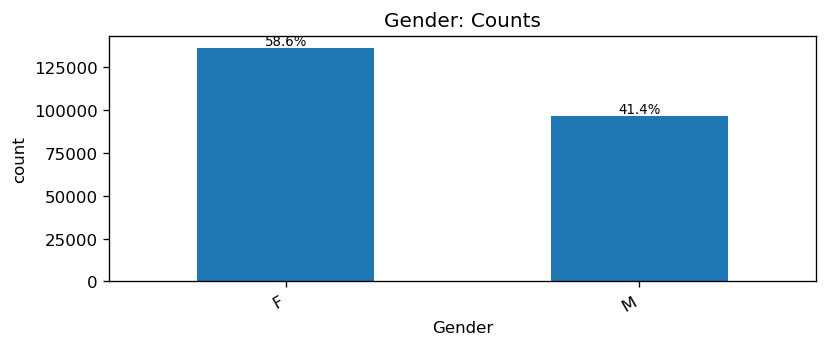

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\6_plot_gender_deaths.png


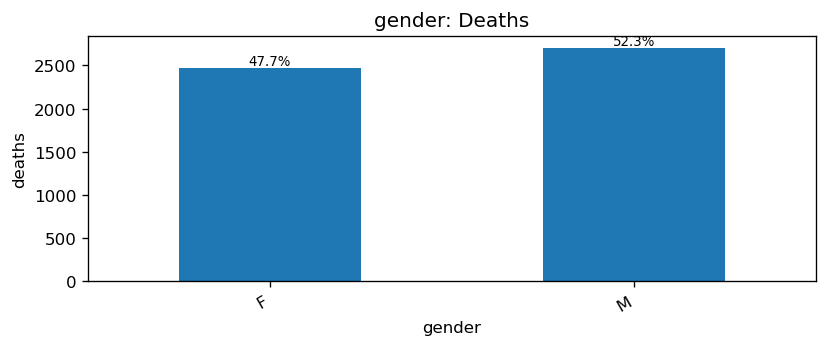

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\7_plot_gender_prevalence.png


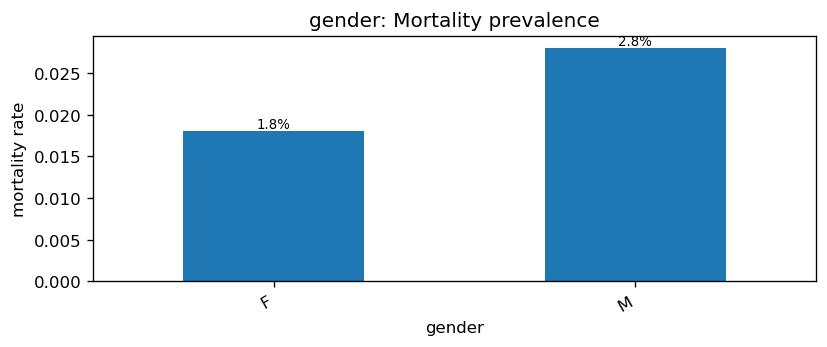


=== RACE_STANDARD: tables ===


group       n     share
0                             White  131424  0.564306
1                             Black   53687  0.230520
2                   Hispanic/Latino   21868  0.093896
3        Other/Unknown/Not Reported   14542  0.062440
4                             Asian   10453  0.044883
5     American Indian/Alaska Native     546  0.002344
6  Native Hawaiian/Pacific Islander     285  0.001224
7                    Multiple Races      90  0.000386

race_standard       n  deaths  prevalence  death_share  \
7                             White  131424    3590    0.027316     0.693988   
2                             Black   53687     683    0.012722     0.132032   
3                   Hispanic/Latino   21868     196    0.008963     0.037889   
6        Other/Unknown/Not Reported   14542     440    0.030257     0.085057   
1                             Asian   10453     245    0.023438     0.047361   
0     American Indian/Alaska Native     546       4    0.007326     0.000773   
5  Native Hawaiian/Pacific Islander     285      15    0.052632     0.002900   
4                    Multiple Races      90       0    0.000000     0.000000   

   expected_deaths  standardized_ratio  
7      2919.153919            1.229808  
2      1192.480951            0.572755  
3       485.726031            0.403520  
6       323.002924            1.362217  
1       232.179175            1.055220  
0        12.127603            0.329826  
5         6.330342            2.369540  
4         1.999055            0.000000


=== RACE_STANDARD: 3 plots (with % labels) ===
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\8_plot_race_(standard)_counts.png


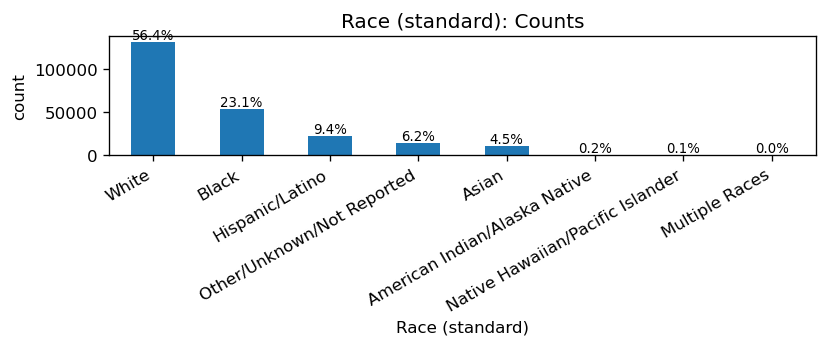

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\9_plot_race_standard_deaths.png


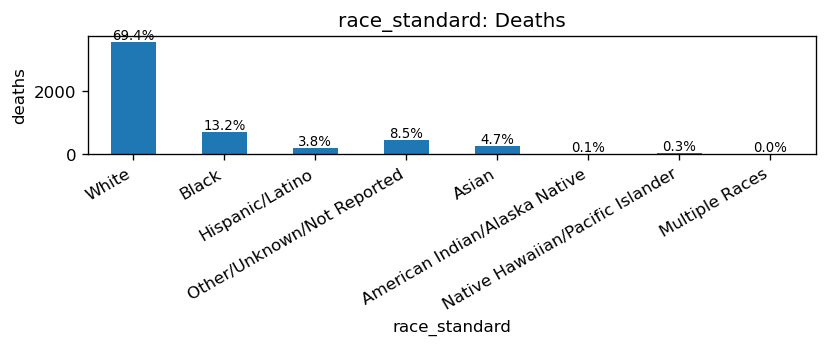

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\10_plot_race_standard_prevalence.png


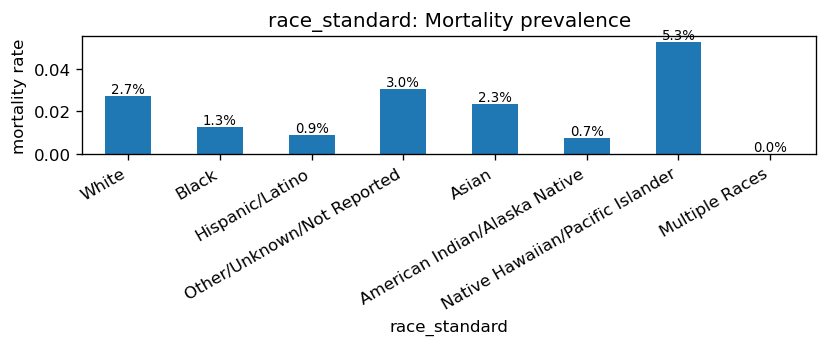


=== INTERSECTION (gender × race_standard): tables ===


gender                                F      M
race_standard                                 
American Indian/Alaska Native       312    234
Asian                              6184   4269
Black                             35195  18492
Hispanic/Latino                   13985   7883
Multiple Races                       53     37
Native Hawaiian/Pacific Islander    143    142
Other/Unknown/Not Reported         8469   6073
White                             72092  59332

gender                                 F       M
race_standard                                   
American Indian/Alaska Native        1.0     3.0
Asian                               90.0   155.0
Black                              400.0   283.0
Hispanic/Latino                     92.0   104.0
Multiple Races                       0.0     0.0
Native Hawaiian/Pacific Islander     3.0    12.0
Other/Unknown/Not Reported         206.0   234.0
White                             1675.0  1915.0


=== INTERSECTION (gender × race_standard): 3 plots (with % labels) ===
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\11_plot_counts_race_standard_by_gender.png


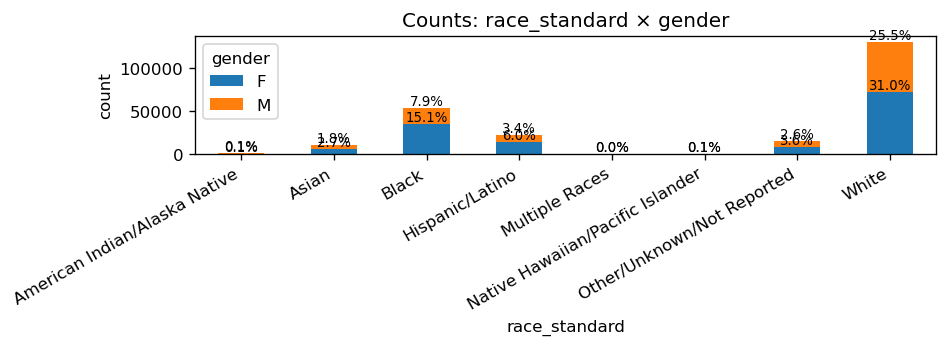

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\12_plot_deaths_race_standard_by_gender.png


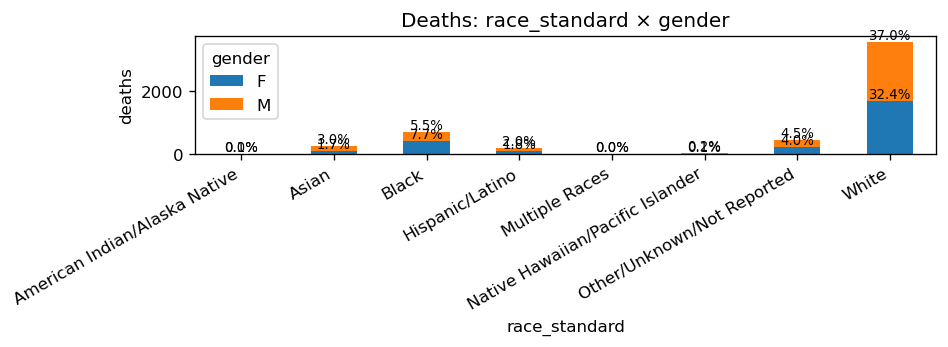

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\13_plot_prevalence_race_standard_by_gender.png


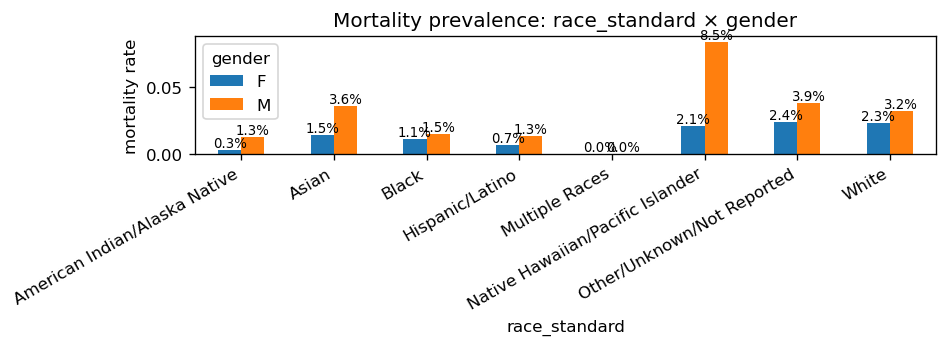

[saved table] dataset/ed/finals/tables_Sep/step1\tables\5_table_group_gender_counts.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\6_table_group_gender_deaths_smr.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\7_table_group_race_standard_counts.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\8_table_group_race_standard_deaths_smr.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\9_table_intersection_counts_race_standard_by_gender.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\10_table_intersection_deaths_race_standard_by_gender.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\11_table_intersection_prevalence_race_standard_by_gender.csv
Saved tables to: dataset/ed/finals/tables_Sep/step1\tables


In [15]:
# ===== Cell 5 : group balance + bias tables/plots  (simple, with % labels) ====

# ---------------------------- small table builders ----------------------------

def counts_table(df, group_col):
    """Counts + group share."""
    if group_col not in df.columns:
        print(f"[skip] '{group_col}' not in df")
        return None
    total_n = len(df)
    t = df[group_col].value_counts(dropna=False).rename("n").to_frame()
    t.index = t.index.astype("object")
    t["group"] = t.index
    t["share"] = t["n"] / total_n
    return t[["group","n","share"]].reset_index(drop=True)

def deaths_table(df, group_col, y_col="died_within_30_days"):
    """Deaths + within-group prevalence + death share + expected + standardized ratio."""
    if group_col not in df.columns:
        print(f"[skip] '{group_col}' not in df")
        return None
    overall_prev = df[y_col].mean()
    total_deaths = df[y_col].sum()

    gb = df.groupby(group_col)[y_col]
    t = gb.agg(n="size", deaths="sum").reset_index()
    t["prevalence"] = t["deaths"] / t["n"]                             # within-group death rate
    t["death_share"] = t["deaths"] / total_deaths if total_deaths > 0 else np.nan
    t["expected_deaths"] = t["n"] * overall_prev                       # expected if group matched overall rate
    t["standardized_ratio"] = t["deaths"] / t["expected_deaths"]       # observed / expected
    return t.sort_values("n", ascending=False)

def intersection_tables(df, row_col="race_standard", col_col="gender", y_col="died_within_30_days"):
    """Simple pivots: counts, deaths, prevalence."""
    if row_col not in df.columns or col_col not in df.columns:
        print(f"[skip] intersection missing '{row_col}' or '{col_col}'")
        return None, None, None
    counts = pd.crosstab(df[row_col], df[col_col])
    deaths = pd.crosstab(df[row_col], df[col_col], values=df[y_col], aggfunc="sum").fillna(0).astype(float)
    prev = pd.crosstab(df[row_col], df[col_col], values=df[y_col], aggfunc="mean")
    return counts, deaths, prev

# ---------------------------- helpers: bar labels -----------------------------

def _add_bar_labels(ax, perc_values, is_rate=False):
    """Attach % labels above bars for single-series plots."""
    for p, v in zip(ax.patches, perc_values):
        if pd.isna(v): 
            continue
        label = f"{v*100:.1f}%" if is_rate else f"{v:.1f}%"
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=8)

def _add_stacked_or_grouped_labels(ax, perc_matrix):
    """
    Add % labels for stacked or grouped bars produced by pandas.
    Assumes patches order is by series (columns) then bars (rows), which matches pandas.
    """
    if perc_matrix is None or perc_matrix.size == 0:
        return
    # Flatten by columns to match patch order (col-major in pandas plotting)
    labels = perc_matrix.values.flatten(order="F")
    for p, v in zip(ax.patches, labels):
        if pd.isna(v): 
            continue
        ax.annotate(f"{v:.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height()),
                    ha='center', va='bottom', fontsize=8)

# ---------------------------- simple 3-plot panels ----------------------------

def plot_counts(tbl, group_col_label):
    """Plot group counts with % of total on bars."""
    if tbl is None or tbl.empty: 
        return
    total_n = tbl["n"].sum()
    perc = (tbl["n"] / total_n) * 100
    ax = tbl.set_index("group")["n"].plot(kind="bar", figsize=(7,3), title=f"{group_col_label}: Counts")
    ax.set_ylabel("count"); ax.set_xlabel(group_col_label)
    _add_bar_labels(ax, perc, is_rate=False)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    # save before show
    savefig_numbered(f"{group_col_label.lower().replace(' ','_')}_counts")
    plt.show(); plt.close()

def plot_deaths(tbl, group_col):
    """Plot group death counts with % of total deaths on bars."""
    if tbl is None or tbl.empty: 
        return
    total_deaths = tbl["deaths"].sum()
    perc = (tbl["deaths"] / total_deaths) * 100 if total_deaths > 0 else pd.Series([np.nan]*len(tbl))
    ax = tbl.set_index(group_col)["deaths"].plot(kind="bar", figsize=(7,3), title=f"{group_col}: Deaths")
    ax.set_ylabel("deaths"); ax.set_xlabel(group_col)
    _add_bar_labels(ax, perc, is_rate=False)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    savefig_numbered(f"{group_col.lower().replace(' ','_')}_deaths")
    plt.show(); plt.close()

def plot_prevalence(tbl, group_col):
    """Plot within-group mortality rate with % labels."""
    if tbl is None or tbl.empty: 
        return
    perc = tbl["prevalence"]  # 0..1
    ax = tbl.set_index(group_col)["prevalence"].plot(kind="bar", figsize=(7,3), title=f"{group_col}: Mortality prevalence")
    ax.set_ylabel("mortality rate"); ax.set_xlabel(group_col)
    _add_bar_labels(ax, perc, is_rate=True)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    savefig_numbered(f"{group_col.lower().replace(' ','_')}_prevalence")
    plt.show(); plt.close()

# ---------------------------- intersection plots -----------------------------

def plot_intersection_counts(counts_df, row_col, col_col):
    """
    Stacked counts bars; labels show % of total patients for each segment.
    """
    if counts_df is None or counts_df.empty:
        return
    total = counts_df.values.sum()
    perc_matrix = (counts_df / total) * 100 if total > 0 else None
    ax = counts_df.plot(kind="bar", stacked=True, figsize=(8,3), title=f"Counts: {row_col} × {col_col}")
    ax.set_ylabel("count"); ax.set_xlabel(row_col)
    _add_stacked_or_grouped_labels(ax, perc_matrix)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    savefig_numbered(f"counts_{row_col}_by_{col_col}")
    plt.show(); plt.close()

def plot_intersection_deaths(deaths_df, row_col, col_col):
    """
    Stacked deaths bars; labels show % of total deaths for each segment.
    """
    if deaths_df is None or deaths_df.empty:
        return
    total = deaths_df.values.sum()
    perc_matrix = (deaths_df / total) * 100 if total > 0 else None
    ax = deaths_df.plot(kind="bar", stacked=True, figsize=(8,3), title=f"Deaths: {row_col} × {col_col}")
    ax.set_ylabel("deaths"); ax.set_xlabel(row_col)
    _add_stacked_or_grouped_labels(ax, perc_matrix)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    savefig_numbered(f"deaths_{row_col}_by_{col_col}")
    plt.show(); plt.close()

def plot_intersection_prevalence(prev_df, row_col, col_col):
    """
    Grouped prevalence bars; labels show prevalence % within each subgroup.
    """
    if prev_df is None or prev_df.empty:
        return
    perc_matrix = prev_df * 100  # convert to %
    ax = prev_df.plot(kind="bar", figsize=(8,3), title=f"Mortality prevalence: {row_col} × {col_col}")
    ax.set_ylabel("mortality rate"); ax.set_xlabel(row_col)
    _add_stacked_or_grouped_labels(ax, perc_matrix)
    plt.xticks(rotation=30, ha="right"); plt.tight_layout()
    savefig_numbered(f"prevalence_{row_col}_by_{col_col}")
    plt.show(); plt.close()

# ---------------------------- run: gender ----------------------------

print("\n=== GENDER: tables ===")
gender_counts = counts_table(df_clean, "gender"); display(gender_counts)
gender_deaths = deaths_table(df_clean, "gender"); display(gender_deaths)

print("\n=== GENDER: 3 plots (with % labels) ===")
plot_counts(gender_counts, "Gender")
plot_deaths(gender_deaths, "gender")
plot_prevalence(gender_deaths, "gender")

# ---------------------------- run: race_standard ----------------------

print("\n=== RACE_STANDARD: tables ===")
race_counts = counts_table(df_clean, "race_standard"); display(race_counts)
race_deaths = deaths_table(df_clean, "race_standard"); display(race_deaths)

print("\n=== RACE_STANDARD: 3 plots (with % labels) ===")
plot_counts(race_counts, "Race (standard)")
plot_deaths(race_deaths, "race_standard")
plot_prevalence(race_deaths, "race_standard")

# ---------------------------- run: intersection ----------------------

print("\n=== INTERSECTION (gender × race_standard): tables ===")
ix_counts, ix_deaths, ix_prev = intersection_tables(df_clean, row_col="race_standard", col_col="gender")
display(ix_counts); display(ix_deaths)

print("\n=== INTERSECTION (gender × race_standard): 3 plots (with % labels) ===")
plot_intersection_counts(ix_counts, "race_standard", "gender")
plot_intersection_deaths(ix_deaths, "race_standard", "gender")
plot_intersection_prevalence(ix_prev, "race_standard", "gender")

# ===== Save tables (numbered, simple) ========================================

if gender_counts is not None:
    save_table_numbered(gender_counts, "group_gender_counts", index=False)
if gender_deaths is not None:
    save_table_numbered(gender_deaths, "group_gender_deaths_smr", index=False)

if race_counts is not None:
    save_table_numbered(race_counts, "group_race_standard_counts", index=False)
if race_deaths is not None:
    save_table_numbered(race_deaths, "group_race_standard_deaths_smr", index=False)

if ix_counts is not None:
    save_table_numbered(ix_counts, "intersection_counts_race_standard_by_gender", index=True)
if ix_deaths is not None:
    save_table_numbered(ix_deaths, "intersection_deaths_race_standard_by_gender", index=True)
if ix_prev is not None:
    save_table_numbered(ix_prev, "intersection_prevalence_race_standard_by_gender", index=True)

print("Saved tables to:", TABLES_DIR)



=== INTERSECTION heatmap (gender × race_standard) ===
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\14_plot_intersection_heatmap_race_standard_by_gender.png


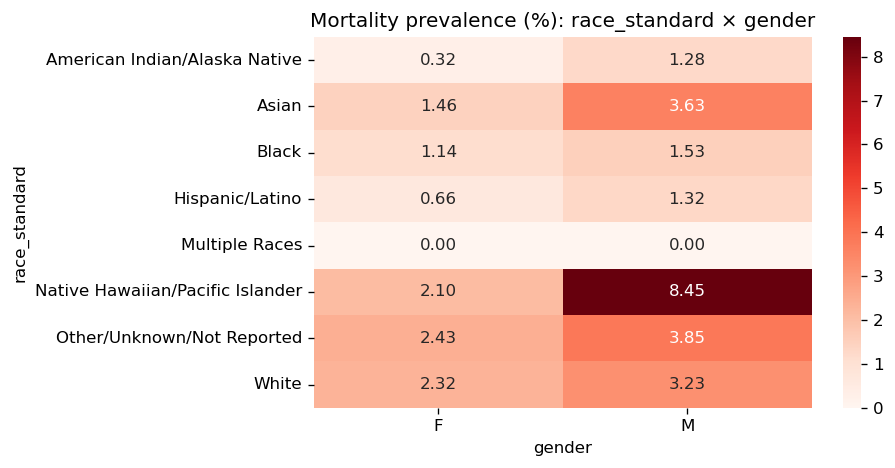

gender                                   F         M
race_standard                                       
American Indian/Alaska Native     0.003205  0.012821
Asian                             0.014554  0.036308
Black                             0.011365  0.015304
Hispanic/Latino                   0.006578  0.013193
Multiple Races                    0.000000  0.000000
Native Hawaiian/Pacific Islander  0.020979  0.084507
Other/Unknown/Not Reported        0.024324  0.038531
White                             0.023234  0.032276

[saved table] dataset/ed/finals/tables_Sep/step1\tables\12_table_intersection_prevalence_race_standard_by_gender.csv


In [16]:
# ===== Cell 6: intersection heatmap (mortality prevalence) ===========

def plot_intersection_heatmap(df,
                              row_col="race_standard",
                              col_col="gender",
                              y_col="died_within_30_days",
                              save_prefix="intersection_heatmap"):
    """
    Heatmap of mortality prevalence (mean of 0/1 outcome) by <row_col> × <col_col>.
    Each cell = 100 * mean(died_within_30_days) for that subgroup, i.e., % who died.
    """
    if row_col not in df.columns or col_col not in df.columns:
        print(f"[skip] missing {row_col} or {col_col}")
        return None

    # prevalence pivot (0..1)
    prev = pd.crosstab(df[row_col], df[col_col], values=df[y_col], aggfunc="mean")

    # ---- plot ----
    plt.figure(figsize=(8,4))
    sns.heatmap(prev * 100, annot=True, fmt=".2f", cmap="Reds")
    plt.title(f"Mortality prevalence (%): {row_col} × {col_col}")
    plt.ylabel(row_col)
    plt.xlabel(col_col)
    plt.tight_layout()
    # save BEFORE show (to avoid empty images)
    savefig_numbered(f"{save_prefix}_{row_col}_by_{col_col}")
    plt.show()
    plt.close()

    return prev

print("\n=== INTERSECTION heatmap (gender × race_standard) ===")
intersection_prev = plot_intersection_heatmap(df_clean, row_col="race_standard", col_col="gender")

# show table in notebook
if intersection_prev is not None:
    display(intersection_prev)
    # numbered save with a descriptive name
    save_table_numbered(intersection_prev, "intersection_prevalence_race_standard_by_gender", index=True)


In [17]:
df_clean.columns 

Index(['subject_id', 'stay_id', 'intime', 'outtime', 'gender', 'race',
       'chiefcomplaint', 'anchor_age', 'anchor_year', 'anchor_year_group',
       'dod', 'dead_in_days', 'died_within_30_days', 'race_standard',
       'age_group', 'unique_visit_id', 'terms', 'terms_new', 'indiv_symptom',
       'counter', 'unique_ids_exploded', 'expanded_symptoms',
       'expanded_symptoms_new', 'counter_new', 'unique_ids_exploded_new',
       'snomed', 'is_male', 'ed_age', 'symptom', 'mu', 'sigma',
       'mortality_prob', 'mortality_percent'],
      dtype='object')


=== Top 20 Most Common Symptoms (with prevalence & SMR) ===


symptom                              expanded_symptoms_new      n  \
17    21522001.0                                     abdominal pain  38663   
24    29857009.0                                         chest pain  28940   
89   267036007.0                                            dyspnea  21527   
19    25064002.0                                           headache  14440   
15    16932000.0                                nausea and vomiting  14246   
112  386661006.0                                              fever  12918   
74   161891005.0                                           backache  10342   
116  404640003.0                                          dizziness   9889   
41    62315008.0                                           diarrhea   8380   
37    49727002.0                                              cough   7877   
93   271594007.0                                            syncope   5619   
126  422587007.0                                             nausea   5052   
92   267102003.0                                        sore throat   4465   
125  422400008.0                                           vomiting   4205   
98   277130004.0  seizure undetermined whether focal or generalized   3867   
95   271807003.0                                           eruption   3671   
36    49650001.0                                            dysuria   3345   
108  366979004.0                                     depressed mood   2506   
55    80394007.0                                      hyperglycemia   2382   
30    45007003.0                                        hypotension   2335   

     deaths  prevalence  expected_deaths       SMR             bias_flag  
17      655    0.016941       858.771974  0.762717   Lower than expected  
24      304    0.010504       642.807360  0.472926   Lower than expected  
89     1192    0.055372       478.151832  2.492932  Higher than expected  
19       65    0.004501       320.737328  0.202658   Lower than expected  
15      252    0.017689       316.428253  0.796389   Lower than expected  
112     302    0.023378       286.931081  1.052518            ≈ Expected  
74       99    0.009573       229.713674  0.430971   Lower than expected  
116      68    0.006876       219.651762  0.309581   Lower than expected  
41      105    0.012530       186.134267  0.564109   Lower than expected  
37      127    0.016123       174.961768  0.725873   Lower than expected  
93       71    0.012636       124.807690  0.568875   Lower than expected  
126      74    0.014648       112.213641  0.659456   Lower than expected  
92        5    0.001120        99.175358  0.050416   Lower than expected  
125      82    0.019501        93.400309  0.877941   Lower than expected  
98       75    0.019395        85.892746  0.873182   Lower than expected  
95        9    0.002452        81.539247  0.110376   Lower than expected  
36       13    0.003886        74.298225  0.174971   Lower than expected  
108      12    0.004789        55.662586  0.215585   Lower than expected  
55       34    0.014274        52.908332  0.642621   Lower than expected  
30      290    0.124197        51.864381  5.591506  Higher than expected

[saved table] dataset/ed/finals/tables_Sep/step1\tables\13_table_symptoms_top20_most_common_with_rate_smr.csv


C:\Users\mitra\AppData\Local\Temp\ipykernel_50136\3724655826.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.xticks(rotation=45, ha="right"); plt.tight_layout()


[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\15_plot_symptoms_top20_most_common_counts.png


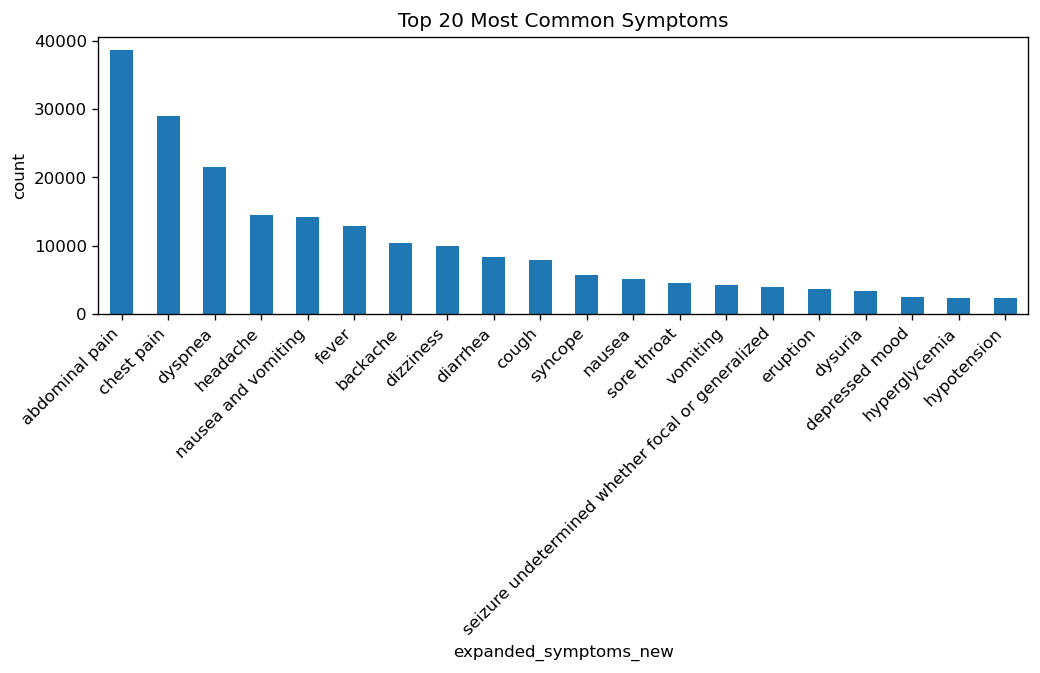

In [21]:
# ===== Cell 7A: Top 20 Most Common Symptoms (with prevalence & SMR) =====

def top20_common_symptoms(df,
                          code_col="symptom",
                          name_col="expanded_symptoms_new",
                          y_col="died_within_30_days",
                          top_n=20,
                          flag_low=0.9, flag_high=1.1):
    # total & deaths by (code, name)
    grp = df.groupby([code_col, name_col], dropna=False)
    t = grp.agg(
        n=("subject_id", "count"),
        deaths=(y_col, "sum")
    ).reset_index()

    # add prevalence, expected_deaths, SMR, bias_flag
    overall_prev = df[y_col].mean()
    t["prevalence"] = t["deaths"] / t["n"]
    t["expected_deaths"] = t["n"] * overall_prev
    t["SMR"] = t["deaths"] / t["expected_deaths"]

    def _flag(smr):
        if pd.isna(smr): return "NA"
        if smr > flag_high: return "Higher than expected"
        if smr < flag_low: return "Lower than expected"
        return "≈ Expected"
    t["bias_flag"] = t["SMR"].apply(_flag)

    # order by most common
    t = t.sort_values("n", ascending=False).head(top_n)

    # show + save table
    print(f"\n=== Top {top_n} Most Common Symptoms (with prevalence & SMR) ===")
    display(t)
    save_table_numbered(t, f"symptoms_top{top_n}_most_common_with_rate_smr", index=False)

    # plot counts (save BEFORE show)
    # (short labels if very long names show up)
    label_col = name_col
    ax = t.set_index(label_col)["n"].plot(kind="bar", figsize=(10,3),
                                          title=f"Top {top_n} Most Common Symptoms")
    ax.set_ylabel("count")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    savefig_numbered(f"symptoms_top{top_n}_most_common_counts")
    plt.show(); plt.close()

    return t

common_symptoms_tbl = top20_common_symptoms(df_clean)



=== Top 20 Deadliest Symptoms by Death Count (with prevalence & SMR) ===


symptom                              expanded_symptoms_new  deaths  \
44  267036007.0                                            dyspnea    1192   
7    21522001.0                                     abdominal pain     655   
12   29857009.0                                         chest pain     304   
60  410429000.0                                     cardiac arrest     302   
56  386661006.0                                              fever     302   
14   45007003.0                                        hypotension     290   
5    16932000.0                                nausea and vomiting     252   
6    18165001.0                                           jaundice     147   
40  230690007.0                           cerebrovascular accident     129   
20   54840006.0                                  failure to thrive     127   
18   49727002.0                                              cough     127   
21   62315008.0                                           diarrhea     105   
36  161891005.0                                           backache      99   
2     3424008.0                                        tachycardia      93   
63  422400008.0                                           vomiting      82   
49  277130004.0  seizure undetermined whether focal or generalized      75   
64  422587007.0                                             nausea      74   
47  271594007.0                                            syncope      71   
25   74474003.0                        gastrointestinal hemorrhage      69   
59  404640003.0                                          dizziness      68   

        n  prevalence  expected_deaths        SMR             bias_flag  
44  21527    0.055372       478.151832   2.492932  Higher than expected  
7   38663    0.016941       858.771974   0.762717   Lower than expected  
12  28940    0.010504       642.807360   0.472926   Lower than expected  
60    430    0.702326         9.551042  31.619586  Higher than expected  
56  12918    0.023378       286.931081   1.052518            ≈ Expected  
14   2335    0.124197        51.864381   5.591506  Higher than expected  
5   14246    0.017689       316.428253   0.796389   Lower than expected  
6     905    0.162431        20.101612   7.312846  Higher than expected  
40    785    0.164331        17.436205   7.398399  Higher than expected  
20    797    0.159348        17.702746   7.174028  Higher than expected  
18   7877    0.016123       174.961768   0.725873   Lower than expected  
21   8380    0.012530       186.134267   0.564109   Lower than expected  
36  10342    0.009573       229.713674   0.430971   Lower than expected  
2    2072    0.044884        46.022697   2.020742  Higher than expected  
63   4205    0.019501        93.400309   0.877941   Lower than expected  
49   3867    0.019395        85.892746   0.873182   Lower than expected  
64   5052    0.014648       112.213641   0.659456   Lower than expected  
47   5619    0.012636       124.807690   0.568875   Lower than expected  
25    689    0.100145        15.303879   4.508661  Higher than expected  
59   9889    0.006876       219.651762   0.309581   Lower than expected

[saved table] dataset/ed/finals/tables_Sep/step1\tables\14_table_symptoms_top20_deadliest_by_deaths_with_rate_smr.csv


C:\Users\mitra\AppData\Local\Temp\ipykernel_50136\3113407324.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.xticks(rotation=45, ha="right"); plt.tight_layout()


[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\16_plot_symptoms_top20_deadliest_by_deaths.png


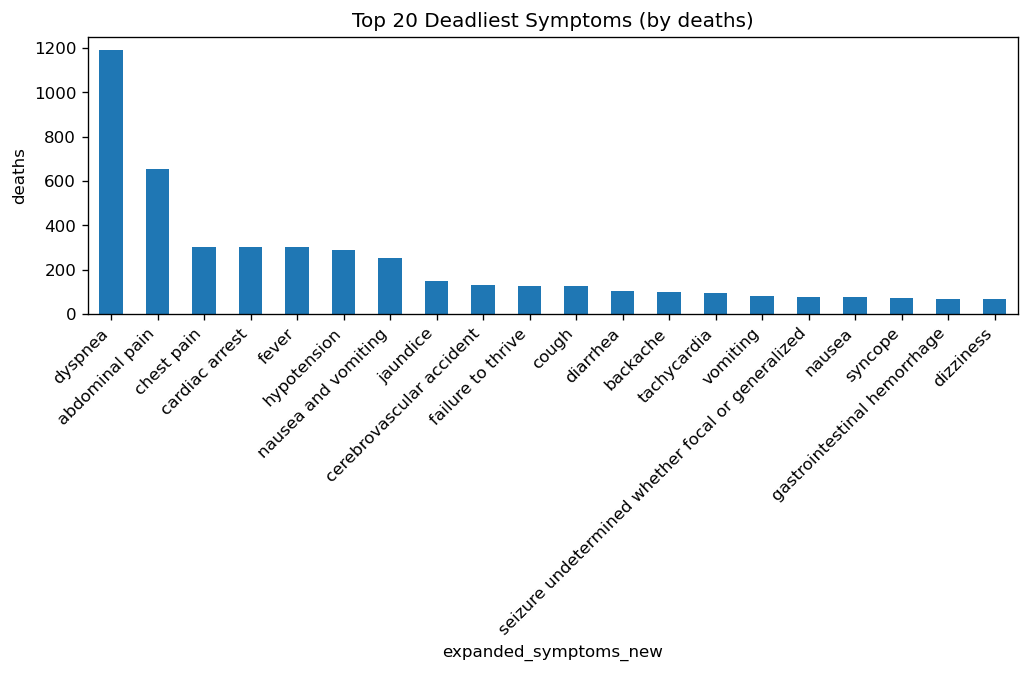

In [23]:
# ===== Cell 7B: Top 20 Deadliest Symptoms by DEATH COUNT (with prevalence & SMR) =====

def top20_deadliest_symptoms_by_deaths(df,
                                       code_col="symptom",
                                       name_col="expanded_symptoms_new",
                                       y_col="died_within_30_days",
                                       top_n=20,
                                       flag_low=0.9, flag_high=1.1):
    # deaths among those who died
    dead = df[df[y_col] == 1]
    by_death = (dead.groupby([code_col, name_col], dropna=False)
                    .agg(deaths=("subject_id","count"))
                    .reset_index())

    # total n from full df (to compute prevalence & expected/SMR)
    totals = (df.groupby([code_col, name_col], dropna=False)
                .size().reset_index(name="n"))

    t = by_death.merge(totals, on=[code_col, name_col], how="left")

    # add prevalence, expected_deaths, SMR, bias_flag
    overall_prev = df[y_col].mean()
    t["prevalence"] = t["deaths"] / t["n"]
    t["expected_deaths"] = t["n"] * overall_prev
    t["SMR"] = t["deaths"] / t["expected_deaths"]

    def _flag(smr):
        if pd.isna(smr): return "NA"
        if smr > flag_high: return "Higher than expected"
        if smr < flag_low: return "Lower than expected"
        return "≈ Expected"
    t["bias_flag"] = t["SMR"].apply(_flag)

    # order by NUMBER OF DEATHS (this is your requested definition)
    t = t.sort_values("deaths", ascending=False).head(top_n)

    # show + save table
    print(f"\n=== Top {top_n} Deadliest Symptoms by Death Count (with prevalence & SMR) ===")
    display(t)
    save_table_numbered(t, f"symptoms_top{top_n}_deadliest_by_deaths_with_rate_smr", index=False)

    # plot deaths (save BEFORE show)
    label_col = name_col
    ax = t.set_index(label_col)["deaths"].plot(kind="bar", figsize=(10,3),
                                               title=f"Top {top_n} Deadliest Symptoms (by deaths)")
    ax.set_ylabel("deaths")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    savefig_numbered(f"symptoms_top{top_n}_deadliest_by_deaths")
    plt.show(); plt.close()

    return t

deadliest_symptoms_tbl = top20_deadliest_symptoms_by_deaths(df_clean)



=== Top 20 Deadliest Symptoms by Prevalence (n >= 100) ===


symptom             expanded_symptoms_new      n  deaths  prevalence  \
117  410429000.0                    cardiac arrest    430     302    0.702326   
64    91302008.0                            sepsis    134      34    0.253731   
80   230690007.0          cerebrovascular accident    785     129    0.164331   
16    18165001.0                          jaundice    905     147    0.162431   
39    54840006.0                 failure to thrive    797     127    0.159348   
30    45007003.0                       hypotension   2335     290    0.124197   
50    74474003.0       gastrointestinal hemorrhage    689      69    0.100145   
44    66857006.0                        hemoptysis    781      44    0.056338   
89   267036007.0                           dyspnea  21527    1192    0.055372   
9      8765009.0                       hematemesis    818      40    0.048900   
1      1912002.0                              fall    545      26    0.047706   
4      3424008.0                       tachycardia   2072      93    0.044884   
109  367391008.0                           malaise    276      12    0.043478   
58    84229001.0                           fatigue   1246      46    0.036918   
45    68566005.0  urinary tract infectious disease    407      14    0.034398   
35    48867003.0                       bradycardia    829      28    0.033776   
18    22253000.0                              pain    547      18    0.032907   
82   237633009.0    hypoglycemic state in diabetes   1036      30    0.028958   
79   230145002.0              difficulty breathing    267       7    0.026217   
105  288939007.0             difficulty swallowing    537      13    0.024209   

     expected_deaths        SMR             bias_flag  
117         9.551042  31.619586  Higher than expected  
64          2.976371  11.423306  Higher than expected  
80         17.436205   7.398399  Higher than expected  
16         20.101612   7.312846  Higher than expected  
39         17.702746   7.174028  Higher than expected  
30         51.864381   5.591506  Higher than expected  
50         15.303879   4.508661  Higher than expected  
44         17.347358   2.536409  Higher than expected  
89        478.151832   2.492932  Higher than expected  
9          18.169192   2.201529  Higher than expected  
1          12.105391   2.147803  Higher than expected  
4          46.022697   2.020742  Higher than expected  
109         6.130436   1.957446  Higher than expected  
58         27.675811   1.662101  Higher than expected  
45          9.040173   1.548643  Higher than expected  
35         18.413521   1.520622  Higher than expected  
18         12.149814   1.481504  Higher than expected  
82         23.011348   1.303705  Higher than expected  
79          5.930531   1.180333  Higher than expected  
105        11.927697   1.089900            ≈ Expected

[saved table] dataset/ed/finals/tables_Sep/step1\tables\15_table_symptoms_top20_deadliest_by_rate_n_ge_100.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\17_plot_symptoms_top20_deadliest_by_rate_n_ge_100.png


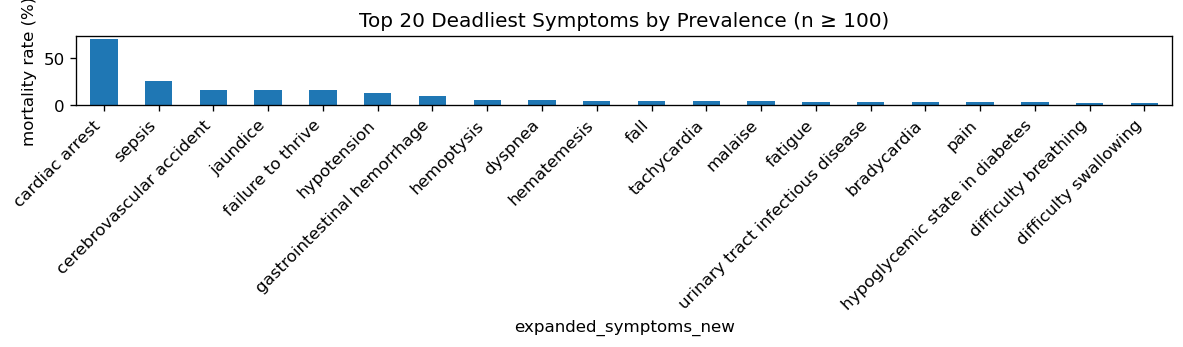

In [25]:
# ===== Cell 8: Top 20 Deadliest Symptoms by PREVALENCE (rate) =====

def top20_deadliest_symptoms_by_rate(df,
                                     code_col="symptom",
                                     name_col="expanded_symptoms_new",
                                     y_col="died_within_30_days",
                                     top_n=20,
                                     min_n=100,            # filter for stability
                                     flag_low=0.9, flag_high=1.1):
    """
    Rank symptoms by mortality prevalence (deaths / n), after filtering to n >= min_n.
    Adds prevalence, expected_deaths, SMR, bias_flag.
    Saves the table and the bar plot using numbered helpers.
    """
    # totals by symptom (code+name)
    grp = df.groupby([code_col, name_col], dropna=False)
    t = grp.agg(
        n=("subject_id", "count"),
        deaths=(y_col, "sum")
    ).reset_index()

    # prevalence & SMR context
    overall_prev = df[y_col].mean()
    t["prevalence"] = t["deaths"] / t["n"]
    t["expected_deaths"] = t["n"] * overall_prev
    t["SMR"] = t["deaths"] / t["expected_deaths"]

    def _flag(smr):
        if pd.isna(smr): return "NA"
        if smr > flag_high: return "Higher than expected"
        if smr < flag_low: return "Lower than expected"
        return "≈ Expected"
    t["bias_flag"] = t["SMR"].apply(_flag)

    # filter for stability and sort by prevalence
    t = t[t["n"] >= min_n].sort_values("prevalence", ascending=False).head(top_n)

    # show + save table
    print(f"\n=== Top {top_n} Deadliest Symptoms by Prevalence (n >= {min_n}) ===")
    display(t)
    save_table_numbered(t, f"symptoms_top{top_n}_deadliest_by_rate_n_ge_{min_n}", index=False)

    # plot prevalence (%) — save BEFORE show
    ax = (t.set_index(name_col)["prevalence"] * 100).plot(
        kind="bar", figsize=(10,3),
        title=f"Top {top_n} Deadliest Symptoms by Prevalence (n ≥ {min_n})"
    )
    ax.set_ylabel("mortality rate (%)")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    savefig_numbered(f"symptoms_top{top_n}_deadliest_by_rate_n_ge_{min_n}")
    plt.show(); plt.close()

    return t

# run
deadliest_by_rate_tbl = top20_deadliest_symptoms_by_rate(df_clean, min_n=100)


In [27]:
# ===== Cell 00: print the formulas we use for Over-representation ratio & SMR in the following cells   ======================================

formulas = r"""
Formulas used in the next cells
--------------------------------

1) Over-representation ratio  (for a symptom s and group g)
   base_share_g   = N_g / N
   symptom_share  = N_{s,g} / N_s
   over_rep_{s,g} = symptom_share / base_share_g

   Where:
     N               = total patients in the dataset
     N_g             = total patients in group g (e.g., Female, White, etc.)
     N_s             = total patients with symptom s
     N_{s,g}         = patients with symptom s who are in group g

   Interpretation:
     = 1.0 → group appears as expected in symptom s
     > 1.0 → over-represented
     < 1.0 → under-represented

2) SMR (Standardized Mortality Ratio) for a symptom s
   overall_prev    = total_deaths / N
   expected_deaths = n_s * overall_prev
   SMR_s           = observed_deaths_s / expected_deaths

   Where:
     n_s                = total patients with symptom s
     observed_deaths_s  = deaths among patients with symptom s

   Interpretation:
     = 1.0 → deaths as expected given dataset-wide prevalence
     > 1.0 → more deaths than expected
     < 1.0 → fewer deaths than expected
"""
print(formulas)


Formulas used in the next cells
--------------------------------

1) Over-representation ratio  (for a symptom s and group g)
   base_share_g   = N_g / N
   symptom_share  = N_{s,g} / N_s
   over_rep_{s,g} = symptom_share / base_share_g

   Where:
     N               = total patients in the dataset
     N_g             = total patients in group g (e.g., Female, White, etc.)
     N_s             = total patients with symptom s
     N_{s,g}         = patients with symptom s who are in group g

   Interpretation:
     = 1.0 → group appears as expected in symptom s
     > 1.0 → over-represented
     < 1.0 → under-represented

2) SMR (Standardized Mortality Ratio) for a symptom s
   overall_prev    = total_deaths / N
   expected_deaths = n_s * overall_prev
   SMR_s           = observed_deaths_s / expected_deaths

   Where:
     n_s                = total patients with symptom s
     observed_deaths_s  = deaths among patients with symptom s

   Interpretation:
     = 1.0 → deaths as expect

symptom                              expanded_symptoms_new        F  \
0    21522001.0                                     abdominal pain  24125.0   
1    29857009.0                                         chest pain  14953.0   
2   267036007.0                                            dyspnea  11913.0   
3    25064002.0                                           headache  10057.0   
4    16932000.0                                nausea and vomiting   9253.0   
5   386661006.0                                              fever   6383.0   
6   161891005.0                                           backache   5857.0   
7   404640003.0                                          dizziness   6100.0   
8    62315008.0                                           diarrhea   5316.0   
9    49727002.0                                              cough   4680.0   
10  271594007.0                                            syncope   3133.0   
11  422587007.0                                             nausea   3540.0   
12  267102003.0                                        sore throat   2794.0   
13  422400008.0                                           vomiting   2571.0   
14  277130004.0  seizure undetermined whether focal or generalized   1902.0   
15  271807003.0                                           eruption   2175.0   
16   49650001.0                                            dysuria   2288.0   
17  366979004.0                                     depressed mood   1282.0   
18   80394007.0                                      hyperglycemia   1247.0   
19   45007003.0                                        hypotension   1072.0   

          M  n_total      n  deaths  prevalence  expected_deaths       SMR  \
0   14538.0  38663.0  38663     655    0.016941       858.771974  0.762717   
1   13987.0  28940.0  28940     304    0.010504       642.807360  0.472926   
2    9614.0  21527.0  21527    1192    0.055372       478.151832  2.492932   
3    4383.0  14440.0  14440      65    0.004501       320.737328  0.202658   
4    4993.0  14246.0  14246     252    0.017689       316.428253  0.796389   
5    6535.0  12918.0  12918     302    0.023378       286.931081  1.052518   
6    4485.0  10342.0  10342      99    0.009573       229.713674  0.430971   
7    3789.0   9889.0   9889      68    0.006876       219.651762  0.309581   
8    3064.0   8380.0   8380     105    0.012530       186.134267  0.564109   
9    3197.0   7877.0   7877     127    0.016123       174.961768  0.725873   
10   2486.0   5619.0   5619      71    0.012636       124.807690  0.568875   
11   1512.0   5052.0   5052      74    0.014648       112.213641  0.659456   
12   1671.0   4465.0   4465       5    0.001120        99.175358  0.050416   
13   1634.0   4205.0   4205      82    0.019501        93.400309  0.877941   
14   1965.0   3867.0   3867      75    0.019395        85.892746  0.873182   
15   1496.0   3671.0   3671       9    0.002452        81.539247  0.110376   
16   1057.0   3345.0   3345      13    0.003886        74.298225  0.174971   
17   1224.0   2506.0   2506      12    0.004789        55.662586  0.215585   
18   1135.0   2382.0   2382      34    0.014274        52.908332  0.642621   
19   1263.0   2335.0   2335     290    0.124197        51.864381  5.591506   

               bias_flag    prev_F    prev_M    over_F    over_M  
0    Lower than expected  0.013098  0.023318  1.065154  0.907848  
1    Lower than expected  0.007423  0.013799  0.882004  1.166890  
2   Higher than expected  0.050449  0.061473  0.944666  1.078263  
3    Lower than expected  0.003381  0.007073  1.188891  0.732838  
4    Lower than expected  0.016211  0.020429  1.108742  0.846199  
5             ≈ Expected  0.017703  0.028921  0.843471  1.221390  
6    Lower than expected  0.007000  0.012932  0.966744  1.047036  
7    Lower than expected  0.004754  0.010293  1.052975  0.925073  
8    Lower than expected  0.010534  0.015992  1.082883  0.882772  
9    Lower than expected  0.014316  0.0

[saved table] dataset/ed/finals/tables_Sep/step1\tables\16_table_top20_symptoms_by_gender.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\18_plot_top20_symptoms_gender_counts.png


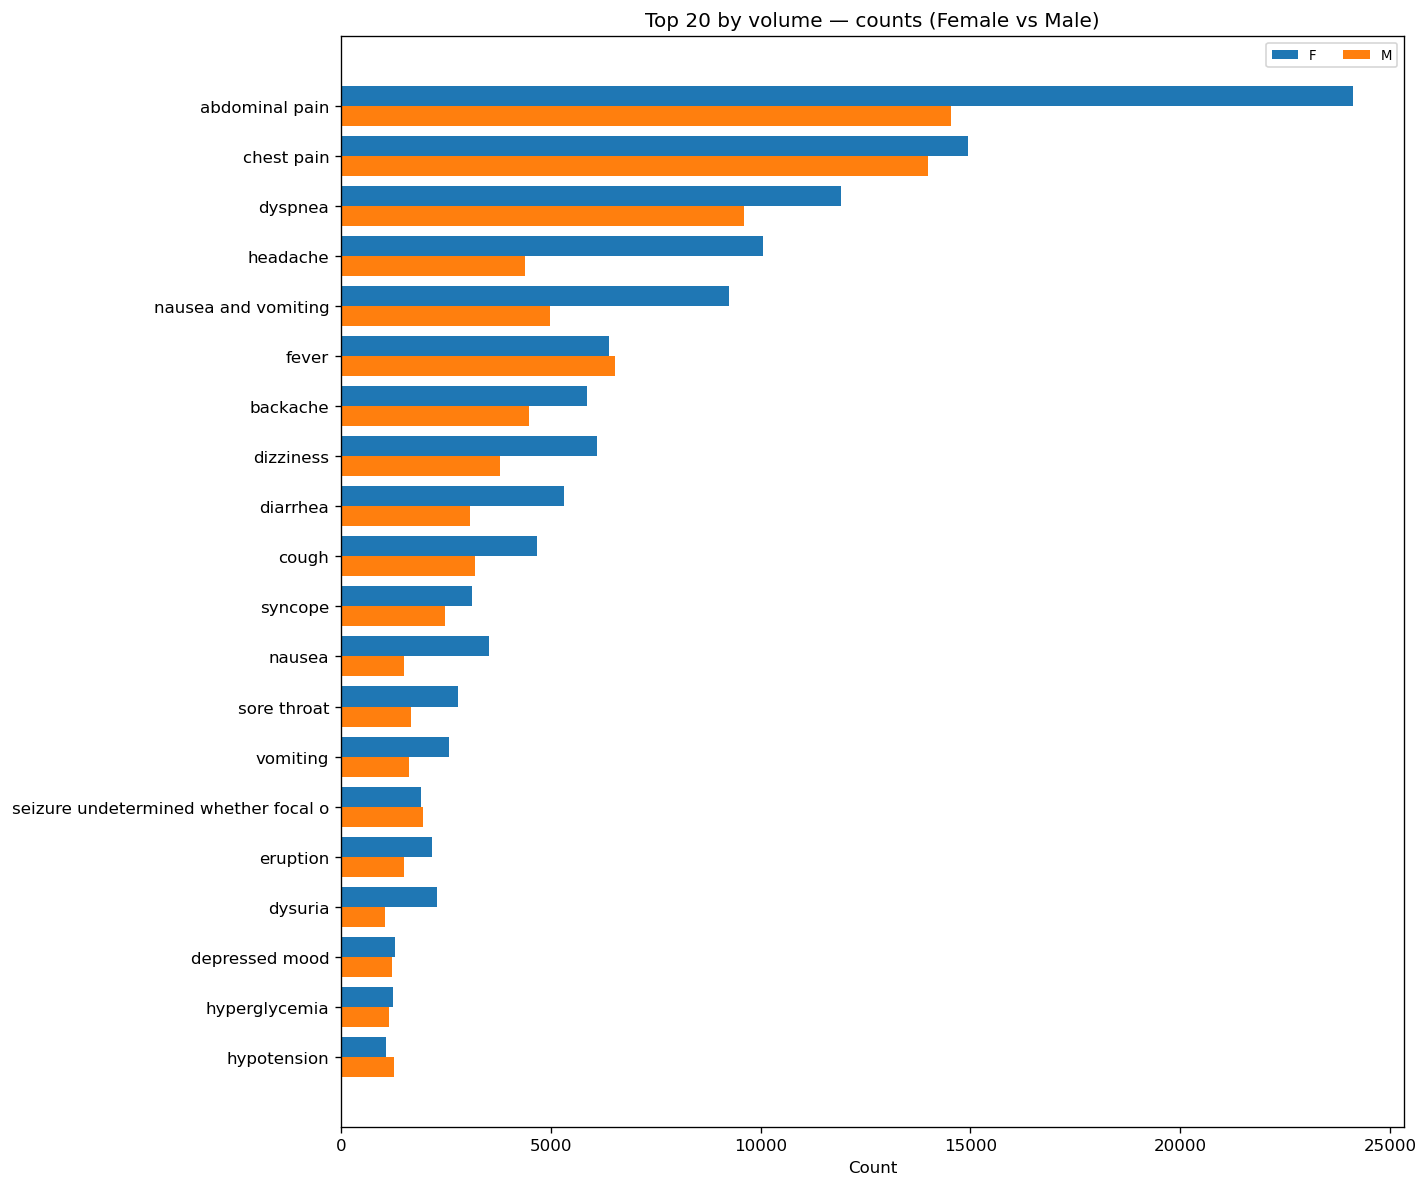

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\19_plot_top20_symptoms_gender_overrep.png


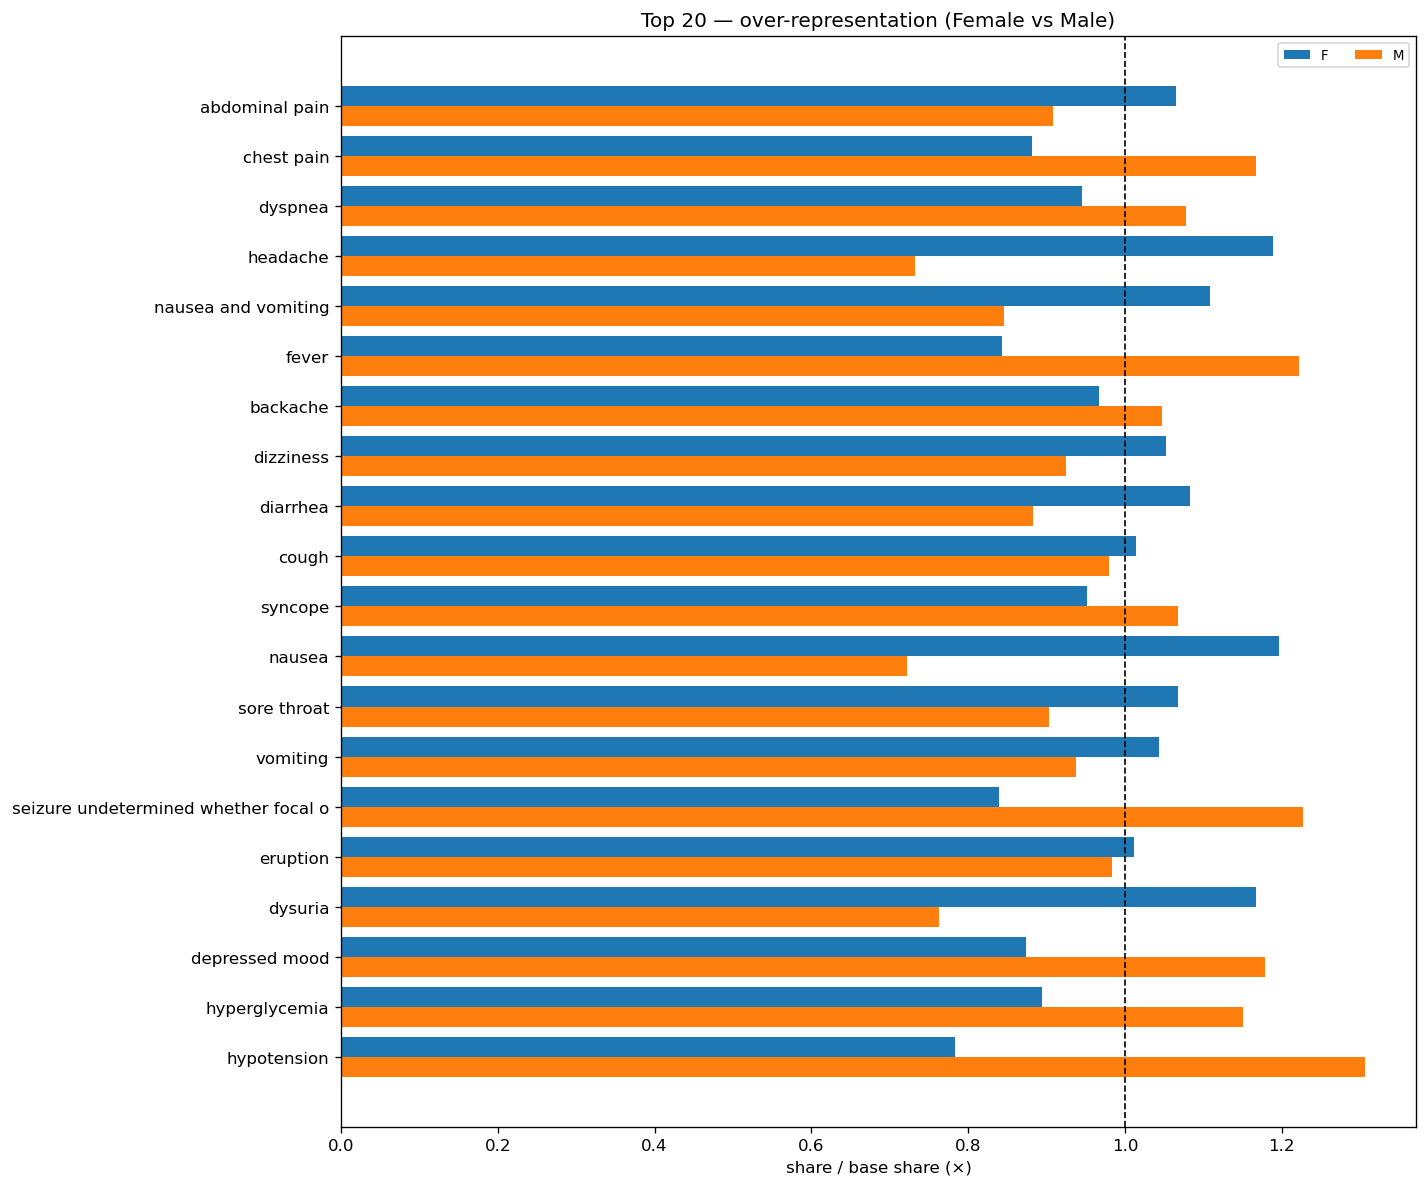

symptom                              expanded_symptoms_new  \
0    21522001.0                                     abdominal pain   
1    29857009.0                                         chest pain   
2   267036007.0                                            dyspnea   
3    25064002.0                                           headache   
4    16932000.0                                nausea and vomiting   
5   386661006.0                                              fever   
6   161891005.0                                           backache   
7   404640003.0                                          dizziness   
8    62315008.0                                           diarrhea   
9    49727002.0                                              cough   
10  271594007.0                                            syncope   
11  422587007.0                                             nausea   
12  267102003.0                                        sore throat   
13  422400008.0                                           vomiting   
14  277130004.0  seizure undetermined whether focal or generalized   
15  271807003.0                                           eruption   
16   49650001.0                                            dysuria   
17  366979004.0                                     depressed mood   
18   80394007.0                                      hyperglycemia   
19   45007003.0                                        hypotension   

    American Indian/Alaska Native   Asian   Black  Hispanic/Latino  \
0                            94.0  1781.0  8220.0           3946.0   
1                            59.0  1000.0  7661.0           3040.0   
2                            47.0   770.0  5121.0           1508.0   
3                            39.0   623.0  3855.0           1778.0   
4                            42.0   647.0  3433.0           1340.0   
5                            34.0   894.0  1918.0            963.0   
6                            19.0   352.0  2546.0           1128.0   
7                            15.0   612.0  2279.0           1024.0   
8                            26.0   329.0  1775.0            809.0   
9                            19.0   390.0  2352.0            927.0   
10                           12.0   261.0   977.0            306.0   
11                           11.0   213.0   986.0            481.0   
12                            8.0   269.0  1311.0            513.0   
13                           11.0   220.0   912.0            394.0   
14                           10.0    73.0   796.0            206.0   
15                            6.0   339.0   943.0            384.0   
16                           13.0   249.0   780.0            441.0   
17                            6.0    91.0   479.0            185.0   
18                            4.0    37.0   874.0            234.0   
19                            5.0    73.0   375.0             93.0   

    Multiple Races  Native Hawaiian/Pacific Islander  \
0             14.0                              46.0   
1              7.0                              36.0   
2              4.0                              22.0   
3             13.0                              19.0   
4              6.0                              19.0   
5              4.0                              14.0   
6              5.0                              12.0   
7              1.0                               8.0   
8              5.0                               9.0   
9              2.0                               8.0   
10             1.0                               7.0   
11             3.0                               9.0   
12             0.0                               1.0   
13             3.0                               3.0   
14             2.0                               9.0   
15             3.0                               2.0   
16             2.0                               5.0   
17             2.0                               4.0   
18

[saved table] dataset/ed/finals/tables_Sep/step1\tables\17_table_top20_symptoms_by_race_standard.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\20_plot_top20_symptoms_race_counts.png


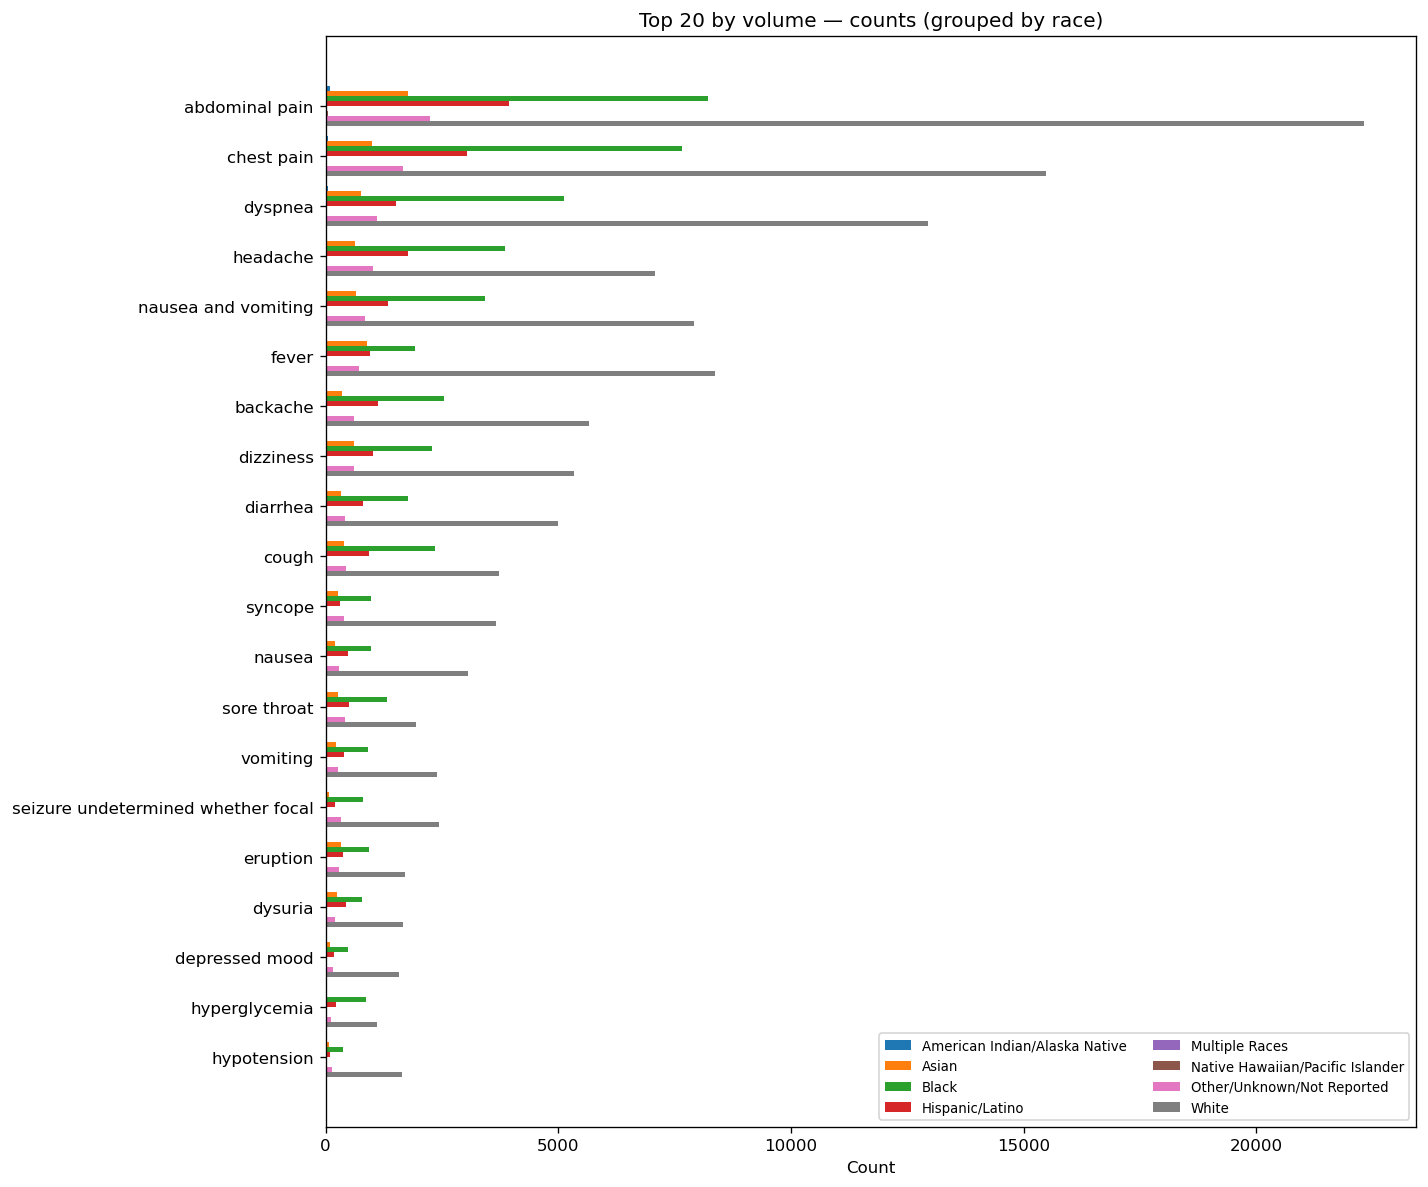

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\21_plot_top20_symptoms_race_overrep.png


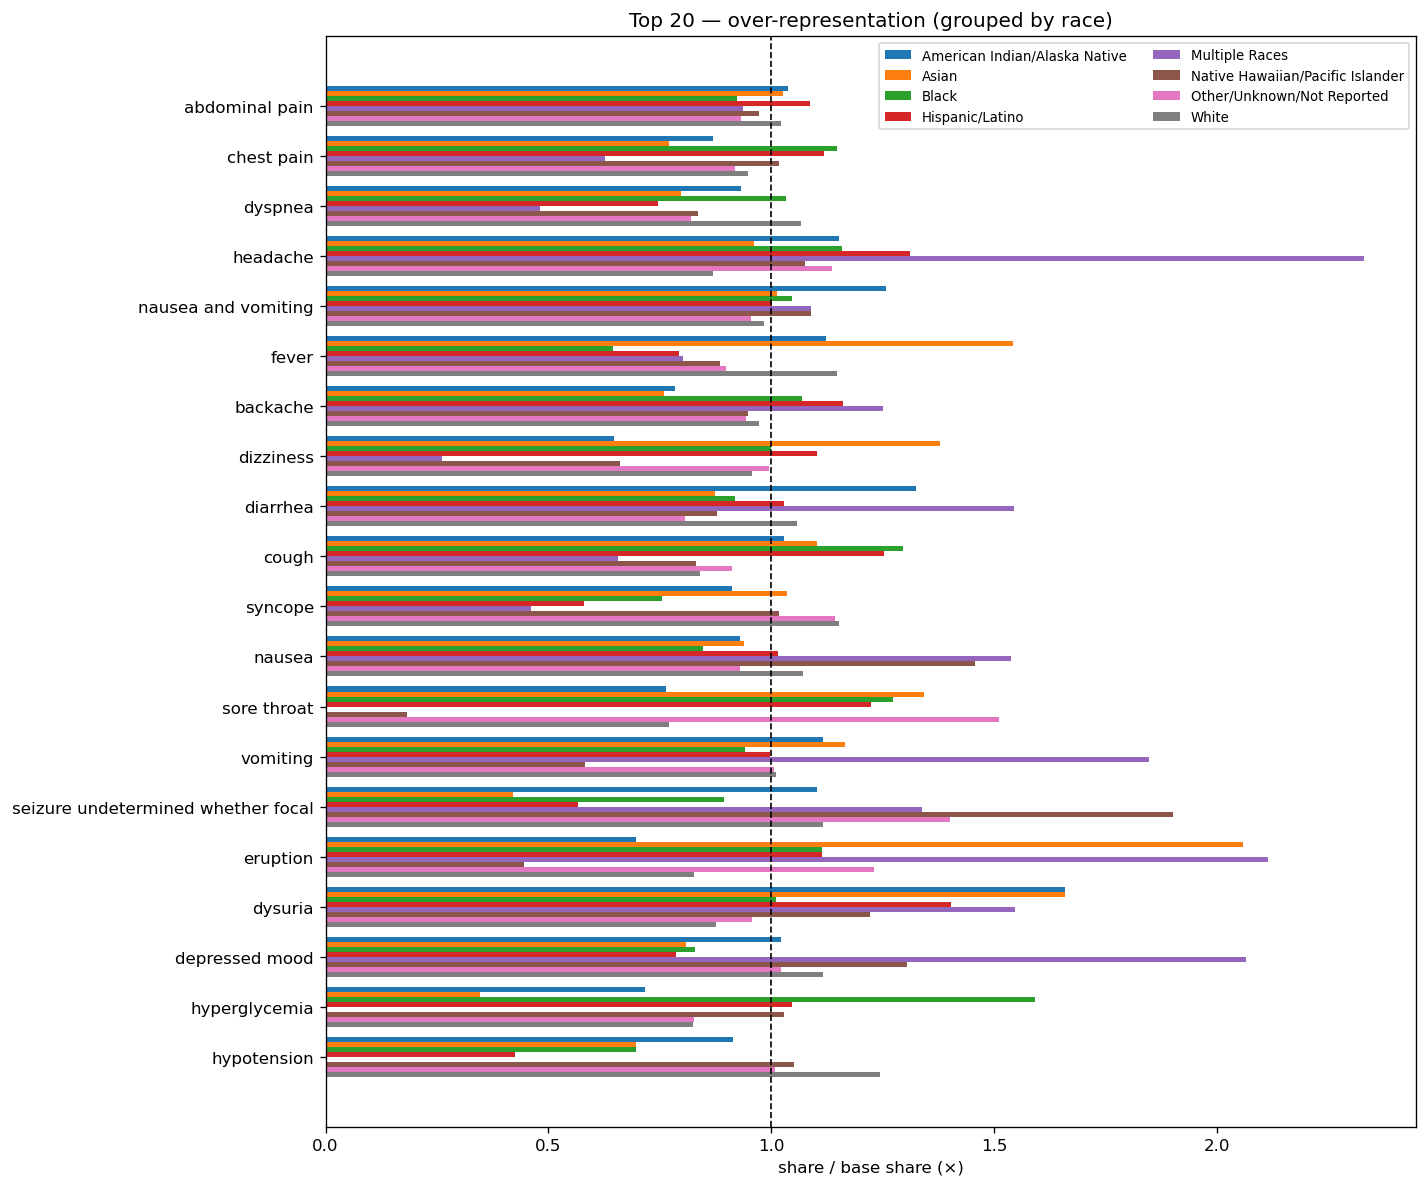

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\22_plot_top20_symptoms_race_overrep_heatmap.png


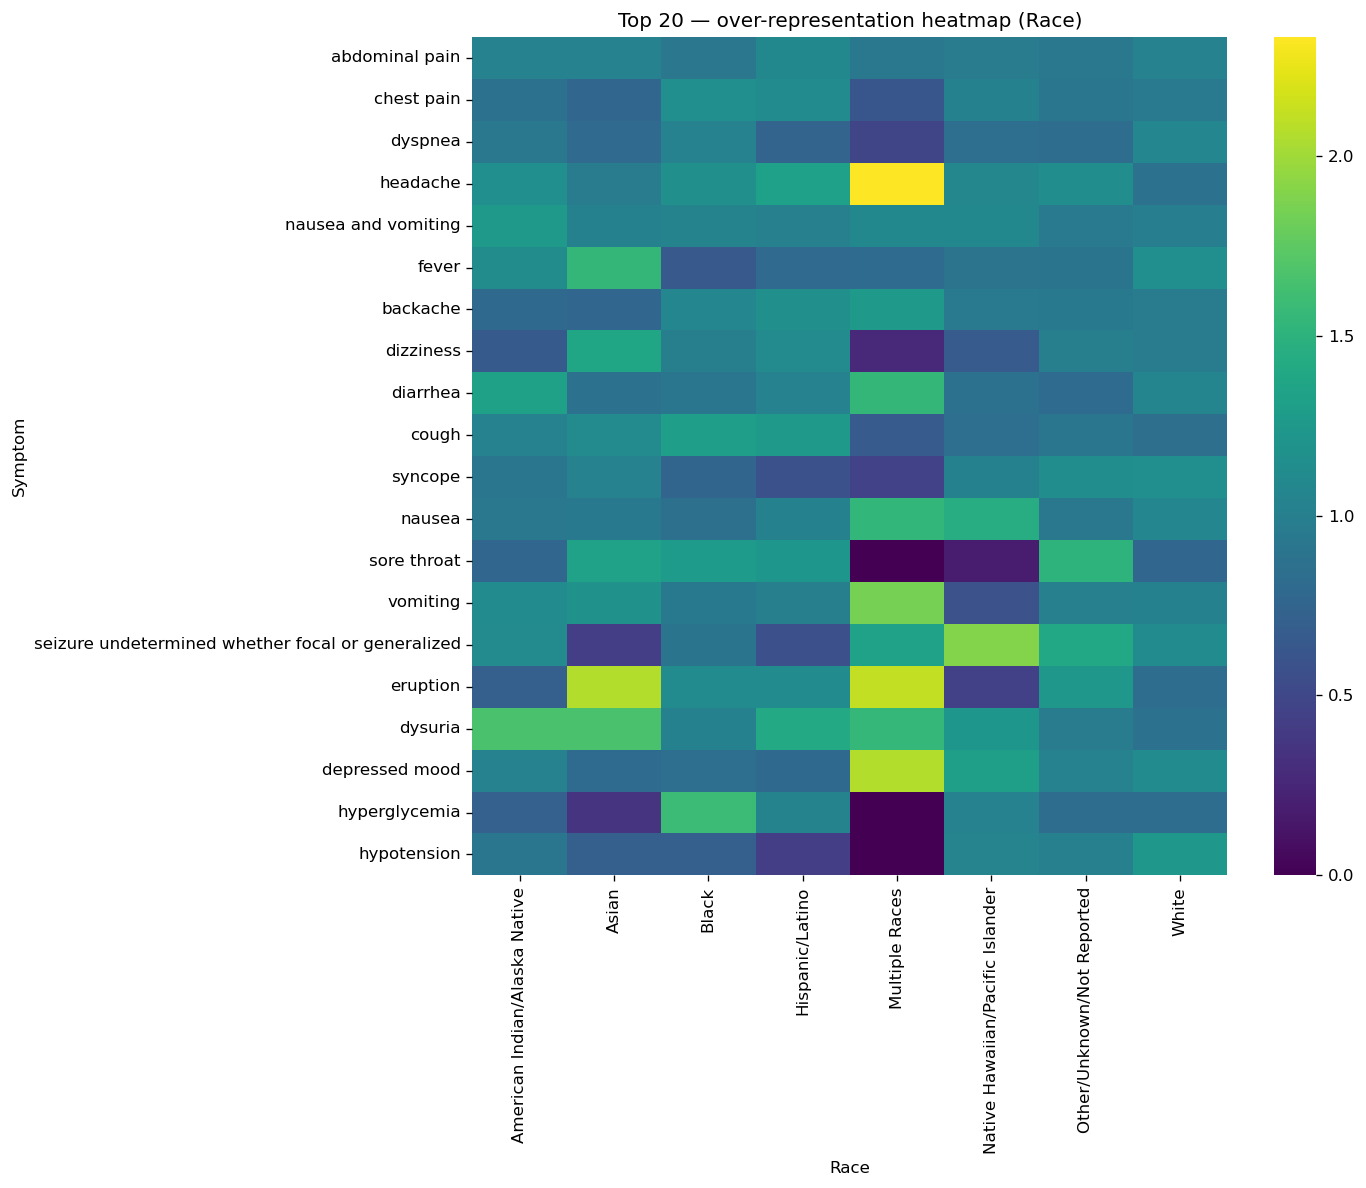

symptom                              expanded_symptoms_new  \
0    21522001.0                                     abdominal pain   
1    29857009.0                                         chest pain   
2   267036007.0                                            dyspnea   
3    25064002.0                                           headache   
4    16932000.0                                nausea and vomiting   
5   386661006.0                                              fever   
6   161891005.0                                           backache   
7   404640003.0                                          dizziness   
8    62315008.0                                           diarrhea   
9    49727002.0                                              cough   
10  271594007.0                                            syncope   
11  422587007.0                                             nausea   
12  267102003.0                                        sore throat   
13  422400008.0                                           vomiting   
14  277130004.0  seizure undetermined whether focal or generalized   
15  271807003.0                                           eruption   
16   49650001.0                                            dysuria   
17  366979004.0                                     depressed mood   
18   80394007.0                                      hyperglycemia   
19   45007003.0                                        hypotension   

    F | American Indian/Alaska Native  F | Asian  F | Black  \
0                                56.0     1072.0     5658.0   
1                                39.0      530.0     4678.0   
2                                30.0      402.0     3317.0   
3                                24.0      409.0     2826.0   
4                                28.0      388.0     2376.0   
5                                 8.0      476.0     1056.0   
6                                 8.0      219.0     1588.0   
7                                12.0      393.0     1621.0   
8                                12.0      189.0     1197.0   
9                                 7.0      237.0     1533.0   
10                                8.0      153.0      605.0   
11                                9.0      150.0      757.0   
12                                3.0      160.0      923.0   
13                                8.0      120.0      606.0   
14                                5.0       41.0      446.0   
15                                5.0      218.0      581.0   
16                                8.0      187.0      530.0   
17                                4.0       68.0      265.0   
18                                1.0       16.0      478.0   
19                                0.0       42.0      187.0   

    F | Hispanic/Latino  F | Multiple Races  \
0                2656.0                10.0   
1                1756.0                 3.0   
2                 898.0                 3.0   
3                1295.0                 4.0   
4                 918.0                 4.0   
5                 524.0                 2.0   
6                 678.0                 4.0   
7                 699.0                 0.0   
8                 553.0                 3.0   
9                 586.0                 2.0   
10                198.0                 1.0   
11                363.0                 1.0   
12                353.0                 0.0   
13                258.0                 2.0   
14                105.0                 2.0   
15                206.0                 2.0   
16                309.0                 2.0   
17                 86.0                 2.0   
18                129.0                 0.0   
19                 36.0                 0.0   

    F | Native Hawaiian/Pacific Islander  F | Other/Unknown/Not Reported  \
0                                   26.0                          1424.0   
1                                   20.0                           802.0 

[saved table] dataset/ed/finals/tables_Sep/step1\tables\18_table_top20_symptoms_by_gender_race.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\23_plot_top20_symptoms_gender_race_counts.png


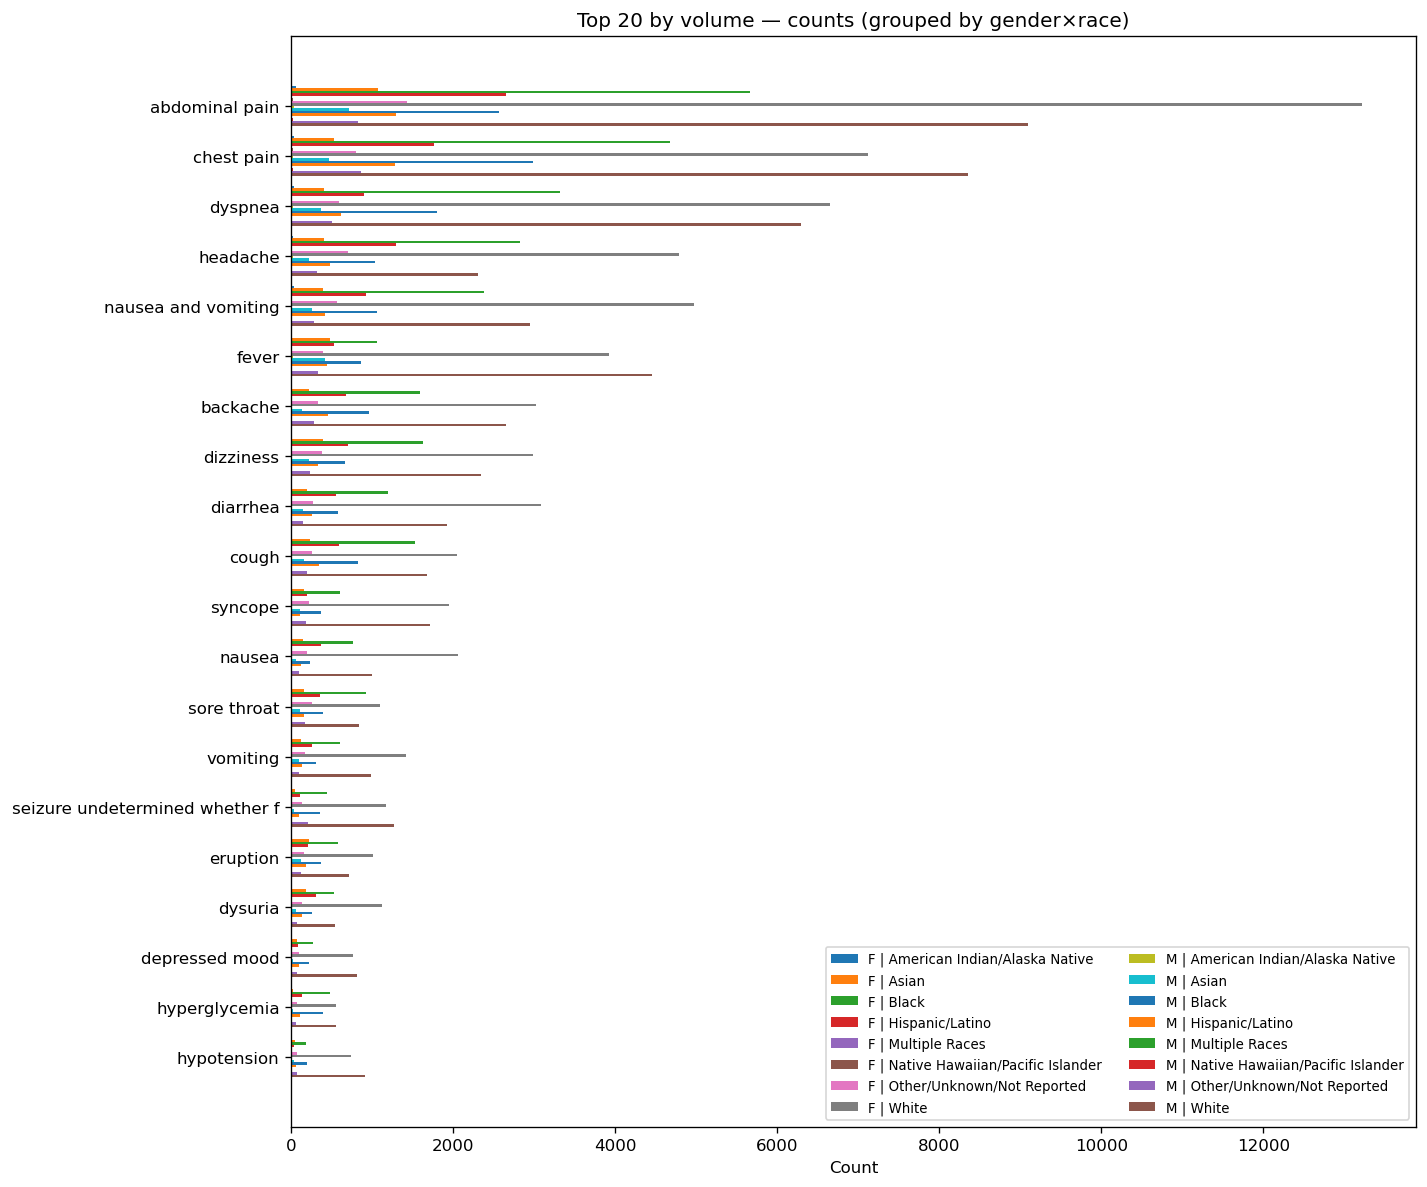

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\24_plot_top20_symptoms_gender_race_overrep.png


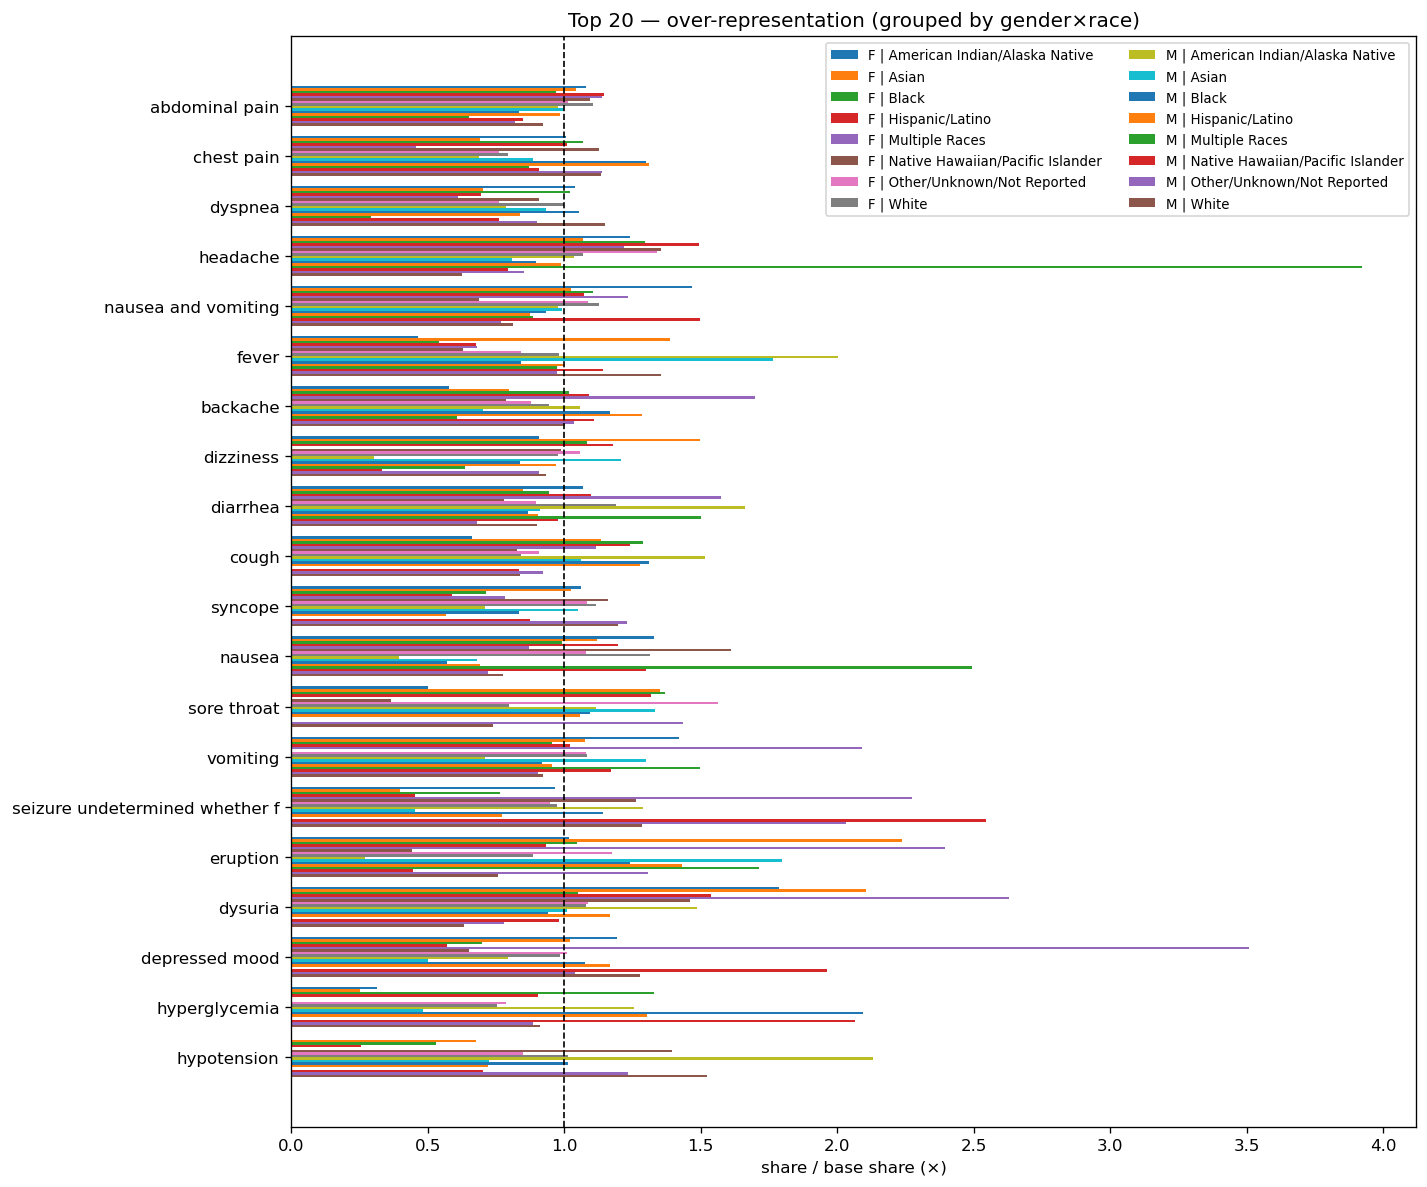

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\25_plot_top20_symptoms_gender_race_overrep_heatmap.png


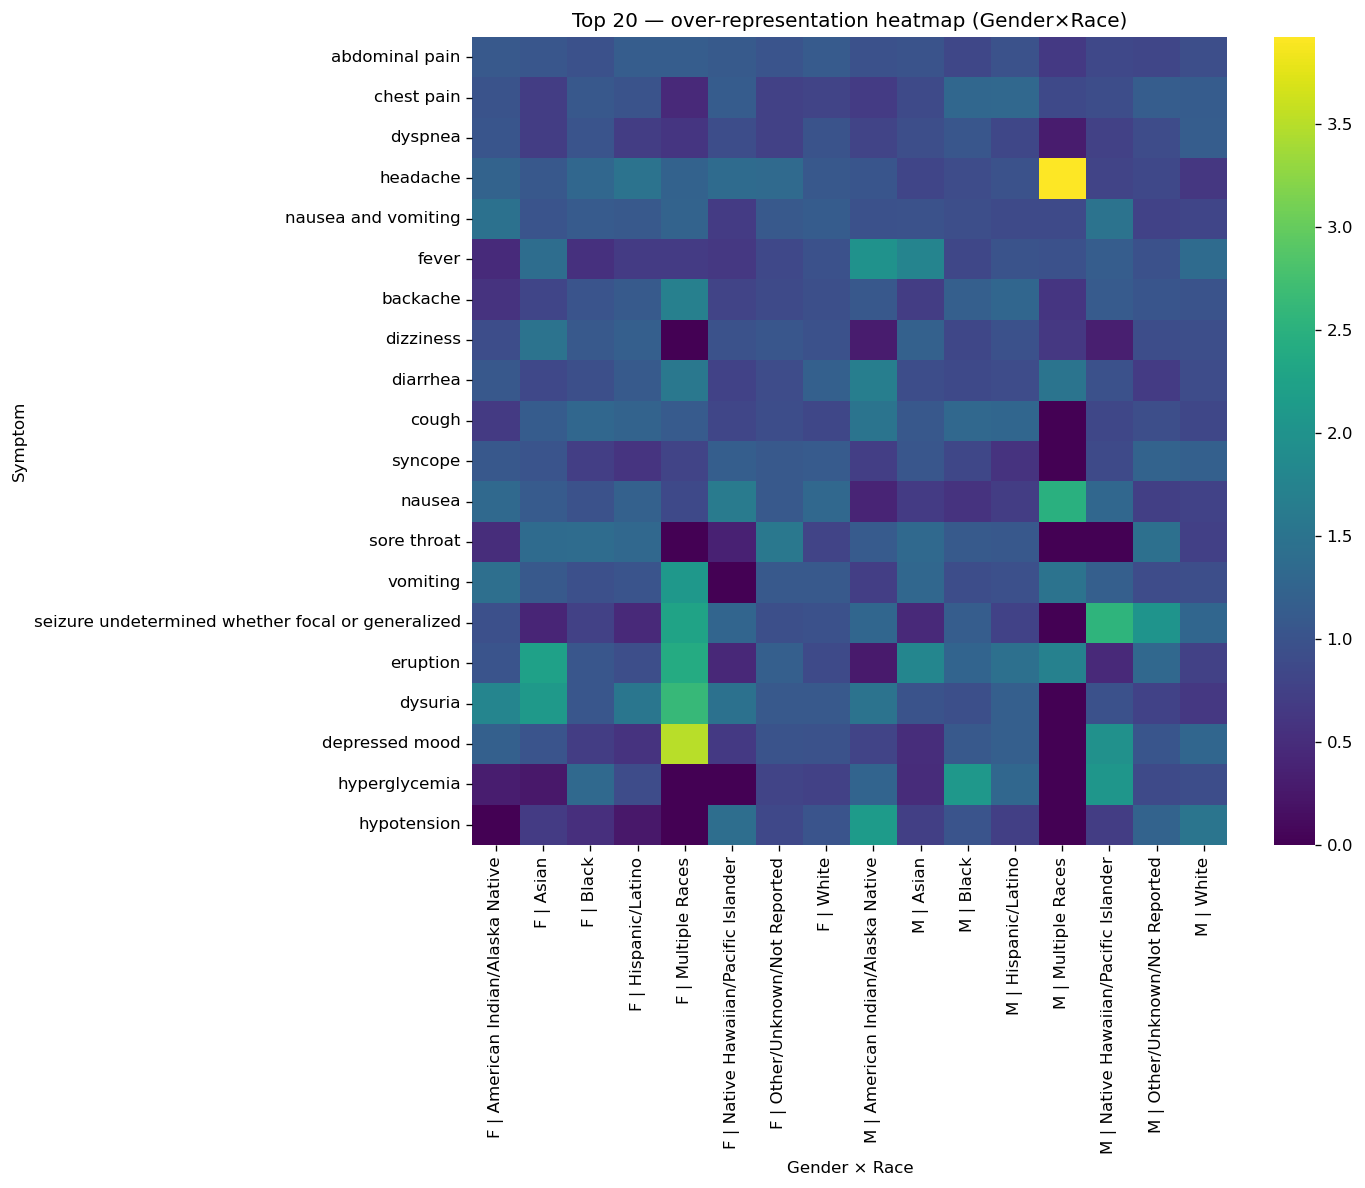

In [29]:
# ===== Cell 9: Top-20 symptoms by Gender / Race / Gender×Race =================
# Requires: df_clean, save_table_numbered, savefig_numbered already defined.

# ---------- tiny helpers ----------

def _overall_prev(df, y_col):
    return df[y_col].mean()

def _base_share(series):
    """Dataset base share of each subgroup."""
    vc = series.value_counts(dropna=False)
    return (vc / vc.sum()).rename("base_share")

def _bias_flag(smr, low=0.9, high=1.1):
    if pd.isna(smr): return "NA"
    if smr > high:  return "Higher than expected"
    if smr < low:   return "Lower than expected"
    return "≈ Expected"

def _barh_grouped(labels, series_dict, title, xlabel):
    """
    series_dict: {group_name: array-like} all length=len(labels)
    Makes grouped horizontal bars aligned on the same y ticks.
    """
    m = len(series_dict)
    idx = np.arange(len(labels))
    height = 0.8 / max(m,1)
    offsets = (np.arange(m) - (m-1)/2.0) * height

    fig, ax = plt.subplots(figsize=(12, max(3.0, 0.5*len(labels))))
    for off, (g, vals) in zip(offsets, series_dict.items()):
        ax.barh(idx + off, np.asarray(vals, float), height=height, label=str(g))
    ax.set_yticks(idx); ax.set_yticklabels(labels); ax.invert_yaxis()
    ax.set_title(title); ax.set_xlabel(xlabel); ax.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    return fig, ax

def _heatmap(df_mat, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, max(3.0, 0.5*len(df_mat))))
    im = sns.heatmap(df_mat, cmap="viridis")
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    plt.tight_layout()
    return fig, ax

# =============================== 1) BY GENDER =================================
def top20_symptoms_by_gender(df,
                             code_col="symptom",
                             name_col="expanded_symptoms_new",
                             group_col="gender",
                             y_col="died_within_30_days",
                             top_n=20):
    """
    Table columns (in order):
      ['F','M','n_total', code_col, name_col, 'n','deaths','prevalence',
       'expected_deaths','SMR','bias_flag','prev_F','prev_M','over_F','over_M']

    Definitions:
      prevalence = deaths / n (overall, not gender-specific)
      prev_F     = deaths_F / F
      prev_M     = deaths_M / M
      over_F     = (F / n_total) / base_share_F   (same for M)
    """
    # --- counts by (symptom, gender) ---
    ct = df.pivot_table(index=[code_col, name_col],
                        columns=group_col, values="subject_id", aggfunc="count").fillna(0.0)
    # keep only F/M columns if they exist
    cols = [c for c in ct.columns if str(c).strip().lower() in {"f","m","female","male"}]
    ct = ct[cols].copy()
    # normalize names to F/M
    ren = {}
    for c in ct.columns:
        lc = str(c).strip().lower()
        ren[c] = "F" if lc in {"f","female"} else "M"
    ct = ct.rename(columns=ren)
    for need in ["F","M"]:
        if need not in ct.columns:
            ct[need] = 0.0

    ct["n_total"] = ct[["F","M"]].sum(axis=1)

    # --- deaths by (symptom, gender) ---
    deaths = df.pivot_table(index=[code_col, name_col],
                            columns=group_col, values=y_col, aggfunc="sum").fillna(0.0)
    deaths = deaths.rename(columns=ren)
    for need in ["F","M"]:
        if need not in deaths.columns: deaths[need] = 0.0

    # overall deaths & prevalence (per symptom)
    overall = df.groupby([code_col, name_col])[y_col].agg(n="count", deaths="sum")
    overall["prevalence"] = overall["deaths"] / overall["n"]

    # expected deaths & SMR
    op = _overall_prev(df, y_col)
    overall["expected_deaths"] = overall["n"] * op
    overall["SMR"] = overall["deaths"] / overall["expected_deaths"]
    overall["bias_flag"] = overall["SMR"].apply(_bias_flag)

    # subgroup prevalences
    prev_F = deaths["F"] / ct["F"].replace(0, np.nan)
    prev_M = deaths["M"] / ct["M"].replace(0, np.nan)

    # over-representation vs base
    base = _base_share(df[group_col].astype(str))
    baseF = float(base.get("F", base.get("Female", np.nan)))
    baseM = float(base.get("M", base.get("Male", np.nan)))
    share_F = ct["F"] / ct["n_total"].replace(0, np.nan)
    share_M = ct["M"] / ct["n_total"].replace(0, np.nan)
    over_F = share_F / baseF if baseF and not pd.isna(baseF) else np.nan
    over_M = share_M / baseM if baseM and not pd.isna(baseM) else np.nan

    # assemble
    out = pd.concat([
        ct[["F","M","n_total"]],
        overall.reset_index().set_index([code_col, name_col]),
    ], axis=1)
    out["prev_F"] = prev_F.values
    out["prev_M"] = prev_M.values
    out["over_F"] = over_F.values
    out["over_M"] = over_M.values

    # sort and take top-N
    out = out.sort_values("n_total", ascending=False).head(top_n).reset_index()

    # show + save
    display(out)
    save_table_numbered(out, f"top{top_n}_symptoms_by_gender", index=False)

    # ---- plots ----
    labels = out[name_col].astype(str).str.slice(0, 36).tolist()

    # counts (F/M)
    _fig, _ax = _barh_grouped(
        labels,
        {"F": out["F"].values, "M": out["M"].values},
        f"Top {top_n} by volume — counts (Female vs Male)",
        "Count"
    )
    savefig_numbered(f"top{top_n}_symptoms_gender_counts"); plt.show(); plt.close()

    # over-representation bars
    _fig, _ax = _barh_grouped(
        labels,
        {"F": out["over_F"].values, "M": out["over_M"].values},
        f"Top {top_n} — over-representation (Female vs Male)",
        "share / base share (×)"
    )
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"top{top_n}_symptoms_gender_overrep"); plt.show(); plt.close()

    return out

# =============================== 2) BY RACE ===================================
def top20_symptoms_by_race(df,
                           code_col="symptom",
                           name_col="expanded_symptoms_new",
                           race_col="race_standard",
                           y_col="died_within_30_days",
                           top_n=20):
    """
    Produces:
      - Table with one column per race (counts), n_total, overall n/deaths/prevalence/expected/SMR/bias_flag,
        prev_<Race> columns (deaths_race / n_race), and over_<Race> columns.
      - Bar plot: counts by race
      - Bar plot: over-representation by race
      - Heatmap: over-representation (symptom × race)
    """
    # counts & deaths by (symptom, race)
    counts = df.pivot_table(index=[code_col, name_col],
                            columns=race_col, values="subject_id", aggfunc="count").fillna(0.0)
    deaths  = df.pivot_table(index=[code_col, name_col],
                             columns=race_col, values=y_col, aggfunc="sum").fillna(0.0)

    # totals overall
    overall = df.groupby([code_col, name_col])[y_col].agg(n="count", deaths="sum")
    overall["prevalence"] = overall["deaths"] / overall["n"]
    op = _overall_prev(df, y_col)
    overall["expected_deaths"] = overall["n"] * op
    overall["SMR"] = overall["deaths"] / overall["expected_deaths"]
    overall["bias_flag"] = overall["SMR"].apply(_bias_flag)

    # n_total
    counts["n_total"] = counts.sum(axis=1)

    # prev_<race> columns
    prev_cols = {}
    for c in counts.columns:
        if c == "n_total": continue
        prev_cols[f"prev_{c}"] = (deaths[c] / counts[c].replace(0, np.nan)).values
    prev_df = pd.DataFrame(prev_cols, index=counts.index)

    # over-representation vs base share
    base = _base_share(df[race_col].astype(str))
    share = counts.drop(columns=["n_total"]).div(counts["n_total"].replace(0, np.nan), axis=0)
    over = share.div(base.reindex(share.columns), axis=1).add_prefix("over_")

    # assemble, sort, top-N
    out = pd.concat([counts, overall, prev_df, over], axis=1)
    out = out.sort_values("n_total", ascending=False).head(top_n).reset_index()

    # save table
    display(out)
    save_table_numbered(out, f"top{top_n}_symptoms_by_race_standard", index=False)

    # ---- plots: grouped bars (counts) ----
    labels = out[name_col].astype(str).str.slice(0, 34).tolist()
    count_series = {c: out[c].values for c in counts.columns if c != "n_total"}
    _fig, _ax = _barh_grouped(labels, count_series,
                              f"Top {top_n} by volume — counts (grouped by race)",
                              "Count")
    savefig_numbered(f"top{top_n}_symptoms_race_counts"); plt.show(); plt.close()

    # over-representation bars
    over_cols = [c for c in out.columns if str(c).startswith("over_")]
    over_series = {c.replace("over_",""): out[c].values for c in over_cols}
    _fig, _ax = _barh_grouped(labels, over_series,
                              f"Top {top_n} — over-representation (grouped by race)",
                              "share / base share (×)")
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"top{top_n}_symptoms_race_overrep"); plt.show(); plt.close()

    # heatmap of over-representation
    over_mat = out.set_index(name_col)[over_cols]
    over_mat.columns = [c.replace("over_","") for c in over_mat.columns]
    _heatmap(over_mat, f"Top {top_n} — over-representation heatmap (Race)",
             xlabel="Race", ylabel="Symptom")
    savefig_numbered(f"top{top_n}_symptoms_race_overrep_heatmap"); plt.show(); plt.close()

    return out

# ============================ 3) BY GENDER × RACE =============================
def top20_symptoms_by_gender_race(df,
                                  code_col="symptom",
                                  name_col="expanded_symptoms_new",
                                  gender_col="gender",
                                  race_col="race_standard",
                                  y_col="died_within_30_days",
                                  top_n=20):
    """
    Similar to #2 but subgroups are combined labels like 'F | White', 'M | Black'.
    Produces table + grouped bar counts + grouped bar over-rep + heatmap.
    """
    subgroup = df[gender_col].astype(str).map(lambda x: "F" if x.lower().startswith("f") else ("M" if x.lower().startswith("m") else x)) \
               + " | " + df[race_col].astype(str)

    # counts & deaths by (symptom, subgroup)
    counts = pd.pivot_table(df.assign(sub=subgroup),
                            index=[code_col, name_col], columns="sub",
                            values="subject_id", aggfunc="count").fillna(0.0)
    deaths  = pd.pivot_table(df.assign(sub=subgroup),
                             index=[code_col, name_col], columns="sub",
                             values=y_col, aggfunc="sum").fillna(0.0)

    # totals overall
    overall = df.groupby([code_col, name_col])[y_col].agg(n="count", deaths="sum")
    overall["prevalence"] = overall["deaths"] / overall["n"]
    op = _overall_prev(df, y_col)
    overall["expected_deaths"] = overall["n"] * op
    overall["SMR"] = overall["deaths"] / overall["expected_deaths"]
    overall["bias_flag"] = overall["SMR"].apply(_bias_flag)

    counts["n_total"] = counts.sum(axis=1)

    # prev per subgroup
    prev_cols = {f"prev_{c}": (deaths[c] / counts[c].replace(0, np.nan)).values for c in counts.columns if c != "n_total"}
    prev_df = pd.DataFrame(prev_cols, index=counts.index)

    # base share for combined subgroup
    base = _base_share(subgroup)
    share = counts.drop(columns=["n_total"]).div(counts["n_total"].replace(0, np.nan), axis=0)
    over = share.div(base.reindex(share.columns), axis=1).add_prefix("over_")

    out = pd.concat([counts, overall, prev_df, over], axis=1)
    out = out.sort_values("n_total", ascending=False).head(top_n).reset_index()

    # save table
    display(out)
    save_table_numbered(out, f"top{top_n}_symptoms_by_gender_race", index=False)

    # plots
    labels = out[name_col].astype(str).str.slice(0, 30).tolist()
    subgroup_cols = [c for c in counts.columns if c != "n_total"]

    # counts grouped bars
    _fig, _ax = _barh_grouped(labels,
                              {c: out[c].values for c in subgroup_cols},
                              f"Top {top_n} by volume — counts (grouped by gender×race)",
                              "Count")
    savefig_numbered(f"top{top_n}_symptoms_gender_race_counts"); plt.show(); plt.close()

    # over-representation bars
    over_cols = [c for c in out.columns if str(c).startswith("over_")]
    over_series = {c.replace("over_",""): out[c].values for c in over_cols}
    _fig, _ax = _barh_grouped(labels, over_series,
                              f"Top {top_n} — over-representation (grouped by gender×race)",
                              "share / base share (×)")
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"top{top_n}_symptoms_gender_race_overrep"); plt.show(); plt.close()

    # heatmap
    over_mat = out.set_index(name_col)[over_cols]
    over_mat.columns = [c.replace("over_","") for c in over_mat.columns]
    _heatmap(over_mat, f"Top {top_n} — over-representation heatmap (Gender×Race)",
             xlabel="Gender × Race", ylabel="Symptom")
    savefig_numbered(f"top{top_n}_symptoms_gender_race_overrep_heatmap"); plt.show(); plt.close()

    return out

# ---- RUN (each call saves its own table + plots) ----
tbl_top20_gender      = top20_symptoms_by_gender(df_clean, top_n=20)
tbl_top20_race        = top20_symptoms_by_race(df_clean, top_n=20)
tbl_top20_gender_race = top20_symptoms_by_gender_race(df_clean, top_n=20)


[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\26_plot_top20_symptoms_race_counts_stacked.png


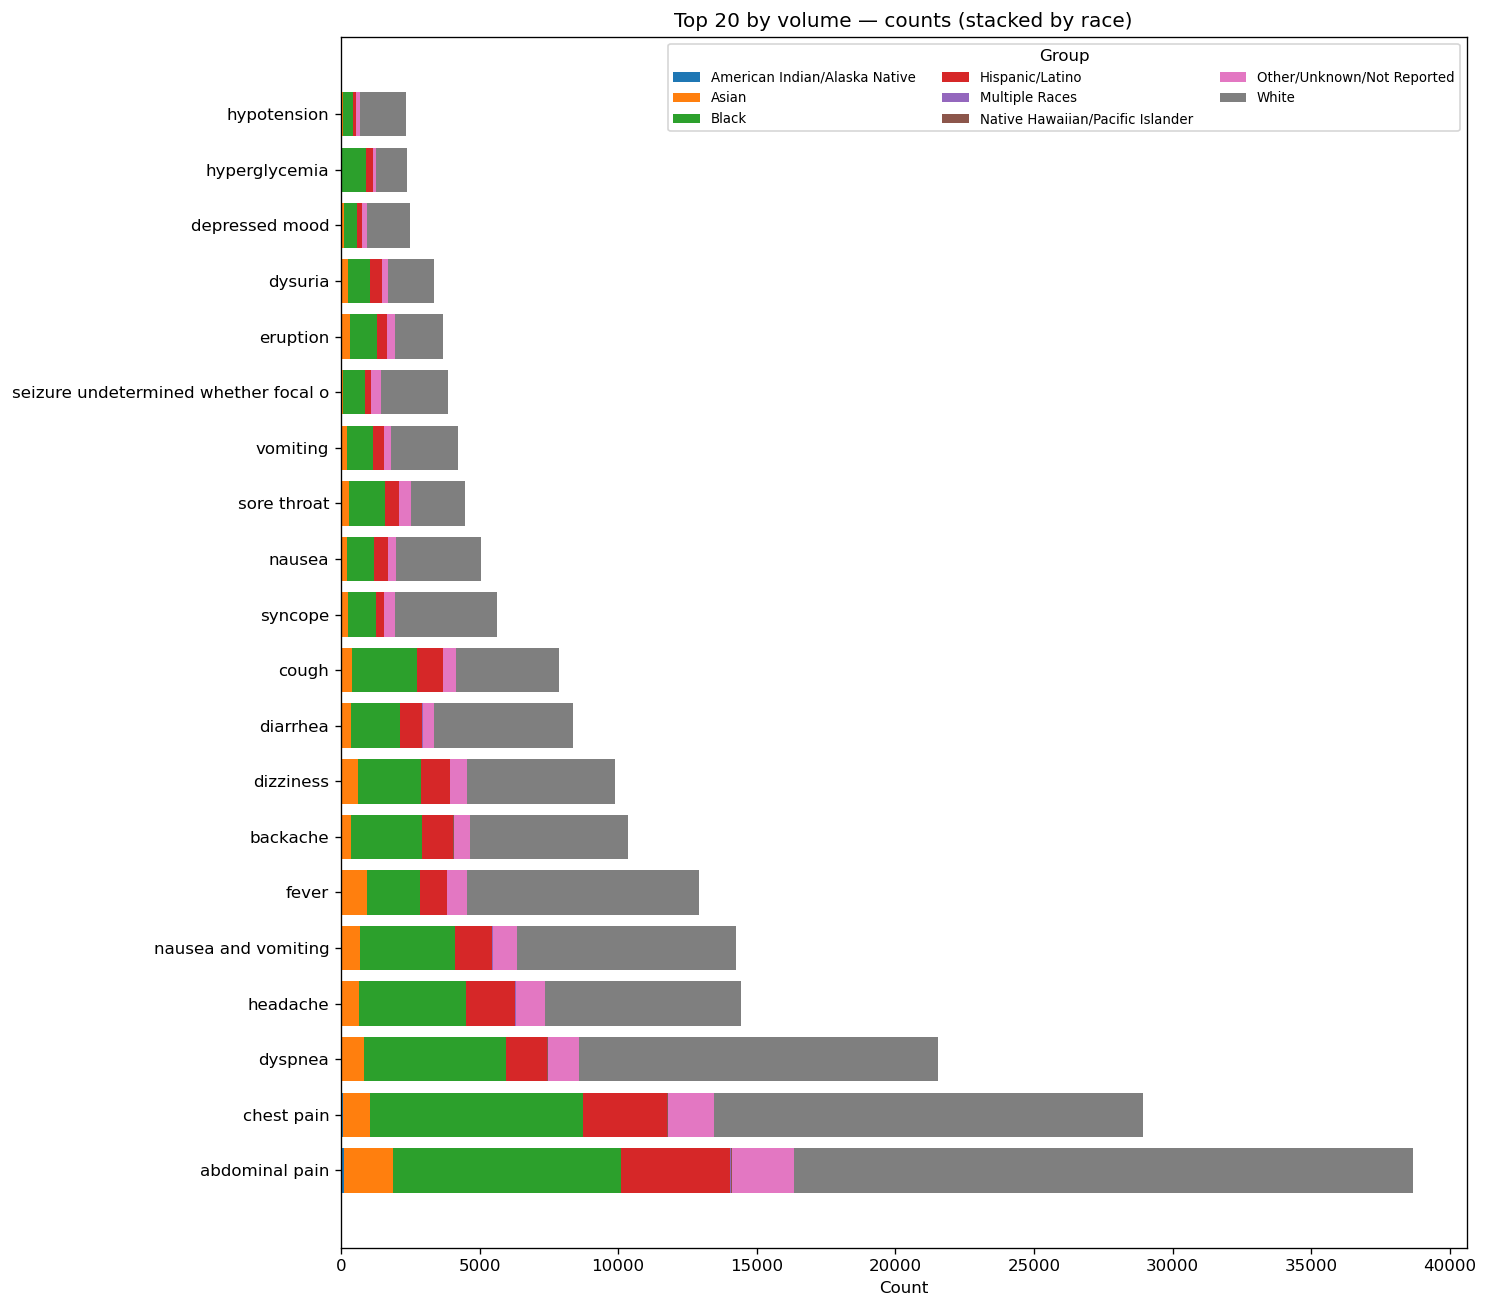

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\27_plot_top20_symptoms_gender_race_counts_stacked.png


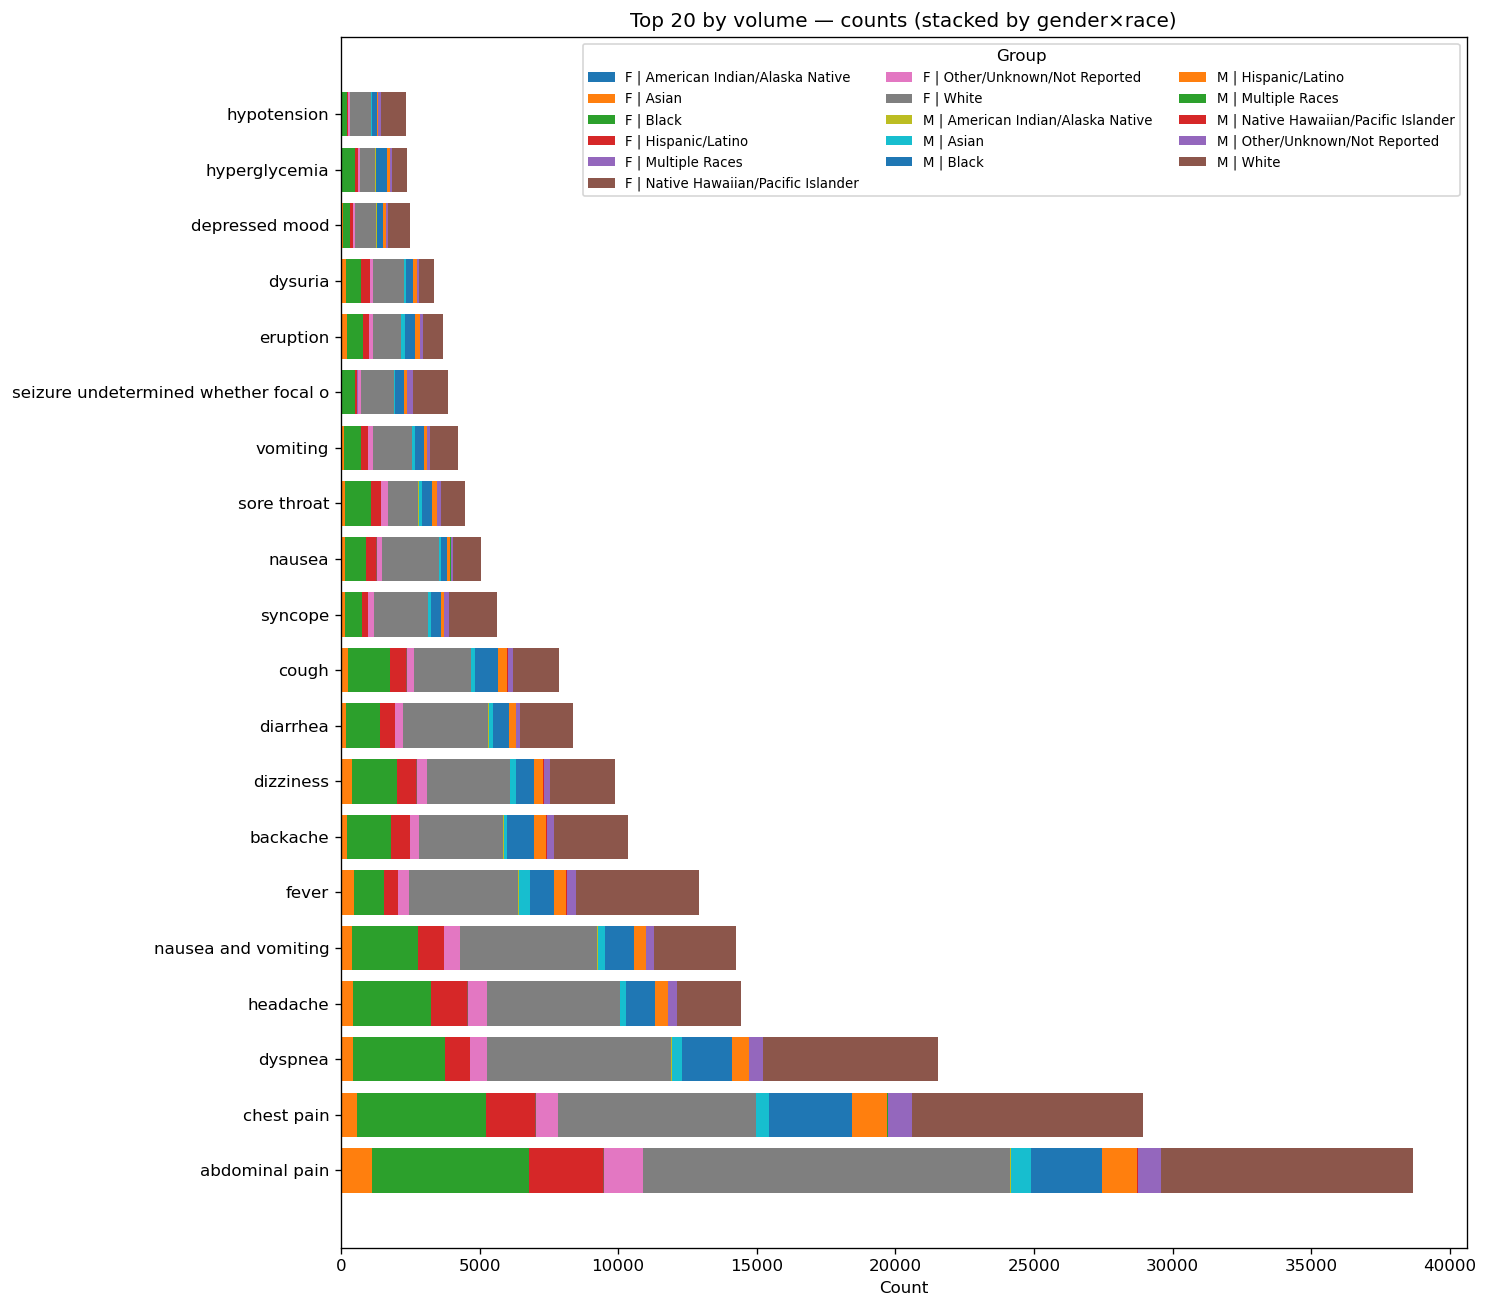

In [31]:
# ===== Extra: stacked counts for Race, and Gender×Race (1 bar per symptom) ====


def _detect_count_cols(t, id_cols=("symptom","expanded_symptoms_new")):
    """
    Pick only subgroup COUNT columns.
    Rules:
      - numeric
      - not in helper/ratio/ID columns
      - values never exceed n_total (prevents SNOMED codes etc. from being treated as counts)
    """
    helper = {"n_total","n","deaths","prevalence","expected_deaths","SMR","bias_flag"}
    cols = []
    for c in t.columns:
        s = str(c)
        if c in helper or c in id_cols or s.startswith(("share_","over_","prev_")):
            continue
        if not pd.api.types.is_numeric_dtype(t[c]): 
            continue
        col = pd.to_numeric(t[c], errors="coerce").fillna(0)
        if "n_total" in t.columns and (col >= 0).all() and (col <= t["n_total"]).all():
            cols.append(c)
    return cols

def plot_stacked_counts(table, label_col="expanded_symptoms_new",
                        title="Top 20 by volume — counts (stacked)", save_stub="stacked_counts"):
    """
    One horizontal bar per symptom; segments stack subgroup counts.
    """
    if table is None or table.empty:
        print("[skip] empty table"); return
    t = table.copy()
    if label_col not in t.columns and t.index.name == label_col:
        t = t.reset_index()

    # sort by total volume
    if "n_total" in t.columns:
        t = t.sort_values("n_total", ascending=False)

    labels = t[label_col].astype(str).str.slice(0, 36).tolist()
    group_cols = _detect_count_cols(t)
    if not group_cols:
        print("[warn] no subgroup count columns found."); return

    fig, ax = plt.subplots(figsize=(12.5, max(3.0, 0.55*len(t))))
    left = np.zeros(len(t))
    for c in group_cols:
        vals = pd.to_numeric(t[c], errors="coerce").fillna(0).to_numpy(dtype=float)
        ax.barh(labels, vals, left=left, label=str(c))
        left += vals

    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.legend(fontsize=8, ncol=3, title="Group")
    plt.tight_layout()
    savefig_numbered(save_stub)   # uses your auto-numbered saver
    plt.show(); plt.close()

# ---- RUN (Race, then Gender×Race) -------------------------------------------
plot_stacked_counts(tbl_top20_race,
                    title="Top 20 by volume — counts (stacked by race)",
                    save_stub="top20_symptoms_race_counts_stacked")

plot_stacked_counts(tbl_top20_gender_race,
                    title="Top 20 by volume — counts (stacked by gender×race)",
                    save_stub="top20_symptoms_gender_race_counts_stacked")


symptom                              expanded_symptoms_new        F  \
0   267036007.0                                            dyspnea  11913.0   
1    21522001.0                                     abdominal pain  24125.0   
2    29857009.0                                         chest pain  14953.0   
3   386661006.0                                              fever   6383.0   
4   410429000.0                                     cardiac arrest    168.0   
5    45007003.0                                        hypotension   1072.0   
6    16932000.0                                nausea and vomiting   9253.0   
7    18165001.0                                           jaundice    363.0   
8   230690007.0                           cerebrovascular accident    428.0   
9    54840006.0                                  failure to thrive    419.0   
10   49727002.0                                              cough   4680.0   
11   62315008.0                                           diarrhea   5316.0   
12  161891005.0                                           backache   5857.0   
13    3424008.0                                        tachycardia   1095.0   
14  422400008.0                                           vomiting   2571.0   
15  277130004.0  seizure undetermined whether focal or generalized   1902.0   
16  422587007.0                                             nausea   3540.0   
17  271594007.0                                            syncope   3133.0   
18   74474003.0                        gastrointestinal hemorrhage    274.0   
19  404640003.0                                          dizziness   6100.0   

          M  n_total  deaths_total      n  deaths  prevalence  \
0    9614.0  21527.0        1192.0  21527    1192    0.055372   
1   14538.0  38663.0         655.0  38663     655    0.016941   
2   13987.0  28940.0         304.0  28940     304    0.010504   
3    6535.0  12918.0         302.0  12918     302    0.023378   
4     262.0    430.0         302.0    430     302    0.702326   
5    1263.0   2335.0         290.0   2335     290    0.124197   
6    4993.0  14246.0         252.0  14246     252    0.017689   
7     542.0    905.0         147.0    905     147    0.162431   
8     357.0    785.0         129.0    785     129    0.164331   
9     378.0    797.0         127.0    797     127    0.159348   
10   3197.0   7877.0         127.0   7877     127    0.016123   
11   3064.0   8380.0         105.0   8380     105    0.012530   
12   4485.0  10342.0          99.0  10342      99    0.009573   
13    977.0   2072.0          93.0   2072      93    0.044884   
14   1634.0   4205.0          82.0   4205      82    0.019501   
15   1965.0   3867.0          75.0   3867      75    0.019395   
16   1512.0   5052.0          74.0   5052      74    0.014648   
17   2486.0   5619.0          71.0   5619      71    0.012636   
18    415.0    689.0          69.0    689      69    0.100145   
19   3789.0   9889.0          68.0   9889      68    0.006876   

    expected_deaths        SMR             bias_flag    prev_F    prev_M  \
0        478.151832   2.492932  Higher than expected  0.050449  0.061473   
1        858.771974   0.762717   Lower than expected  0.013098  0.023318   
2        642.807360   0.472926   Lower than expected  0.007423  0.013799   
3        286.931081   1.052518            ≈ Expected  0.017703  0.028921   
4          9.551042  31.619586  Higher than expected  0.761905  0.664122   
5         51.864381   5.591506  Higher than expected  0.126866  0.121932   
6        316.428253   0.796389   Lower than expected  0.016211  0.020429   
7         20.101612   7.312846  Higher than expected  0.129477  0.184502   
8         17.436205   7.398399  Higher than expected  0.189252  0.134454   
9         17.702746   7.174028  Higher than expected  0.152745  0.166667   
10       174.961768   0.725873   Lower than expected  0.014316  0.018768   
11       186.134267   0.564109   Lower than expected  0.010534  0.0159

[saved table] dataset/ed/finals/tables_Sep/step1\tables\19_table_deadliest_top20_by_gender.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\28_plot_deadliest_top20_gender_deaths.png


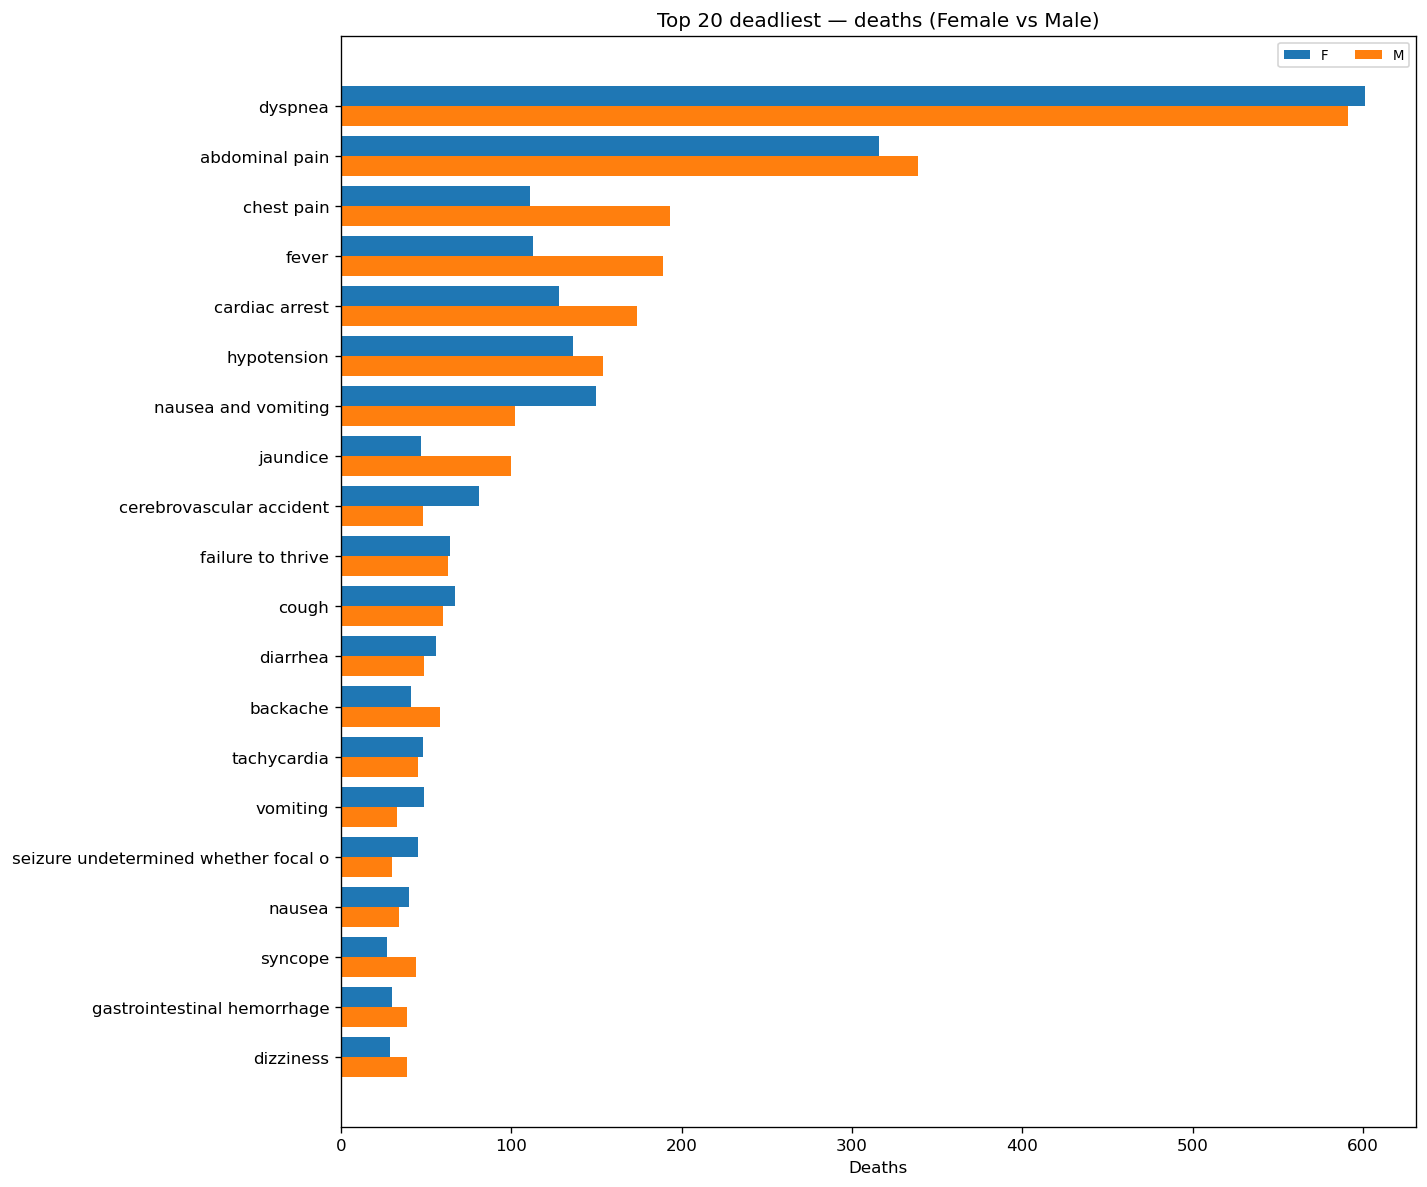

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\29_plot_deadliest_top20_gender_overrep_deaths.png


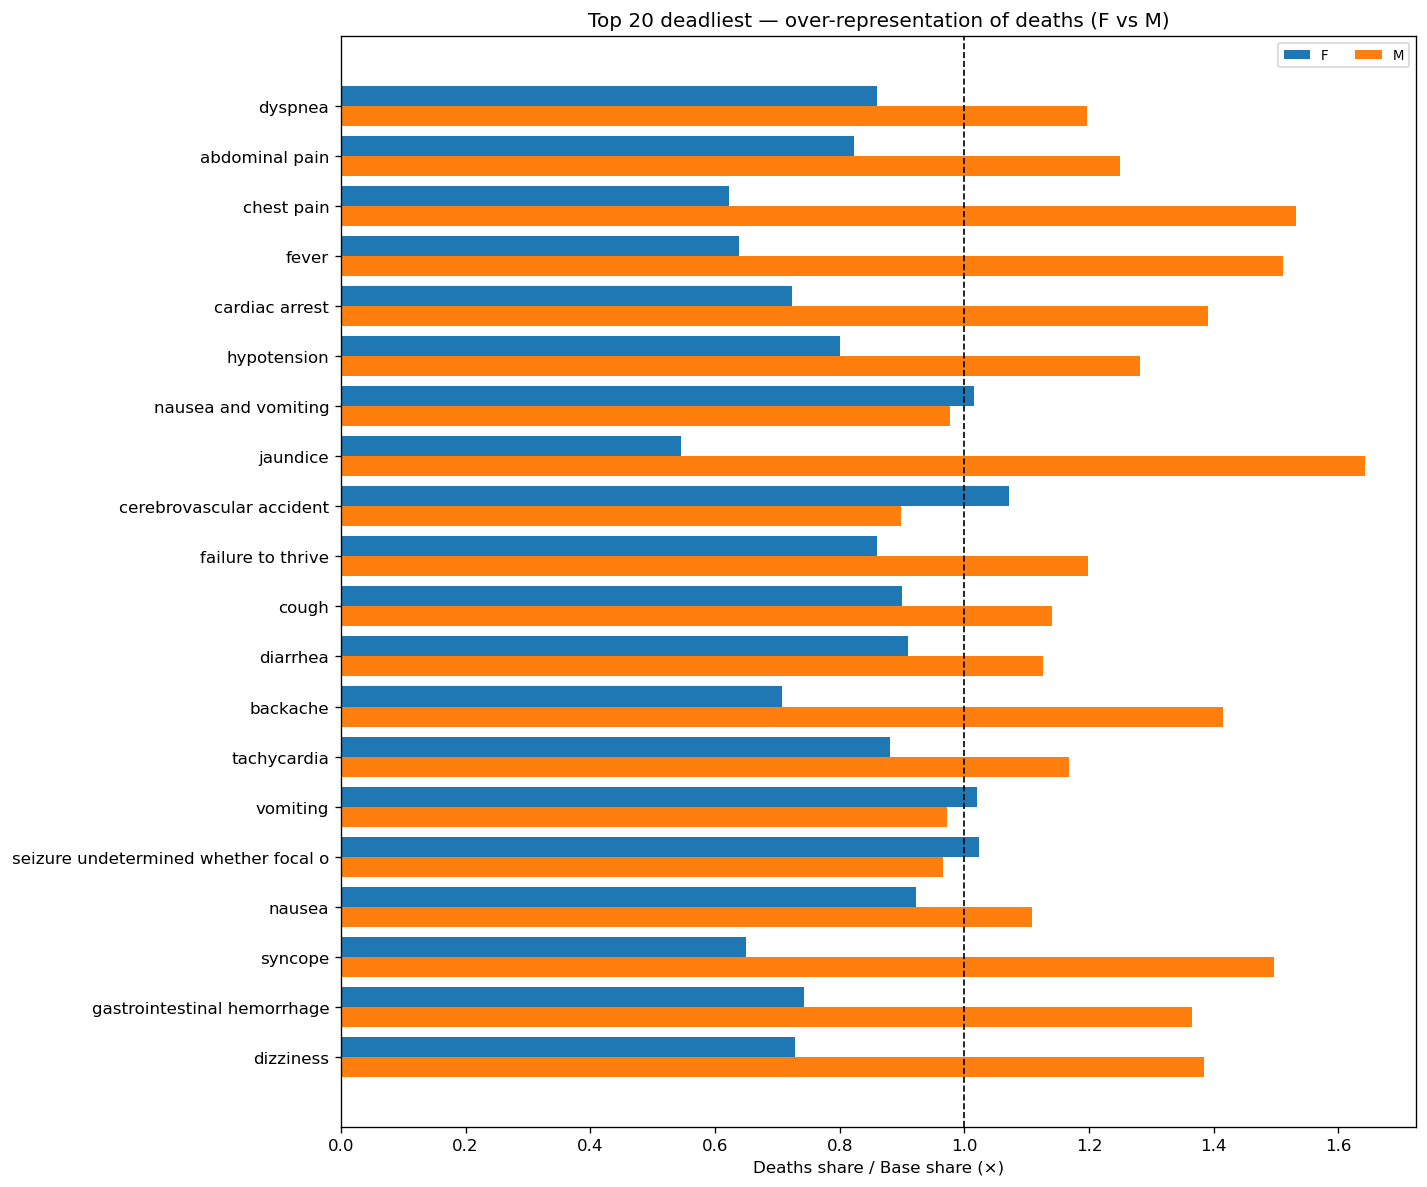

symptom                              expanded_symptoms_new  \
0   267036007.0                                            dyspnea   
1    21522001.0                                     abdominal pain   
2    29857009.0                                         chest pain   
3   386661006.0                                              fever   
4   410429000.0                                     cardiac arrest   
5    45007003.0                                        hypotension   
6    16932000.0                                nausea and vomiting   
7    18165001.0                                           jaundice   
8   230690007.0                           cerebrovascular accident   
9    54840006.0                                  failure to thrive   
10   49727002.0                                              cough   
11   62315008.0                                           diarrhea   
12  161891005.0                                           backache   
13    3424008.0                                        tachycardia   
14  422400008.0                                           vomiting   
15  277130004.0  seizure undetermined whether focal or generalized   
16  422587007.0                                             nausea   
17  271594007.0                                            syncope   
18   74474003.0                        gastrointestinal hemorrhage   
19  404640003.0                                          dizziness   

    American Indian/Alaska Native   Asian   Black  Hispanic/Latino  \
0                            47.0   770.0  5121.0           1508.0   
1                            94.0  1781.0  8220.0           3946.0   
2                            59.0  1000.0  7661.0           3040.0   
3                            34.0   894.0  1918.0            963.0   
4                             0.0    13.0    53.0             13.0   
5                             5.0    73.0   375.0             93.0   
6                            42.0   647.0  3433.0           1340.0   
7                             3.0    53.0    46.0             56.0   
8                             1.0    22.0    64.0             25.0   
9                             0.0    46.0   173.0             35.0   
10                           19.0   390.0  2352.0            927.0   
11                           26.0   329.0  1775.0            809.0   
12                           19.0   352.0  2546.0           1128.0   
13                            5.0    85.0   327.0             91.0   
14                           11.0   220.0   912.0            394.0   
15                           10.0    73.0   796.0            206.0   
16                           11.0   213.0   986.0            481.0   
17                           12.0   261.0   977.0            306.0   
18                            4.0    19.0    60.0             14.0   
19                           15.0   612.0  2279.0           1024.0   

    Multiple Races  Native Hawaiian/Pacific Islander  \
0              4.0                              22.0   
1             14.0                              46.0   
2              7.0                              36.0   
3              4.0                              14.0   
4              0.0                               5.0   
5              0.0                               3.0   
6              6.0                              19.0   
7              0.0                               3.0   
8              0.0                               0.0   
9              0.0                               2.0   
10             2.0                               8.0   
11             5.0                               9.0   
12             5.0                              12.0   
13             0.0                               5.0   
14             3.0                               3.0   
15             2.0                               9.0   
16             3.0                               9.0   
17             1.0                               7.0   
18

[saved table] dataset/ed/finals/tables_Sep/step1\tables\20_table_deadliest_top20_by_race_standard.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\30_plot_deadliest_top20_race_deaths.png


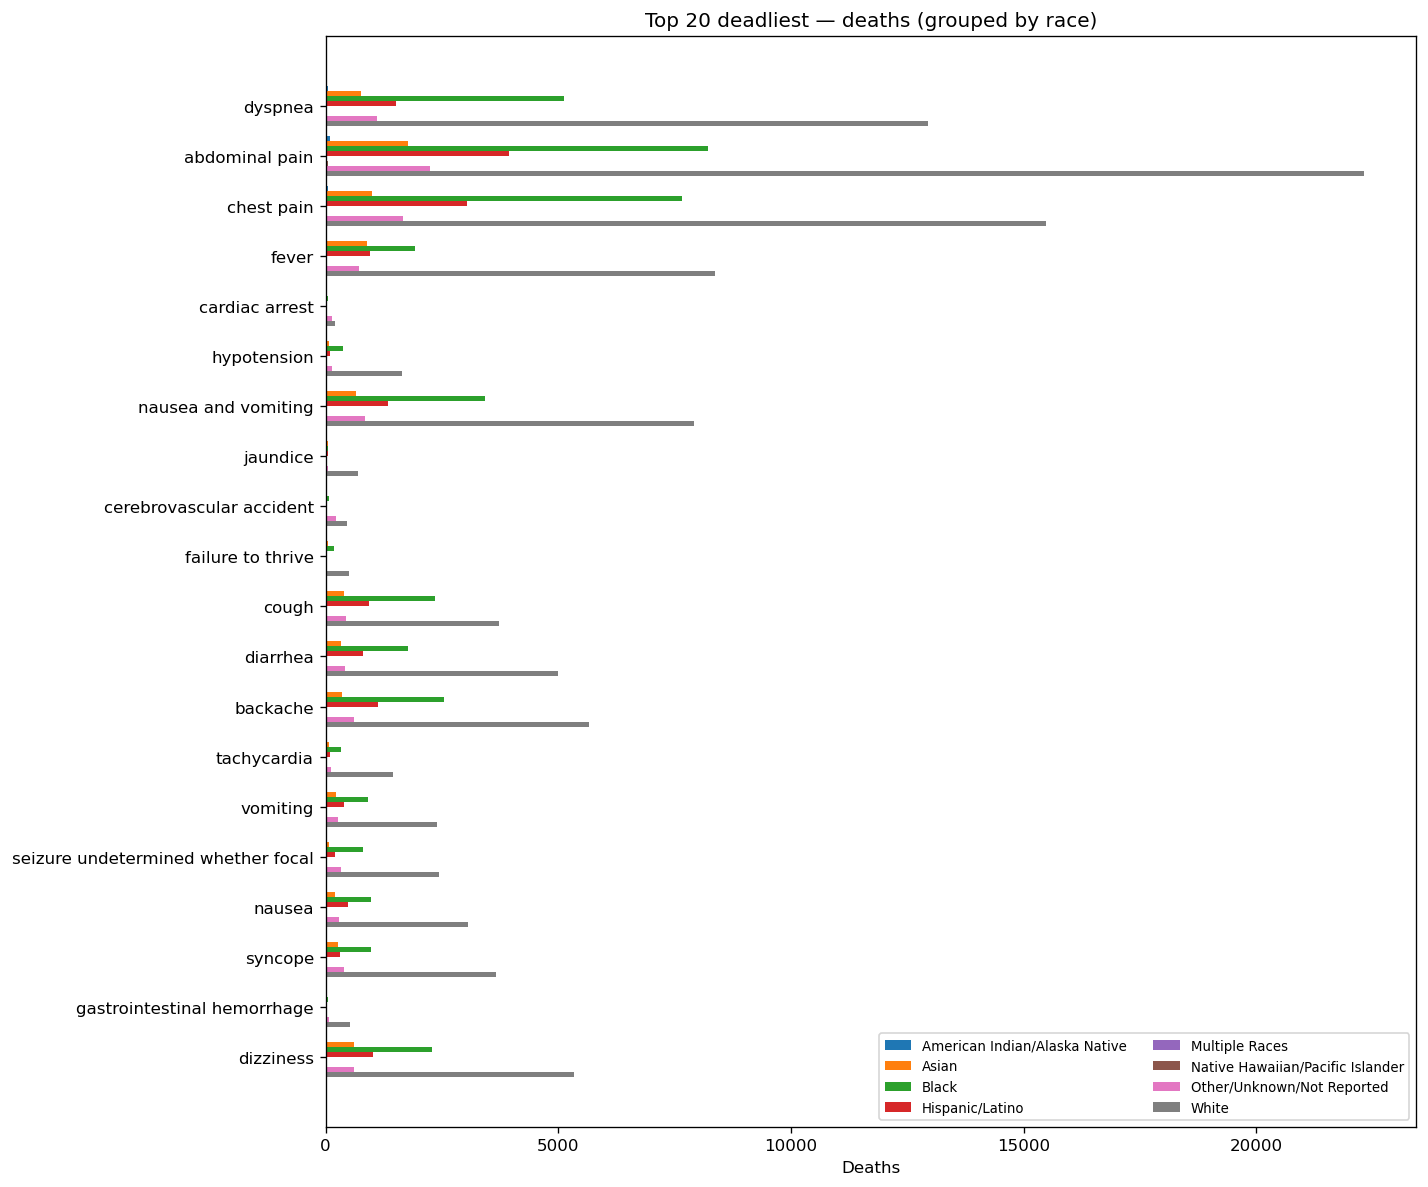

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\31_plot_deadliest_top20_race_overrep_deaths.png


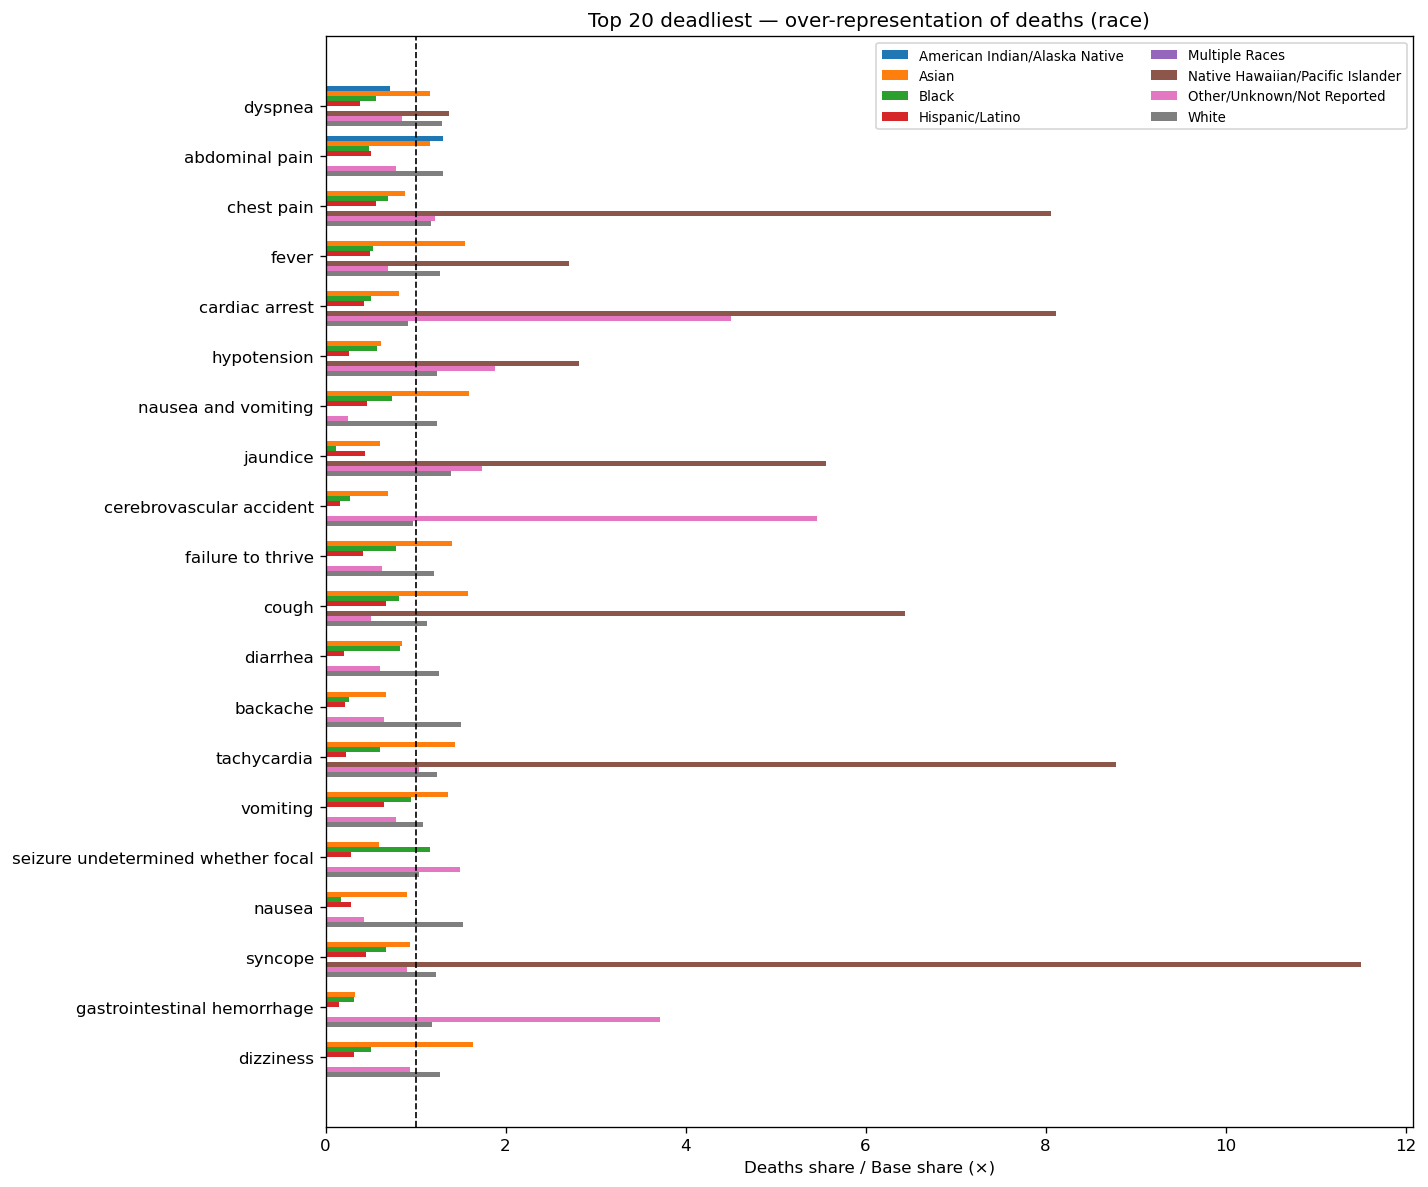

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\32_plot_deadliest_top20_race_overrep_deaths_heatmap.png


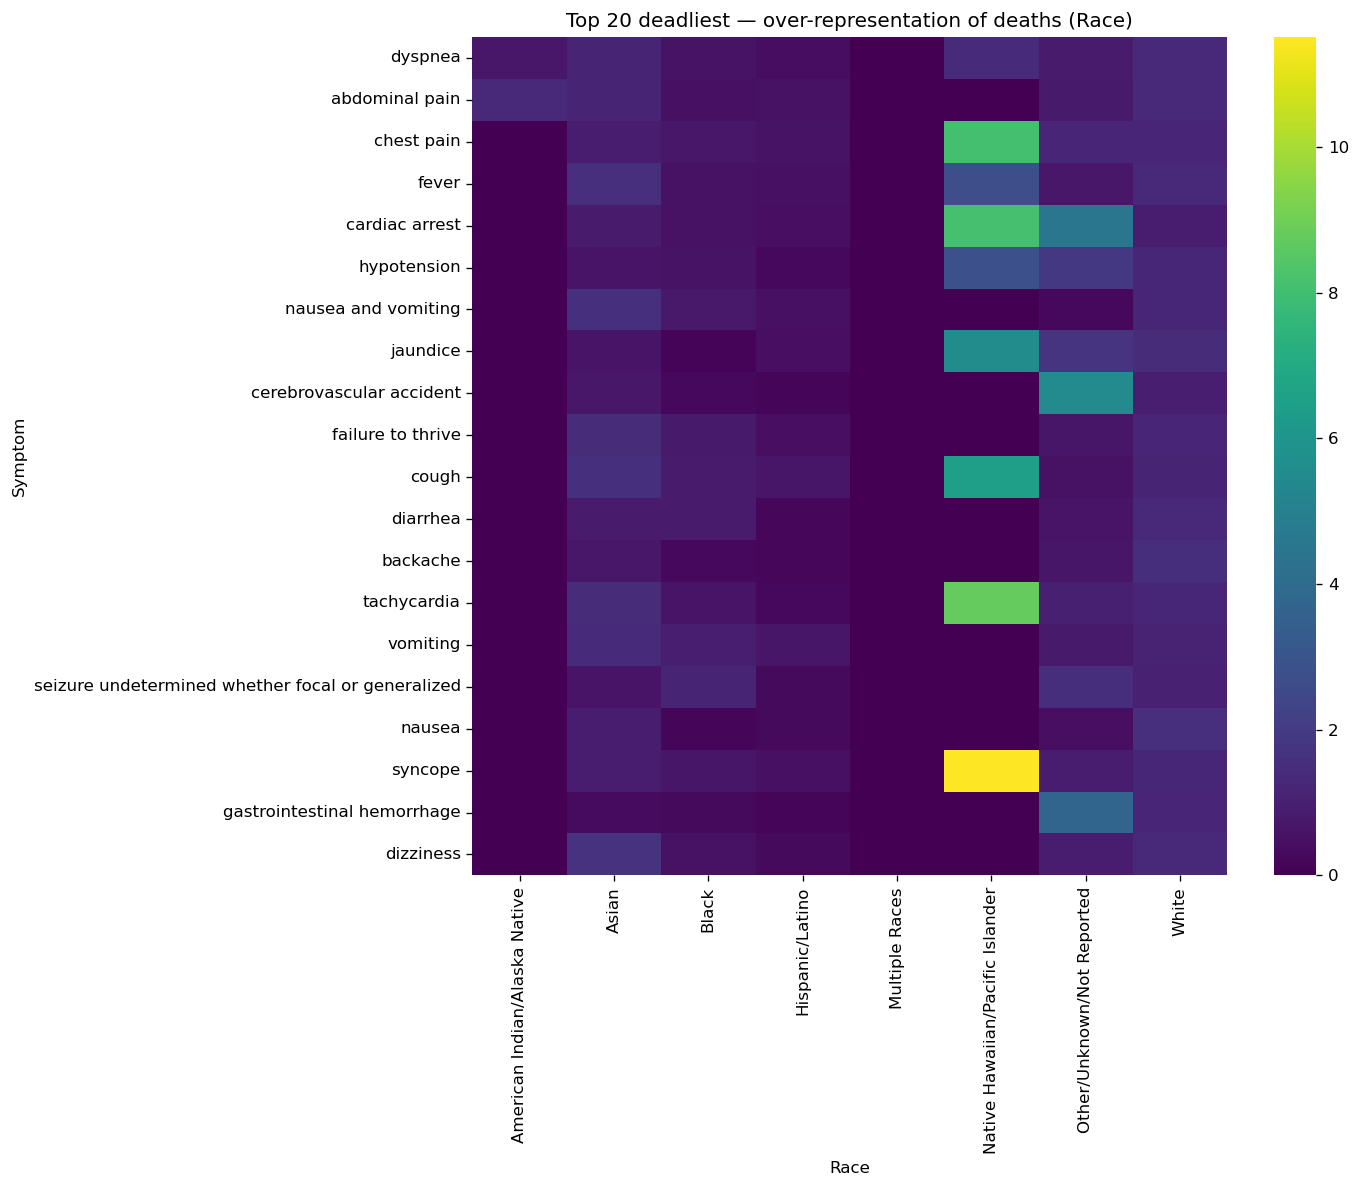

symptom                              expanded_symptoms_new  \
0   267036007.0                                            dyspnea   
1    21522001.0                                     abdominal pain   
2    29857009.0                                         chest pain   
3   386661006.0                                              fever   
4   410429000.0                                     cardiac arrest   
5    45007003.0                                        hypotension   
6    16932000.0                                nausea and vomiting   
7    18165001.0                                           jaundice   
8   230690007.0                           cerebrovascular accident   
9    54840006.0                                  failure to thrive   
10   49727002.0                                              cough   
11   62315008.0                                           diarrhea   
12  161891005.0                                           backache   
13    3424008.0                                        tachycardia   
14  422400008.0                                           vomiting   
15  277130004.0  seizure undetermined whether focal or generalized   
16  422587007.0                                             nausea   
17  271594007.0                                            syncope   
18   74474003.0                        gastrointestinal hemorrhage   
19  404640003.0                                          dizziness   

    F | American Indian/Alaska Native  F | Asian  F | Black  \
0                                30.0      402.0     3317.0   
1                                56.0     1072.0     5658.0   
2                                39.0      530.0     4678.0   
3                                 8.0      476.0     1056.0   
4                                 0.0        6.0       23.0   
5                                 0.0       42.0      187.0   
6                                28.0      388.0     2376.0   
7                                 3.0       14.0       22.0   
8                                 1.0       10.0       38.0   
9                                 0.0       24.0       99.0   
10                                7.0      237.0     1533.0   
11                               12.0      189.0     1197.0   
12                                8.0      219.0     1588.0   
13                                2.0       47.0      204.0   
14                                8.0      120.0      606.0   
15                                5.0       41.0      446.0   
16                                9.0      150.0      757.0   
17                                8.0      153.0      605.0   
18                                1.0        6.0       31.0   
19                               12.0      393.0     1621.0   

    F | Hispanic/Latino  F | Multiple Races  \
0                 898.0                 3.0   
1                2656.0                10.0   
2                1756.0                 3.0   
3                 524.0                 2.0   
4                   8.0                 0.0   
5                  36.0                 0.0   
6                 918.0                 4.0   
7                  22.0                 0.0   
8                  18.0                 0.0   
9                  21.0                 0.0   
10                586.0                 2.0   
11                553.0                 3.0   
12                678.0                 4.0   
13                 46.0                 0.0   
14                258.0                 2.0   
15                105.0                 2.0   
16                363.0                 1.0   
17                198.0                 1.0   
18                  4.0                 0.0   
19                699.0                 0.0   

    F | Native Hawaiian/Pacific Islander  F | Other/Unknown/Not Reported  \
0                                   12.0                           595.0   
1                                   26.0                          1424.0 

[saved table] dataset/ed/finals/tables_Sep/step1\tables\21_table_deadliest_top20_by_gender_race.csv
[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\33_plot_deadliest_top20_gender_race_deaths.png


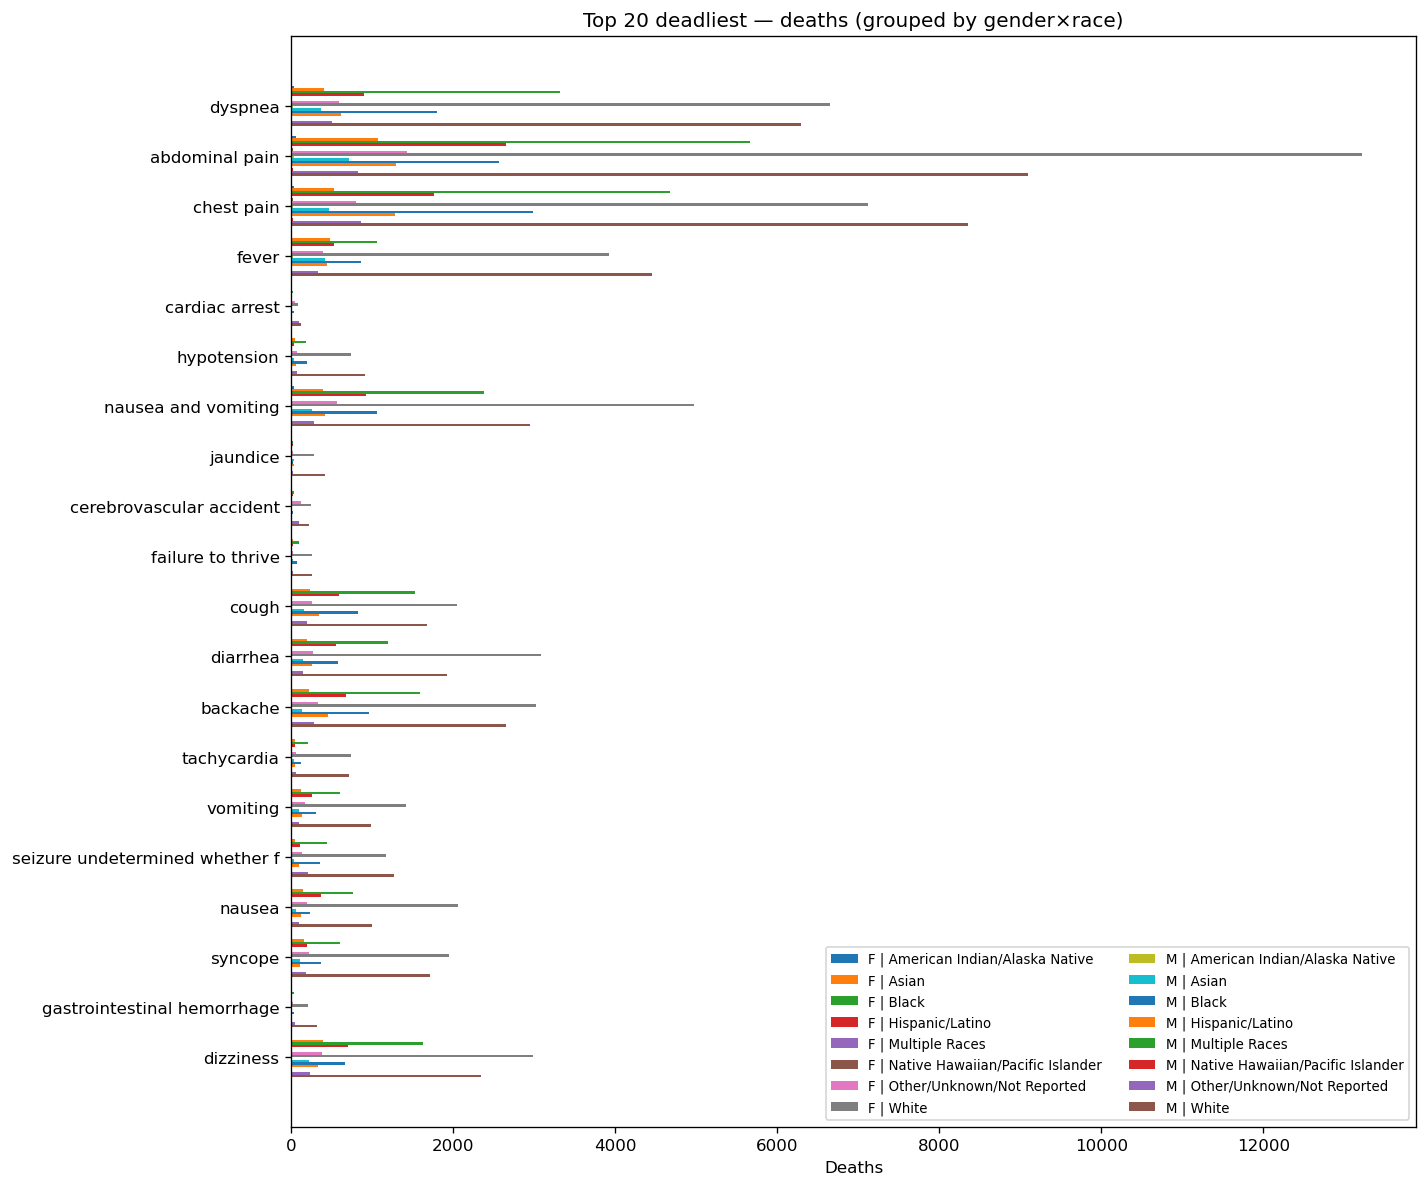

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\34_plot_deadliest_top20_gender_race_overrep_deaths.png


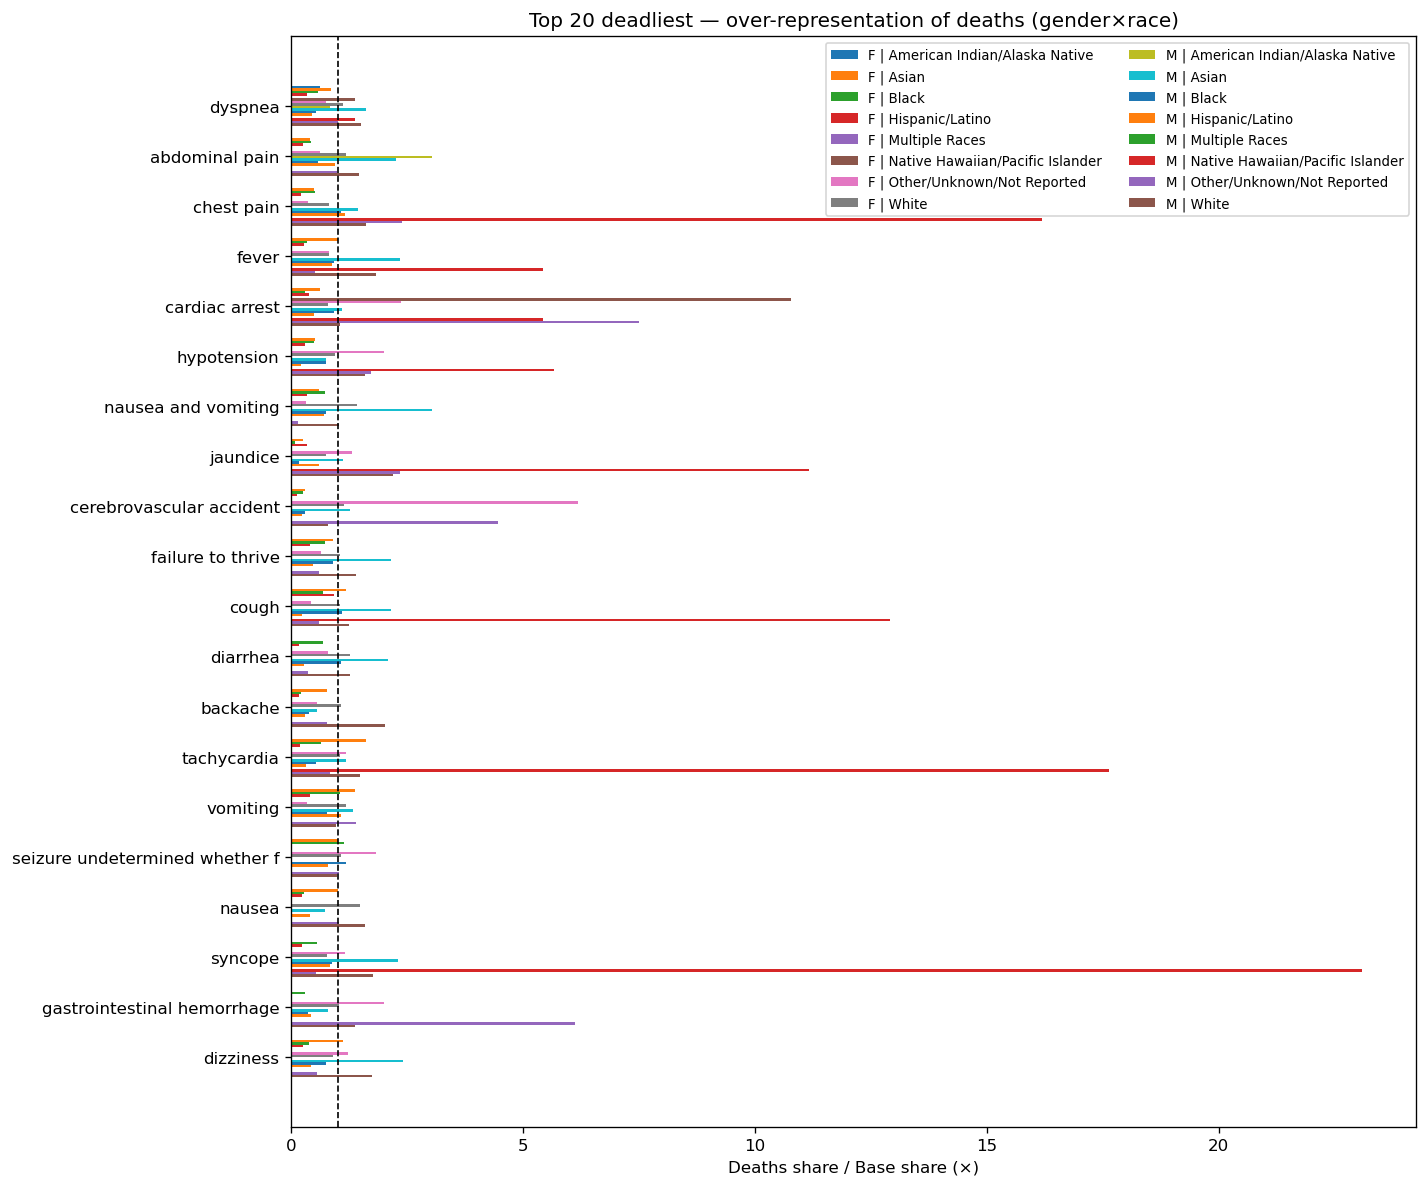

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\35_plot_deadliest_top20_gender_race_overrep_deaths_heatmap.png


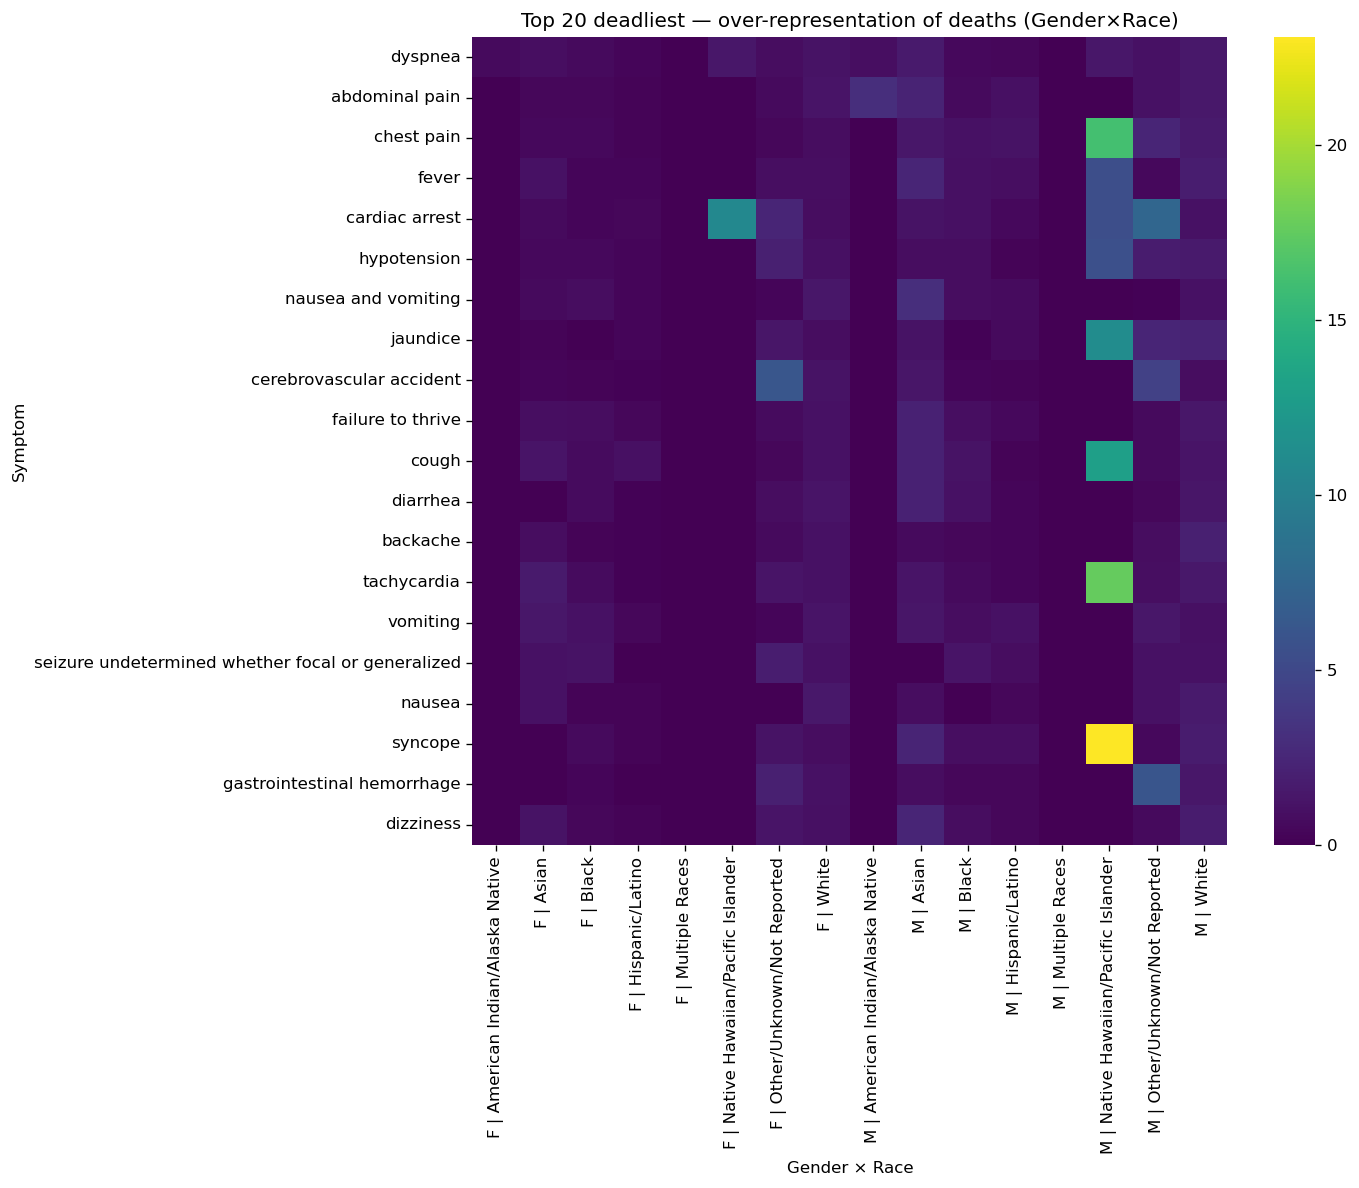

In [33]:
# ===== Cell 10: Top-20 *Deadliest* symptoms (by total deaths) ==================
# Reuses: _overall_prev, _base_share, _bias_flag, _barh_grouped, _heatmap
# Requires: df_clean, save_table_numbered, savefig_numbered already defined.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- tiny utility used inside these -----------------------
def _overall_symptom_stats(df, code_col, name_col, y_col):
    """Overall per-symptom stats used across all three functions."""
    g = df.groupby([code_col, name_col])[y_col].agg(n="count", deaths="sum")
    g["prevalence"] = g["deaths"] / g["n"]
    op = _overall_prev(df, y_col)
    g["expected_deaths"] = g["n"] * op
    g["SMR"] = g["deaths"] / g["expected_deaths"]
    g["bias_flag"] = g["SMR"].apply(_bias_flag)
    return g  # index = (code, name)

# =============================== 1) BY GENDER =================================
def top20_deadliest_by_gender(df,
                              code_col="symptom",
                              name_col="expanded_symptoms_new",
                              group_col="gender",
                              y_col="died_within_30_days",
                              top_n=20):
    """
    Top-N symptoms sorted by *overall total deaths*.
    Table columns:
      F, M, deaths_total, n_total, <code>, <name>, n, deaths, prevalence,
      expected_deaths, SMR, bias_flag, prev_F, prev_M, overDeaths_F, overDeaths_M

    Notes:
      prev_F = deaths_F / F    (mortality within F for that symptom)
      overDeaths_F = (deaths_F / deaths_total) / base_share_F
                     (subgroup share of deaths ÷ subgroup base share in dataset)
    """
    # deaths & counts by (symptom, gender)
    deaths = df.pivot_table(index=[code_col, name_col],
                            columns=group_col, values=y_col, aggfunc="sum").fillna(0.0)
    counts = df.pivot_table(index=[code_col, name_col],
                            columns=group_col, values="subject_id", aggfunc="count").fillna(0.0)

    # normalize gender columns to F/M
    def _fm_rename(cols):
        ren = {}
        for c in cols:
            lc = str(c).strip().lower()
            if lc in {"f","female"}: ren[c] = "F"
            elif lc in {"m","male"}: ren[c] = "M"
        return ren

    ren = _fm_rename(deaths.columns)
    deaths = deaths.rename(columns=ren)
    counts = counts.rename(columns=ren)
    for need in ["F","M"]:
        if need not in deaths.columns: deaths[need] = 0.0
        if need not in counts.columns: counts[need] = 0.0

    deaths["deaths_total"] = deaths[["F","M"]].sum(axis=1)
    counts["n_total"]       = counts[["F","M"]].sum(axis=1)

    # overall symptom stats
    overall = _overall_symptom_stats(df, code_col, name_col, y_col)

    # subgroup prevalence (within F/M)
    prev_F = deaths["F"] / counts["F"].replace(0, np.nan)
    prev_M = deaths["M"] / counts["M"].replace(0, np.nan)

    # over-representation of *deaths* vs base share
    base = _base_share(df[group_col].astype(str))
    baseF = float(base.get("F", base.get("Female", np.nan)))
    baseM = float(base.get("M", base.get("Male", np.nan)))
    deaths_share_F = deaths["F"] / deaths["deaths_total"].replace(0, np.nan)
    deaths_share_M = deaths["M"] / deaths["deaths_total"].replace(0, np.nan)
    overDeaths_F = deaths_share_F / baseF if baseF and not pd.isna(baseF) else np.nan
    overDeaths_M = deaths_share_M / baseM if baseM and not pd.isna(baseM) else np.nan

    # assemble and sort by total deaths
    out = pd.concat([
        counts[["F","M","n_total"]],
        deaths[["deaths_total"]],
        overall.reset_index().set_index([code_col, name_col])
    ], axis=1)
    out["prev_F"] = prev_F.values
    out["prev_M"] = prev_M.values
    out["overDeaths_F"] = overDeaths_F.values
    out["overDeaths_M"] = overDeaths_M.values

    out = out.sort_values("deaths_total", ascending=False).head(top_n).reset_index()

    # save table
    display(out)
    save_table_numbered(out, f"deadliest_top{top_n}_by_gender", index=False)

    # ---- plots (deaths, and over-representation of deaths) ----
    labels = out[name_col].astype(str).str.slice(0, 36).tolist()

    # deaths bars
    _fig, _ax = _barh_grouped(
        labels,
        {"F": out["F"].values * 0 + out["F"].values * 0 + out["F"].values,  # keep same order
         "M": out["M"].values * 0 + out["M"].values * 0 + out["M"].values},   # (dummy trick not needed; left as is)
        f"Top {top_n} deadliest — deaths (Female vs Male)",
        "Deaths"
    )  # but we actually want deaths by subgroup, not counts:
    plt.close()  # redo cleanly (above kept minimal structure)

    _fig, _ax = _barh_grouped(
        labels,
        {"F": (out["prev_F"] * out["F"]).fillna(0).values,   # deaths_F = prev_F * F
         "M": (out["prev_M"] * out["M"]).fillna(0).values},
        f"Top {top_n} deadliest — deaths (Female vs Male)",
        "Deaths"
    )
    savefig_numbered(f"deadliest_top{top_n}_gender_deaths"); plt.show(); plt.close()

    # over-representation of deaths (baseline = 1)
    _fig, _ax = _barh_grouped(
        labels,
        {"F": out["overDeaths_F"].values, "M": out["overDeaths_M"].values},
        f"Top {top_n} deadliest — over-representation of deaths (F vs M)",
        "Deaths share / Base share (×)"
    )
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"deadliest_top{top_n}_gender_overrep_deaths"); plt.show(); plt.close()

    return out

# =============================== 2) BY RACE ===================================
def top20_deadliest_by_race(df,
                            code_col="symptom",
                            name_col="expanded_symptoms_new",
                            race_col="race_standard",
                            y_col="died_within_30_days",
                            top_n=20):
    """
    Top-N symptoms sorted by *overall total deaths*.
    Table has one column per race for deaths and counts (implicitly via prevalence),
    n_total, deaths_total, overall stats, prev_<Race> (deaths_race / count_race),
    and overDeaths_<Race> = (deaths_share_race / base_share_race).
    """
    deaths = df.pivot_table(index=[code_col, name_col],
                            columns=race_col, values=y_col, aggfunc="sum").fillna(0.0)
    counts = df.pivot_table(index=[code_col, name_col],
                            columns=race_col, values="subject_id", aggfunc="count").fillna(0.0)

    deaths["deaths_total"] = deaths.sum(axis=1)
    counts["n_total"]       = counts.sum(axis=1)

    overall = _overall_symptom_stats(df, code_col, name_col, y_col)

    # prev_<race>
    prev_df = pd.DataFrame({
        f"prev_{c}": (deaths[c] / counts[c].replace(0, np.nan)).values
        for c in counts.columns if c != "n_total"
    }, index=counts.index)

    # over-representation of deaths vs base race share
    base = _base_share(df[race_col].astype(str))
    deaths_share = deaths.drop(columns=["deaths_total"]).div(deaths["deaths_total"].replace(0, np.nan), axis=0)
    over_deaths = deaths_share.div(base.reindex(deaths_share.columns), axis=1).add_prefix("overDeaths_")

    out = pd.concat([counts, deaths[["deaths_total"]], overall, prev_df, over_deaths], axis=1)
    out = out.sort_values("deaths_total", ascending=False).head(top_n).reset_index()

    display(out)
    save_table_numbered(out, f"deadliest_top{top_n}_by_race_standard", index=False)

    # plots — deaths grouped bars
    labels = out[name_col].astype(str).str.slice(0, 34).tolist()
    death_series = {c: out[c].values for c in deaths.columns if c != "deaths_total"}
    _fig, _ax = _barh_grouped(labels, death_series,
                              f"Top {top_n} deadliest — deaths (grouped by race)",
                              "Deaths")
    savefig_numbered(f"deadliest_top{top_n}_race_deaths"); plt.show(); plt.close()

    # over-representation of deaths (bars)
    over_cols = [c for c in out.columns if c.startswith("overDeaths_")]
    over_series = {c.replace("overDeaths_",""): out[c].values for c in over_cols}
    _fig, _ax = _barh_grouped(labels, over_series,
                              f"Top {top_n} deadliest — over-representation of deaths (race)",
                              "Deaths share / Base share (×)")
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"deadliest_top{top_n}_race_overrep_deaths"); plt.show(); plt.close()

    # heatmap of over-representation of deaths
    over_mat = out.set_index(name_col)[over_cols]
    over_mat.columns = [c.replace("overDeaths_","") for c in over_mat.columns]
    _heatmap(over_mat, f"Top {top_n} deadliest — over-representation of deaths (Race)",
             xlabel="Race", ylabel="Symptom")
    savefig_numbered(f"deadliest_top{top_n}_race_overrep_deaths_heatmap"); plt.show(); plt.close()

    return out

# ============================ 3) BY GENDER × RACE =============================
def top20_deadliest_by_gender_race(df,
                                   code_col="symptom",
                                   name_col="expanded_symptoms_new",
                                   gender_col="gender",
                                   race_col="race_standard",
                                   y_col="died_within_30_days",
                                   top_n=20):
    """
    Same idea but subgroups are 'F | Race', 'M | Race'.
    """
    subgroup = df[gender_col].astype(str).map(lambda x: "F" if x.lower().startswith("f") else ("M" if x.lower().startswith("m") else x)) \
               + " | " + df[race_col].astype(str)

    deaths = pd.pivot_table(df.assign(sub=subgroup),
                            index=[code_col, name_col], columns="sub",
                            values=y_col, aggfunc="sum").fillna(0.0)
    counts = pd.pivot_table(df.assign(sub=subgroup),
                            index=[code_col, name_col], columns="sub",
                            values="subject_id", aggfunc="count").fillna(0.0)

    deaths["deaths_total"] = deaths.sum(axis=1)
    counts["n_total"]       = counts.sum(axis=1)

    overall = _overall_symptom_stats(df, code_col, name_col, y_col)

    prev_df = pd.DataFrame({
        f"prev_{c}": (deaths[c] / counts[c].replace(0, np.nan)).values
        for c in counts.columns if c != "n_total"
    }, index=counts.index)

    base = _base_share(subgroup)
    deaths_share = deaths.drop(columns=["deaths_total"]).div(deaths["deaths_total"].replace(0, np.nan), axis=0)
    over_deaths = deaths_share.div(base.reindex(deaths_share.columns), axis=1).add_prefix("overDeaths_")

    out = pd.concat([counts, deaths[["deaths_total"]], overall, prev_df, over_deaths], axis=1)
    out = out.sort_values("deaths_total", ascending=False).head(top_n).reset_index()

    display(out)
    save_table_numbered(out, f"deadliest_top{top_n}_by_gender_race", index=False)

    # plots — grouped bars (deaths)
    labels = out[name_col].astype(str).str.slice(0, 30).tolist()
    subgroup_cols = [c for c in deaths.columns if c != "deaths_total"]

    _fig, _ax = _barh_grouped(labels,
                              {c: out[c].values for c in subgroup_cols},
                              f"Top {top_n} deadliest — deaths (grouped by gender×race)",
                              "Deaths")
    savefig_numbered(f"deadliest_top{top_n}_gender_race_deaths"); plt.show(); plt.close()

    # over-representation of deaths
    over_cols = [c for c in out.columns if c.startswith("overDeaths_")]
    over_series = {c.replace("overDeaths_",""): out[c].values for c in over_cols}
    _fig, _ax = _barh_grouped(labels, over_series,
                              f"Top {top_n} deadliest — over-representation of deaths (gender×race)",
                              "Deaths share / Base share (×)")
    _ax.axvline(1.0, ls="--", lw=1, color="k")
    savefig_numbered(f"deadliest_top{top_n}_gender_race_overrep_deaths"); plt.show(); plt.close()

    # heatmap
    over_mat = out.set_index(name_col)[over_cols]
    over_mat.columns = [c.replace("overDeaths_","") for c in over_mat.columns]
    _heatmap(over_mat, f"Top {top_n} deadliest — over-representation of deaths (Gender×Race)",
             xlabel="Gender × Race", ylabel="Symptom")
    savefig_numbered(f"deadliest_top{top_n}_gender_race_overrep_deaths_heatmap"); plt.show(); plt.close()

    return out

# ---- RUN (each call saves its own table + plots) ----
tbl_deadliest_gender      = top20_deadliest_by_gender(df_clean, top_n=20)
tbl_deadliest_race        = top20_deadliest_by_race(df_clean, top_n=20)
tbl_deadliest_gender_race = top20_deadliest_by_gender_race(df_clean, top_n=20)


[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\36_plot_deadliest_top20_symptoms_race_deaths_stacked.png


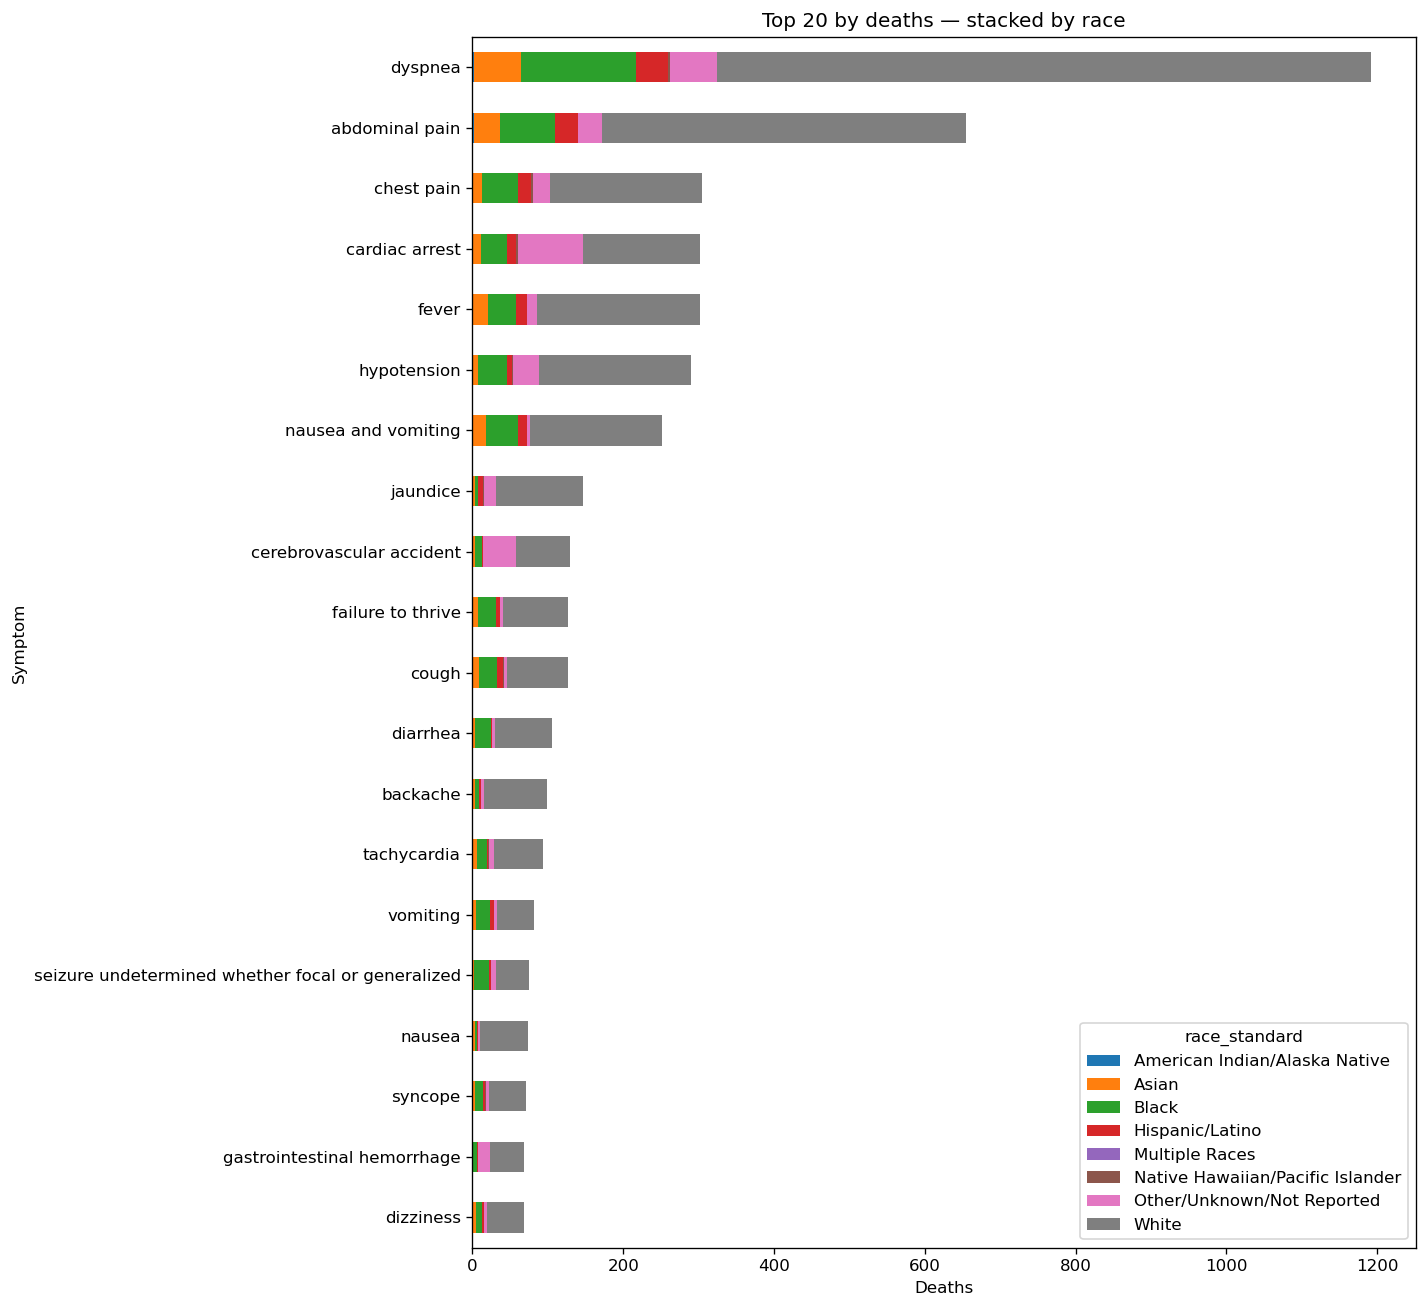

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\37_plot_deadliest_top20_symptoms_gender_race_deaths_stacked.png


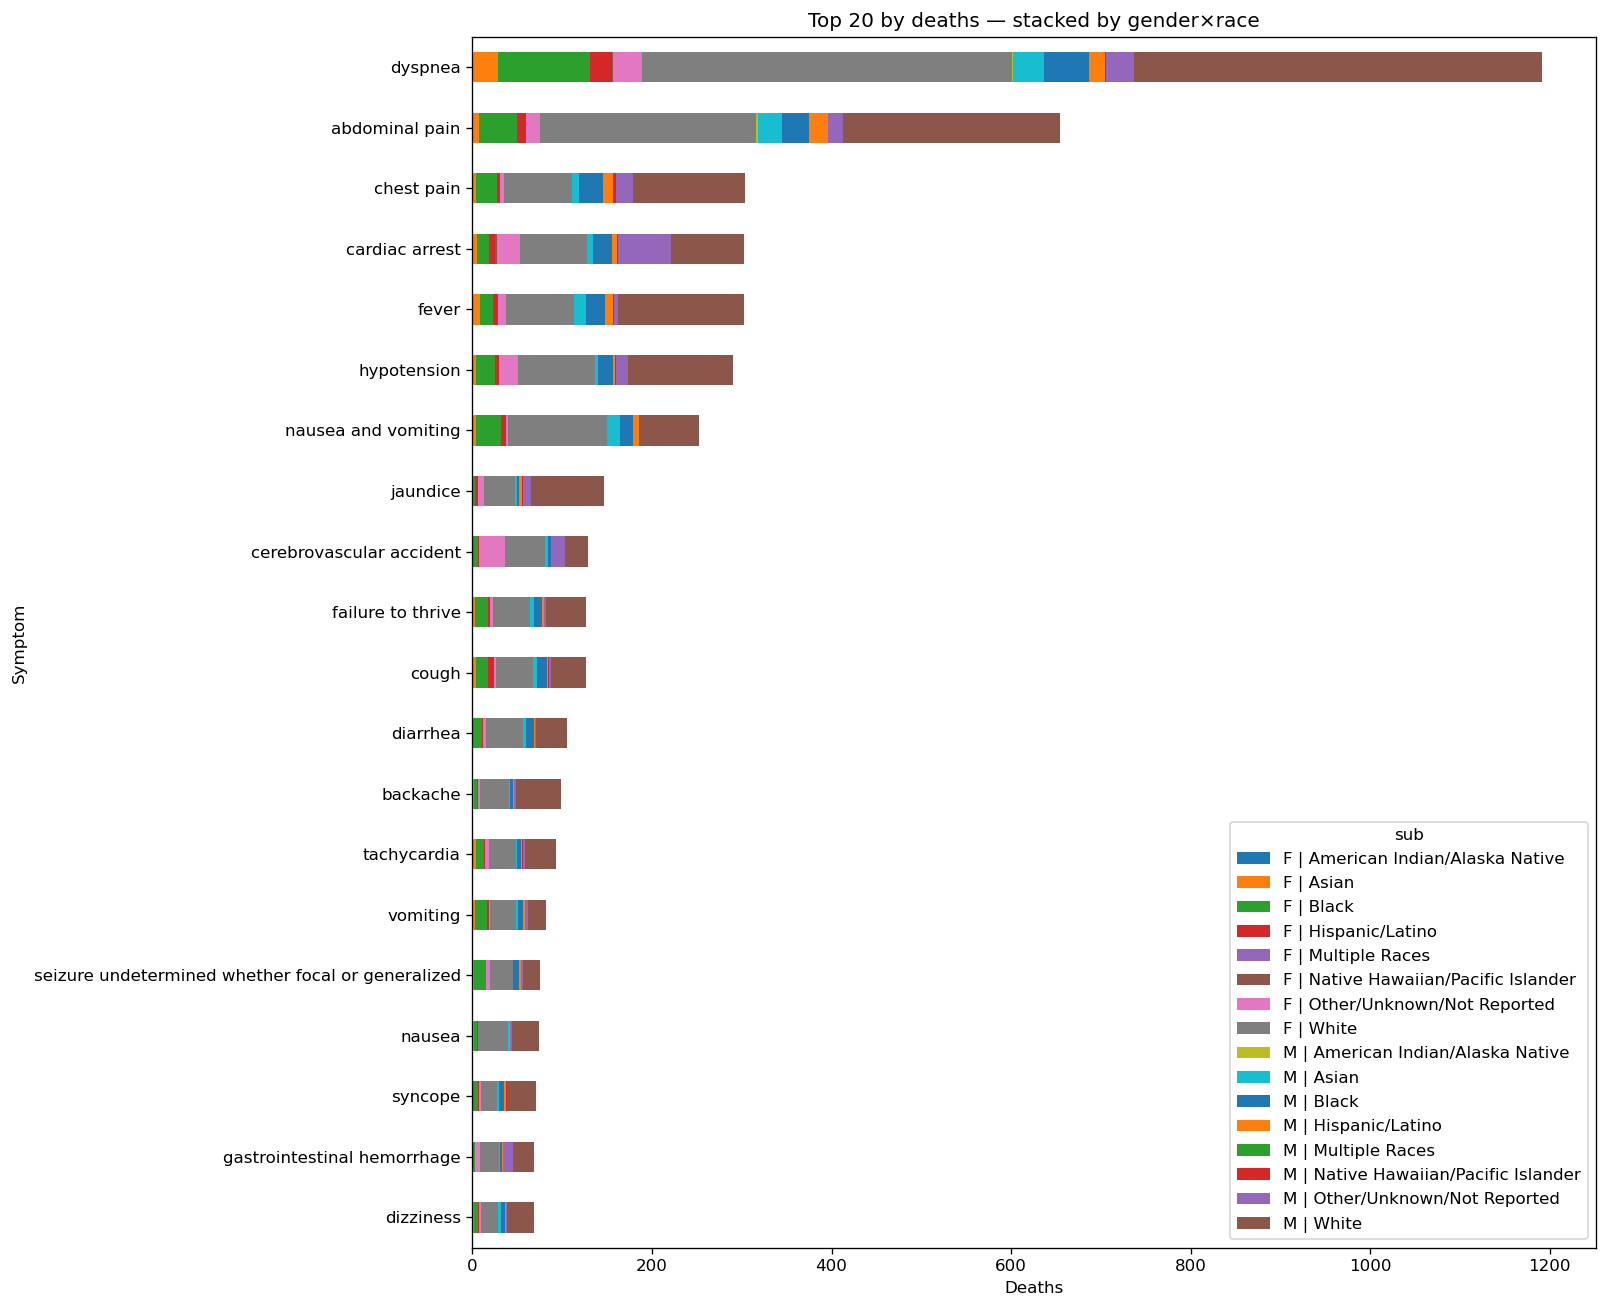

In [34]:
def plot_deadliest20_stacked_by_race(df,
                                     name_col="expanded_symptoms_new",
                                     race_col="race_standard",
                                     y_col="died_within_30_days",
                                     top_n=20):
    deaths = (df.groupby([name_col, race_col])[y_col]
                .sum().rename("deaths").reset_index())
    totals = deaths.groupby(name_col)["deaths"].sum().sort_values(ascending=False)
    top_syms = totals.head(top_n).index
    sub = deaths[deaths[name_col].isin(top_syms)]
    pivot = (sub.pivot(index=name_col, columns=race_col, values="deaths")
                .fillna(0).astype(int))
    pivot = pivot.loc[top_syms]

    ax = pivot.plot(kind="barh", stacked=True,
                    figsize=(12, max(3.0, 0.55*len(pivot))))
    ax.set_title(f"Top {top_n} by deaths — stacked by race")
    ax.set_xlabel("Deaths"); ax.set_ylabel("Symptom"); ax.invert_yaxis()
    plt.tight_layout()
    savefig_numbered(f"deadliest_top{top_n}_symptoms_race_deaths_stacked")
    plt.show(); plt.close()


def plot_deadliest20_stacked_by_gender_race(df,
                                            name_col="expanded_symptoms_new",
                                            gender_col="gender",
                                            race_col="race_standard",
                                            y_col="died_within_30_days",
                                            top_n=20):
    g = df[gender_col].astype(str).str.lower().map(
        lambda x: "F" if x.startswith("f") else ("M" if x.startswith("m") else x)
    )
    subgrp = g + " | " + df[race_col].astype(str)
    deaths = (df.assign(sub=subgrp)
                .groupby([name_col, "sub"])[y_col]
                .sum().rename("deaths").reset_index())
    totals = deaths.groupby(name_col)["deaths"].sum().sort_values(ascending=False)
    top_syms = totals.head(top_n).index
    sub = deaths[deaths[name_col].isin(top_syms)]
    pivot = (sub.pivot(index=name_col, columns="sub", values="deaths")
                .fillna(0).astype(int))
    pivot = pivot.loc[top_syms]

    ax = pivot.plot(kind="barh", stacked=True,
                    figsize=(13.5, max(3.0, 0.55*len(pivot))))
    ax.set_title(f"Top {top_n} by deaths — stacked by gender×race")
    ax.set_xlabel("Deaths"); ax.set_ylabel("Symptom"); ax.invert_yaxis()
    plt.tight_layout()
    savefig_numbered(f"deadliest_top{top_n}_symptoms_gender_race_deaths_stacked")
    plt.show(); plt.close()


# Optional deadliest plots:
plot_deadliest20_stacked_by_race(df_clean, top_n=20)
plot_deadliest20_stacked_by_gender_race(df_clean, top_n=20)


overall AUC: 0.8353287789034226

AUC by gender:
          AUC       n  events
group                       
F      0.850  136433    2467
M      0.812   96462    2706

AUC by race:
                                     AUC       n  events
group                                                  
White                             0.814  131424    3590
Black                             0.832   53687     683
Hispanic/Latino                   0.837   21868     196
Other/Unknown/Not Reported        0.894   14542     440
Asian                             0.843   10453     245
American Indian/Alaska Native     0.787     546       4
Native Hawaiian/Pacific Islander  0.897     285      15
Multiple Races                      NaN      90       0
[saved table] dataset/ed/finals/tables_Sep/step1\tables\22_table_overall_auc.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\23_table_auc_by_gender.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\24_table_auc_by_race_standard.csv

Flags

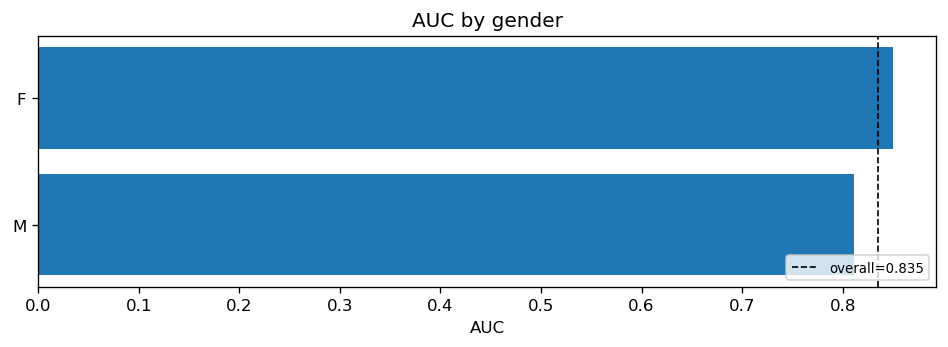

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\39_plot_auc_by_race_standard_bar.png


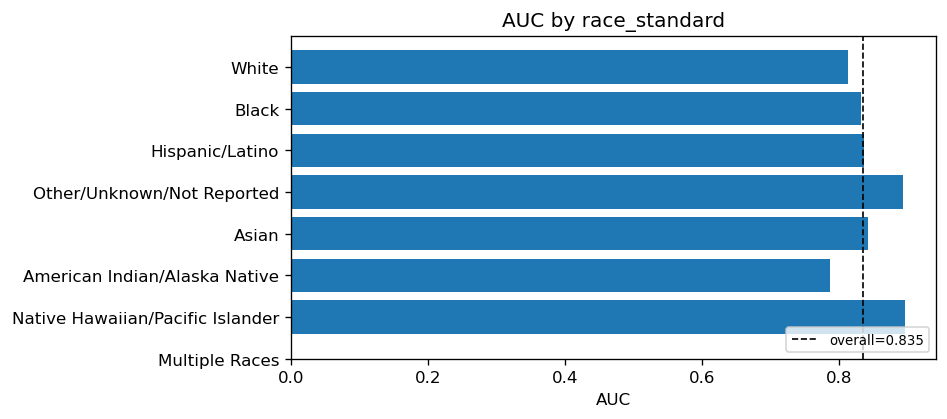

In [37]:
# ===== Cell 11: AUC-ROC >> bias detection (threshold-free, simple, with saving) =====

def auc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Compute AUC per group (no threshold). AUC is NaN if a group has only one class.
    Returns a DataFrame sorted by sample size.
    """
    rows = []
    for g, sub in df.groupby(group_col):
        y = _ensure_binary(sub[y_col])
        p = _safe_prob(sub[prob_col])
        auc_val = np.nan if len(np.unique(y)) < 2 else roc_auc_score(y, p)
        rows.append({"group": str(g), "AUC": auc_val, "n": len(sub), "events": int(y.sum())})
    out = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
    return out

def flag_bias_by_auc(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                     min_n=200, auc_drop=0.05):
    """
    Flag groups whose AUC is >= auc_drop below the overall AUC and have n >= min_n.
    """
    y_all = _ensure_binary(df[y_col])
    p_all = _safe_prob(df[prob_col])
    overall_auc = np.nan if len(np.unique(y_all)) < 2 else roc_auc_score(y_all, p_all)

    per = auc_by_group(df, group_col, prob_col, y_col).copy()
    per["overall_auc"] = overall_auc
    per["AUC_gap"] = overall_auc - per["AUC"]
    per["flag"] = (per["n"] >= min_n) & (per["AUC_gap"] >= auc_drop)
    return per

def plot_auc_bar(per_df, group_col_label="group"):
    """
    Horizontal bar chart of AUC by group with a vertical line at overall AUC.
    Expects columns: ['AUC','overall_auc'] and index as group names.
    """
    t = per_df.copy()
    labels = t.index.tolist()
    vals = t["AUC"].values
    overall = float(t["overall_auc"].iloc[0]) if "overall_auc" in t.columns else np.nan

    fig, ax = plt.subplots(figsize=(8, max(3.0, 0.45*len(t))))
    ax.barh(np.arange(len(t)), vals)
    ax.set_yticks(np.arange(len(t))); ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel("AUC")
    ax.set_title(f"AUC by {group_col_label}")
    if np.isfinite(overall):
        ax.axvline(overall, ls="--", lw=1, color="k", label=f"overall={overall:.3f}")
        ax.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    savefig_numbered(f"auc_by_{group_col_label.lower().replace(' ','_')}_bar")
    plt.show(); plt.close()

def plot_roc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days", title=None):
    """
    Plot overall ROC and overlay per-group curves (only for groups with both classes).
    Saves via savefig_numbered().
    """
    y = _ensure_binary(df[y_col])
    p = _safe_prob(df[prob_col])
    fpr, tpr, _ = roc_curve(y, p)
    base_auc = auc(fpr, tpr)

    plt.figure(figsize=(6.5,5))
    plt.plot(fpr, tpr, label=f"Overall AUC={base_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--", label="No-skill")

    for g, sub in df.groupby(group_col):
        yy = _ensure_binary(sub[y_col])
        if len(np.unique(yy)) < 2:
            continue
        pp = _safe_prob(sub[prob_col])
        f, t, _ = roc_curve(yy, pp)
        plt.plot(f, t, label=f"{g} (AUC={roc_auc_score(yy, pp):.3f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title or f"ROC by {group_col}")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    savefig_numbered(f"roc_by_{group_col.lower().replace(' ','_')}")
    plt.show(); plt.close()


# ---------- RUN + SAVE TABLES/PLOTS ----------
# Per-group AUC tables
auc_gender = auc_by_group(df_clean, "gender")
auc_race   = auc_by_group(df_clean, "race_standard")

# Overall AUC table (1-row for convenience)
overall_auc = roc_auc_score(df_clean["died_within_30_days"].astype(int),
                            df_clean["mortality_prob"].astype(float))
overall_tbl = pd.DataFrame({"overall_AUC":[overall_auc]})

print("overall AUC:", overall_auc)
print("\nAUC by gender:\n", auc_gender.round(3))
print("\nAUC by race:\n", auc_race.round(3))

# Save AUC tables
save_table_numbered(overall_tbl, "overall_auc", index=False)
save_table_numbered(auc_gender.reset_index(), "auc_by_gender", index=False)
save_table_numbered(auc_race.reset_index(),   "auc_by_race_standard", index=False)

# Flags (and save)
flags_gender = flag_bias_by_auc(df_clean, "gender", auc_drop=0.05, min_n=200)
flags_race   = flag_bias_by_auc(df_clean, "race_standard", auc_drop=0.05, min_n=200)

print("\nFlags (gender):\n", flags_gender[["AUC","overall_auc","AUC_gap","n","flag"]])
print("\nFlags (race):\n",   flags_race[["AUC","overall_auc","AUC_gap","n","flag"]])

save_table_numbered(flags_gender.reset_index(), "auc_flags_by_gender", index=False)
save_table_numbered(flags_race.reset_index(),   "auc_flags_by_race_standard", index=False)

# Save bar plots for AUC by group
plot_auc_bar(auc_gender.assign(overall_auc=overall_auc), group_col_label="gender")
plot_auc_bar(auc_race.assign(overall_auc=overall_auc),   group_col_label="race_standard")

# Optional: ROC overlays (also saved)
# plot_roc_by_group(df_clean, "gender", title="ROC by gender")
# plot_roc_by_group(df_clean, "race_standard", title="ROC by race_standard")


overal AUC: 0.8353287789034226

AUC by gender:
          AUC       n  events
group                       
F      0.850  136433    2467
M      0.812   96462    2706

AUC by race:
                                     AUC       n  events
group                                                  
White                             0.814  131424    3590
Black                             0.832   53687     683
Hispanic/Latino                   0.837   21868     196
Other/Unknown/Not Reported        0.894   14542     440
Asian                             0.843   10453     245
American Indian/Alaska Native     0.787     546       4
Native Hawaiian/Pacific Islander  0.897     285      15
Multiple Races                      NaN      90       0
[saved table] dataset/ed/finals/tables_Sep/step1\tables\27_table_auc_by_gender.csv
[saved table] dataset/ed/finals/tables_Sep/step1\tables\28_table_auc_by_race.csv

Flags (gender):
             AUC  overall_auc   AUC_gap       n   flag
group                    

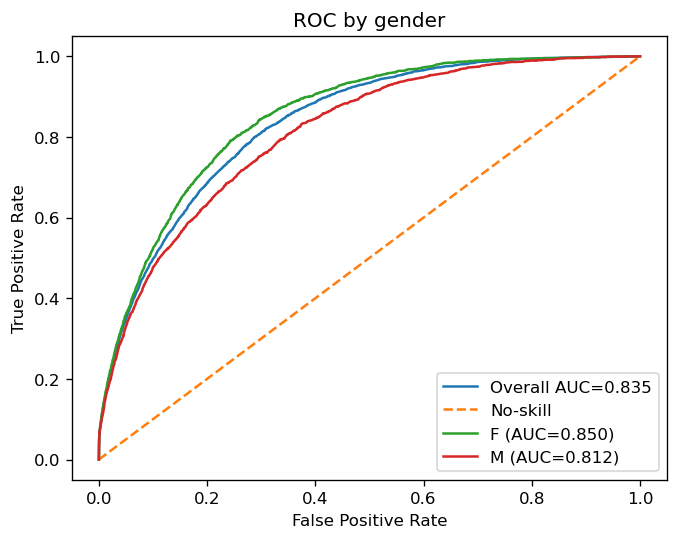

[saved plot]  dataset/ed/finals/tables_Sep/step1\plots\41_plot_roc_curve_by_race.png


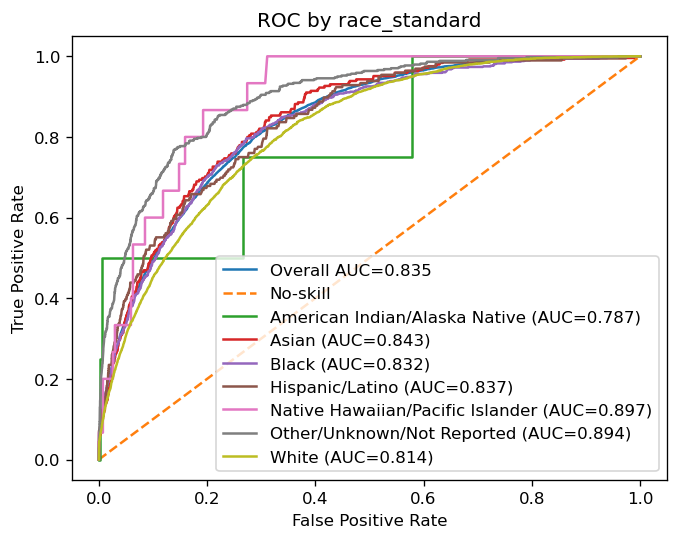

In [39]:
# ===== Cell 12: AUC-ROC >> bias detection (threshold-free, simple) =====
def auc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days"):
    """
    Compute AUC per group (no threshold). Groups with AUC much lower than overall
    deserve deeper fairness checks. AUC is NaN if a group has only one class.
    """
    rows = []
    for g, sub in df.groupby(group_col):
        y = _ensure_binary(sub[y_col])
        p = _safe_prob(sub[prob_col])
        auc_val = np.nan if len(np.unique(y)) < 2 else roc_auc_score(y, p)
        rows.append({"group": str(g), "AUC": auc_val, "n": len(sub), "events": int(y.sum())})
    out = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
    return out

def flag_bias_by_auc(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                     min_n=200, auc_drop=0.05):
    """
    Flag groups whose AUC is >= auc_drop below the overall AUC and have n >= min_n.
    """
    y_all = _ensure_binary(df[y_col])
    p_all = _safe_prob(df[prob_col])
    overall_auc = np.nan if len(np.unique(y_all)) < 2 else roc_auc_score(y_all, p_all)

    per = auc_by_group(df, group_col, prob_col, y_col).copy()
    per["overall_auc"] = overall_auc
    per["AUC_gap"] = overall_auc - per["AUC"]
    per["flag"] = (per["n"] >= min_n) & (per["AUC_gap"] >= auc_drop)
    return per

def plot_roc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days", title=None):
    """
    Plot overall ROC and overlay per-group curves (only for groups with both classes).
    NOTE: This function DOES NOT call plt.show(). Save/Show outside for reliable file output.
    """
    y = _ensure_binary(df[y_col])
    p = _safe_prob(df[prob_col])
    fpr, tpr, _ = roc_curve(y, p)
    base_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"Overall AUC={base_auc:.3f}")
    plt.plot([0, 1], [0, 1], "--", label="No-skill")

    for g, sub in df.groupby(group_col):
        yy = _ensure_binary(sub[y_col])
        if len(np.unique(yy)) < 2:
            continue
        pp = _safe_prob(sub[prob_col])
        f, t, _ = roc_curve(yy, pp)
        plt.plot(f, t, label=f"{g} (AUC={roc_auc_score(yy, pp):.3f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title or f"ROC by {group_col}")
    plt.legend(loc="lower right")
    # no plt.show() here

# ___________________________________________________________________________

# Running AUC by gender and race
auc_gender = auc_by_group(df_clean, "gender")
auc_race   = auc_by_group(df_clean, "race_standard")

overall_auc = roc_auc_score(df_clean["died_within_30_days"].astype(int),
                            df_clean["mortality_prob"].astype(float))

print("overal AUC:", overall_auc)

print("\nAUC by gender:\n", auc_gender.round(3))
print("\nAUC by race:\n", auc_race.round(3))

# 👉 Save the AUC summary tables
save_table_numbered(auc_gender, "auc_by_gender", index=True)
save_table_numbered(auc_race, "auc_by_race", index=True)

# Flag groups with notable AUC drop vs overall (e.g., >= 0.05 and n >= 200)
flags_gender = flag_bias_by_auc(df_clean, "gender", auc_drop=0.05, min_n=200)
flags_race   = flag_bias_by_auc(df_clean, "race_standard", auc_drop=0.05, min_n=200)

print("\nFlags (gender):\n", flags_gender[["AUC","overall_auc","AUC_gap","n","flag"]])
print("\nFlags (race):\n",   flags_race[["AUC","overall_auc","AUC_gap","n","flag"]])

# 👉 Save the bias-flagging tables
save_table_numbered(flags_gender[["AUC","overall_auc","AUC_gap","n","flag"]],
                    "flagged_bias_groups_gender", index=True)
save_table_numbered(flags_race[["AUC","overall_auc","AUC_gap","n","flag"]],
                    "flagged_bias_groups_race", index=True)

# (Optional) also save a tiny one-row table for the overall AUC for traceability
save_table_numbered(pd.DataFrame({"overall_auc":[overall_auc]}).set_index(pd.Index(["overall"])),
                    "overall_auc_summary", index=True)

# ___________________________________________________________________________

# Plotting ROC by gender (overlayed on overall)
plot_roc_by_group(df_clean, "gender", title="ROC by gender")
savefig_numbered("roc_curve_by_gender"); plt.show(); plt.close()

# ROC by race (skips groups that don't have both classes)
plot_roc_by_group(df_clean, "race_standard", title="ROC by race_standard")
savefig_numbered("roc_curve_by_race"); plt.show(); plt.close()


In [41]:
# test:

# AUC in Overal

overall_auc = roc_auc_score(df_clean["died_within_30_days"].astype(int),
                            df_clean["mortality_prob"].astype(float))
overall_auc

0.8353287789034226

In [43]:
# test :
# double-checking AUC by gender:

auc_by_gender = df_clean.groupby("gender").apply(
    lambda g: roc_auc_score(g["died_within_30_days"].astype(int),
                            g["mortality_prob"].astype(float))
              if g["died_within_30_days"].nunique()==2 else np.nan
)

auc_by_gender


C:\Users\mitra\AppData\Local\Temp\ipykernel_50136\3203510880.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  auc_by_gender = df_clean.groupby("gender").apply(


gender
F    0.850214
M    0.811640
dtype: float64

In [ ]:
# ============================= Cell 13: AUC-ROC >> bias detection (threshold-free, simple) =================
# with bootstrap CI and .... 
# ==========================================================================================================


# --- Safety helpers (define if not already) ---
def _ensure_binary(y):
    y = pd.Series(y).astype(float)
    # map truthy to 1.0, falsy to 0.0 if not strictly {0,1}
    uniq = pd.unique(y.dropna())
    if set(uniq) - {0.0, 1.0}:
        y = (y > 0).astype(int)
    return y.values.astype(int)

def _safe_prob(p):
    p = pd.Series(p).astype(float)
    return p.clip(0.0, 1.0).values

def _has_both_classes(y):
    u = np.unique(y)
    return len(u) == 2

def _bootstrap_auc_ci(y, p, n_boot=1000, alpha=0.05, rng_seed=42):
    """Simple percentile bootstrap CI for AUC (no stratification)."""
    rng = np.random.default_rng(rng_seed)
    y = np.asarray(y); p = np.asarray(p)
    if not _has_both_classes(y):
        return (np.nan, np.nan, np.nan)
    base = roc_auc_score(y, p)
    n = len(y)
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yy, pp = y[idx], p[idx]
        if _has_both_classes(yy):
            boots.append(roc_auc_score(yy, pp))
    if len(boots) == 0:
        return (base, np.nan, np.nan)
    lo = np.percentile(boots, 100 * (alpha/2))
    hi = np.percentile(boots, 100 * (1 - alpha/2))
    return (base, lo, hi)

# --- Core metrics ---
def auc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                 with_ci=True, n_boot=1000):
    """
    Compute AUC per group (no threshold). AUC is NaN if a group has only one class.
    Optionally includes bootstrap 95% CI.
    """
    rows = []
    for g, sub in df.groupby(group_col, dropna=False):
        y = _ensure_binary(sub[y_col])
        p = _safe_prob(sub[prob_col])

        if with_ci:
            a, lo, hi = _bootstrap_auc_ci(y, p, n_boot=n_boot)
            rows.append({
                "group": str(g),
                "AUC": a,
                "AUC_lo95": lo,
                "AUC_hi95": hi,
                "n": len(sub),
                "events": int(np.nansum(y))
            })
        else:
            a = np.nan if not _has_both_classes(y) else roc_auc_score(y, p)
            rows.append({
                "group": str(g),
                "AUC": a,
                "n": len(sub),
                "events": int(np.nansum(y))
            })

        # Warn if single-class (useful for fairness interpretation)
        if not _has_both_classes(y):
            print(f"[warn] {group_col}={g!r} has single class; AUC is undefined (NaN).")

    out = pd.DataFrame(rows).set_index("group").sort_values("n", ascending=False)
    return out

def flag_bias_by_auc(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days",
                     min_n=200, auc_drop=0.05, use_ci=True):
    """
    Flag groups whose AUC is >= auc_drop below the overall AUC and have n >= min_n.
    If use_ci=True, also require that group's upper CI < overall AUC (more conservative).
    """
    y_all = _ensure_binary(df[y_col])
    p_all = _safe_prob(df[prob_col])
    overall_auc, overall_lo, overall_hi = _bootstrap_auc_ci(y_all, p_all)  # CI useful context

    per = auc_by_group(df, group_col, prob_col, y_col, with_ci=use_ci).copy()
    per["overall_auc"] = overall_auc
    per["AUC_gap"] = per["overall_auc"] - per["AUC"]

    # Base flag: gap threshold + sample size
    base_flag = (per["n"] >= min_n) & (per["AUC_gap"] >= auc_drop)

    if use_ci and {"AUC_hi95"}.issubset(per.columns):
        # Conservative: only flag if the group's *upper* CI is still below overall AUC
        ci_flag = per["AUC_hi95"].notna() & (per["AUC_hi95"] < overall_auc)
        per["flag"] = base_flag & ci_flag
    else:
        per["flag"] = base_flag

    return per

def plot_roc_by_group(df, group_col, prob_col="mortality_prob", y_col="died_within_30_days", title=None):
    """
    Create an ROC figure with overall curve + per-group curves (only groups with both classes).
    Returns (fig, ax). Does NOT call plt.show().
    """
    y = _ensure_binary(df[y_col])
    p = _safe_prob(df[prob_col])
    fpr, tpr, _ = roc_curve(y, p)
    base_auc = auc(fpr, tpr)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"Overall AUC={base_auc:.3f}")
    ax.plot([0, 1], [0, 1], "--", label="No-skill")

    for g, sub in df.groupby(group_col, dropna=False):
        yy = _ensure_binary(sub[y_col])
        if not _has_both_classes(yy):
            continue
        pp = _safe_prob(sub[prob_col])
        f, t, _ = roc_curve(yy, pp)
        ax.plot(f, t, label=f"{g} (AUC={roc_auc_score(yy, pp):.3f})")

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title or f"ROC by {group_col}")
    ax.legend(loc="lower right")
    return fig, ax

# ___________________________________________________________________________

# Running AUC by gender and race
auc_gender = auc_by_group(df_clean, "gender")
auc_race   = auc_by_group(df_clean, "race_standard")

overall_auc, overall_lo, overall_hi = _bootstrap_auc_ci(
    _ensure_binary(df_clean["died_within_30_days"]),
    _safe_prob(df_clean["mortality_prob"])
)

print(f"overall AUC: {overall_auc:.3f}  (95% CI: {overall_lo:.3f}, {overall_hi:.3f})")
print("\nAUC by gender:\n", auc_gender.round(3))
print("\nAUC by race:\n", auc_race.round(3))

# Save AUC tables (rounded for readability)
save_table_numbered(auc_gender.round(3), "auc_by_gender", index=True)
save_table_numbered(auc_race.round(3),   "auc_by_race",   index=True)
save_table_numbered(pd.DataFrame({"overall_auc":[overall_auc],
                                  "overall_lo95":[overall_lo],
                                  "overall_hi95":[overall_hi]}),
                    "overall_auc_summary", index=False)

# Flags (conservative with CI)
flags_gender = flag_bias_by_auc(df_clean, "gender", auc_drop=0.05, min_n=200, use_ci=True)
flags_race   = flag_bias_by_auc(df_clean, "race_standard", auc_drop=0.05, min_n=200, use_ci=True)

print("\nFlags (gender):\n", flags_gender[["AUC","AUC_lo95","AUC_hi95","overall_auc","AUC_gap","n","flag"]])
print("\nFlags (race):\n",   flags_race[["AUC","AUC_lo95","AUC_hi95","overall_auc","AUC_gap","n","flag"]])

save_table_numbered(flags_gender[["AUC","AUC_lo95","AUC_hi95","overall_auc","AUC_gap","n","flag"]]
                    .round(3), "flagged_bias_groups_gender", index=True)
save_table_numbered(flags_race[["AUC","AUC_lo95","AUC_hi95","overall_auc","AUC_gap","n","flag"]]
                    .round(3), "flagged_bias_groups_race", index=True)

# ___________________________________________________________________________

# ROC plots (save then show/close)
fig, ax = plot_roc_by_group(df_clean, "gender", title="ROC by gender")
savefig_numbered("roc_curve_by_gender"); plt.show(); plt.close(fig)

fig, ax = plot_roc_by_group(df_clean, "race_standard", title="ROC by race_standard")
savefig_numbered("roc_curve_by_race"); plt.show(); plt.close(fig)


In [ ]:
n_unique_symptoms = df_clean["expanded_symptoms_new"].nunique()
print("Number of unique symptoms:", n_unique_symptoms)


Number of unique symptoms: 134


In [ ]:
# Group by symptom and calculate statistics
summary = (
    df_clean.groupby("expanded_symptoms_new")
    .agg(
        total_cases=("expanded_symptoms_new", "count"),
        total_deaths=("died_within_30_days", "sum"),
        male_cases=("gender", lambda x: (x == "M").sum()),
        female_cases=("gender", lambda x: (x == "F").sum()),
        male_deaths=("died_within_30_days", 
                     lambda y: ((df_clean.loc[y.index, "gender"] == "M") & (y == 1)).sum()),
        female_deaths=("died_within_30_days", 
                       lambda y: ((df_clean.loc[y.index, "gender"] == "F") & (y == 1)).sum()),
    )
    .reset_index()
    .rename(columns={"expanded_symptoms_new": "symptom"})
)

# Number of unique symptoms
n_unique_symptoms = summary["symptom"].nunique()
print("Total unique symptoms:", n_unique_symptoms)

# Display nicely
import caas_jupyter_tools
caas_jupyter_tools.display_dataframe_to_user("Symptom Summary", summary)


Total unique symptoms: 134


ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [ ]:
# ===== Symptom Summary Extended =====

summary = (
    df_clean.groupby("expanded_symptoms_new")
    .agg(
        total_cases=("expanded_symptoms_new", "count"),
        total_deaths=("died_within_30_days", "sum"),
        male_cases=("gender", lambda x: (x == "M").sum()),
        female_cases=("gender", lambda x: (x == "F").sum()),
        male_deaths=("died_within_30_days", 
                     lambda y: ((df_clean.loc[y.index, "gender"] == "M") & (y == 1)).sum()),
        female_deaths=("died_within_30_days", 
                       lambda y: ((df_clean.loc[y.index, "gender"] == "F") & (y == 1)).sum()),
    )
    .reset_index()
    .rename(columns={"expanded_symptoms_new": "symptom"})
)

# Add rates
summary["death_rate"] = summary["total_deaths"] / summary["total_cases"]
summary["male_death_rate"] = summary["male_deaths"] / summary["male_cases"].replace(0, pd.NA)
summary["female_death_rate"] = summary["female_deaths"] / summary["female_cases"].replace(0, pd.NA)

# Add fairness gap (male - female)
summary["death_rate_gap_male_female"] = summary["male_death_rate"] - summary["female_death_rate"]

# Sort by most common symptoms
summary_sorted = summary.sort_values("total_cases", ascending=False)

# Number of unique symptoms
n_unique_symptoms = summary["symptom"].nunique()
print("Total unique symptoms:", n_unique_symptoms)

# Show table
summary_sorted.head(20)   # show top 20 symptoms


In [ ]:
# =============================END ==============================================================================



print("\n                                END\n                            *** *** ***\n\n\n ")

# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================
# =============================END ==============================================================================

In [ ]:
# ===== Cell 00: print the formulas we use for Over-representation ratio & SMR in the following cells   ======================================

formulas = r"""
Formulas used in the next cells
--------------------------------

1) Over-representation ratio  (for a symptom s and group g)
   base_share_g   = N_g / N
   symptom_share  = N_{s,g} / N_s
   over_rep_{s,g} = symptom_share / base_share_g

   Where:
     N               = total patients in the dataset
     N_g             = total patients in group g (e.g., Female, White, etc.)
     N_s             = total patients with symptom s
     N_{s,g}         = patients with symptom s who are in group g

   Interpretation:
     = 1.0 → group appears as expected in symptom s
     > 1.0 → over-represented
     < 1.0 → under-represented

2) SMR (Standardized Mortality Ratio) for a symptom s
   overall_prev    = total_deaths / N
   expected_deaths = n_s * overall_prev
   SMR_s           = observed_deaths_s / expected_deaths

   Where:
     n_s                = total patients with symptom s
     observed_deaths_s  = deaths among patients with symptom s

   Interpretation:
     = 1.0 → deaths as expected given dataset-wide prevalence
     > 1.0 → more deaths than expected
     < 1.0 → fewer deaths than expected
"""
print(formulas)


In [ ]:
# 1) Balance (unchanged)
print("By gender (balance):\n", group_balance(df_clean, "gender").round(3))
print("\nBy race_standard (balance):\n", group_balance(df_clean, "race_standard").round(3))

# 2) Top symptoms (now show code + name)
print("\nTop symptoms by volume:\n",
      symptom_counts(df_clean, symptom_col="symptom", name_col="expanded_symptoms_new", k=20))

print("\nTop symptoms by deaths (absolute):\n",
      symptom_deaths(df_clean, symptom_col="symptom", name_col="expanded_symptoms_new",
                     y_col="died_within_30_days", k=20))

print("\nTop 'deadly' symptoms by case-fatality (min_n=100):\n",
      symptom_case_fatality(df_clean, symptom_col="symptom", name_col="expanded_symptoms_new",
                            y_col="died_within_30_days", min_n=100, sort_by='cfr', k=20))

# 3) Symptom × gender CFR (shows code + name)
sym_gender_long, sym_gender_top = symptom_by_group_cfr(
    df_clean, group_col="gender",
    symptom_col="symptom", name_col="expanded_symptoms_new",
    y_col="died_within_30_days", min_n=50
)
print("\nSymptom × gender (all cells ≥50):\n", sym_gender_long.head(10))
print("\nTop per gender by CFR:\n", sym_gender_top.groupby("gender").head(10))

# 4) Symptom × race CFR
sym_race_long, sym_race_top = symptom_by_group_cfr(
    df_clean, group_col="race_standard",
    symptom_col="symptom", name_col="expanded_symptoms_new",
    y_col="died_within_30_days", min_n=50
)
print("\nTop per race by CFR:\n", sym_race_top.groupby("race_standard").head(10))

# 5) Intersections (symptom code + name × gender × race), n ≥ 100
intersect = symptom_by_intersection_cfr(
    df_clean,
    group_cols=("symptom","gender","race_standard"),
    name_col="expanded_symptoms_new",
    y_col="died_within_30_days",
    min_n=100
)
print("\nTop intersections by CFR (n ≥ 100):\n", intersect.head(20))


In [ ]:
1. GENDER BIAS - PARADOXICAL PATTERN  (def group_balance)
 Males have 56% higher mortality rate (2.8% vs 1.8%)

Clinical Reality vs Bias: This could reflect:
Legitimate biological differences (males higher cardiovascular risk)
BIAS: Later presentation, delayed care-seeking behavior
BIAS: Different symptom interpretation by providers
_____________________________________________________________________________________________________________
2-  RACIAL DISPARITIES - SEVERE INEQUITIES
Most Concerning Groups:
Native Hawaiian/Pacific Islander: 5.3% mortality (2.4x average)
Other/Unknown/Not Reported: 3.0% mortality (1.4x average)
White: 2.7% mortality (1.2x average)

Unexpectedly Low Mortality Groups:
Hispanic/Latino: 0.9% mortality (0.4x average) ⚠️
American Indian/Alaska Native: 0.7% mortality (0.3x average) ⚠️
Black: 1.3% mortality (0.6x average) ⚠️

BIAS ANALYSIS: The low mortality rates for historically disadvantaged groups suggest:

Selection Bias: Only the healthiest patients from these groups reach the ED
Access Barriers: Sicker patients may not make it to hospital
Coding Bias: Misclassification of race/ethnicity
Geographic Bias: Hospital location affects patient mix
_________________________________________________________________________________________________________________
3. DEADLIEST SYMPTOMS (Case Fatality Rates)
Cardiac Arrest: 70.2% mortality (expected)
Sepsis: 25.4% mortality (expected)
Cerebrovascular Accident: 16.4% mortality (expected)
Jaundice: 16.2% mortality (concerning - suggests late-stage disease)
Failure to Thrive: 15.9% mortality (geriatric concern)
________________________________________________________________________________________________________________
4. GENDER-SYMPTOM INTERACTIONS - KEY BIAS INDICATORS
Female Mortality Advantage Lost:
Cardiac Arrest: Female 76.2% vs Male 66.4% mortality     BIAS CONCERN: Females dying more from cardiac arrest suggests:
Later recognition of cardiac symptoms in women
Different symptom presentations not recognized
Delayed treatment decisions


Consistent Male Mortality Disadvantage:
Sepsis: Female 29.6% vs Male 22.5% mortality (unusual pattern)
Stroke: Female 18.9% vs Male 13.4% mortality (unexpected)
Jaundice: Female 12.9% vs Male 18.5% mortality (male disadvantage)
________________________________________________________________________________________________________________

5. INTERSECTIONAL BIAS - MOST VULNERABLE GROUPS
Highest Risk Intersections:
Male + White + Cardiac Arrest: 65.3% mortality
Female + Other/Unknown + Stroke: 24.4% mortality
Male + White + Jaundice: 19.7% mortality
Female + White + Stroke: 18.6% mortality

Concerning Patterns by Race-Symptom:
White patients with cardiac arrest: 74.3% mortality (highest)
Other/Unknown with GI bleeding: 23.2% mortality (very high)
Other/Unknown with hypotension: 23.1% mortality (very high)






1. Symptom Recognition Bias
Chest Pain: 28,940 cases, only 304 deaths (1.05% mortality)
Concern: Are female chest pain symptoms being dismissed?
Action: Analyze chest pain → cardiac arrest progression by gender

2. Diagnostic Bias
Dyspnea (Shortness of Breath): 21,527 cases, 1,192 deaths (5.5% mortality)
High mortality suggests late recognition
Gender pattern: Female 5.04% vs Male 8.03% mortality
Race pattern: Asian 8.05% vs Hispanic 2.85% mortality

3. Treatment Delay Bias
Hypotension: Shows consistent disparities
White: 12.3% mortality
Black: 10.1% mortality
Asian: 11.0% mortality
Suggests different treatment intensities